# Machine Learning (COSC 522)
## Project 5

## If in Google Collab, run this

In [1]:
# Import Jupyter Widgets
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display
# Clone the repository if you're in Google Collab
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
def mount_and_change_dir(is_collab: bool = False):
    # Set working directory
    project_path = '/content/drive/MyDrive/Projects/UTK/COSC522'
    os.chdir(project_path)
    print(os.listdir(project_path))
       
print("Are you on Google Collab?")
btn = widgets.Button(description="Yes")
btn.on_click(mount_and_change_dir)
display(btn)

Are you on Google Collab?


Button(description='Yes', style=ButtonStyle())

## Import libraries

In [26]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ['png']

import numpy as np
import matplotlib.pyplot as plt
from time import time
from pprint import pprint
import seaborn as sns
from scipy.stats import uniform, gaussian_kde, norm
from typing import *
from tqdm.notebook import tqdm

from custom_libs import ColorizedLogger

sns.set_style('darkgrid')

logger = ColorizedLogger('Project', 'yellow')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import custom classes

In [2]:
# Located in <project root>/custom_libs/Project4
import custom_libs.Project4.models as p4_models
import custom_libs.Project4.plotter as p4_pl
# Located in <project root>/custom_libs/Project5
import custom_libs.Project5.models as p5_models
import custom_libs.Project5.data_loader as dl
import custom_libs.Project5.plotter as p5_pl

# Task 1 - Train a BPNN on the Pima dataset

## Load the two datasets and Preprocess them

In [4]:
# Create a Data Loader
datasets = ['pima']
data_loader = dl.DataLoader(datasets=datasets, data_folder='data')
# Standarize Pima
data_loader.standarize('pima')

In [5]:
# Get the two datasets
datasets = data_loader.get_datasets()
pima_tr, pima_te, pima_val = datasets['pima']
# Print their statistics
data_loader._print_statistics(pima_tr, 'pima_tr')
data_loader._print_statistics(pima_te, 'pima_te')
data_loader._print_statistics(pima_val, 'pima_val')

2021-11-20 18:18:18 Data Loader  INFO     -- pima_tr --
2021-11-20 18:18:18 Data Loader  INFO     	Shape: (140, 8)
2021-11-20 18:18:18 Data Loader  INFO     	Type: float64
2021-11-20 18:18:18 Data Loader  INFO     	Mean:
2021-11-20 18:18:18 Data Loader  INFO     		[ 3.37031990e-17  8.08876775e-17 -1.99840144e-16  9.42698300e-17] (..)
2021-11-20 18:18:18 Data Loader  INFO     	Max:
2021-11-20 18:18:18 Data Loader  INFO     		[3.13022038 2.30866844 3.25279582 5.78452775] (..)
2021-11-20 18:18:18 Data Loader  INFO     	Min:
2021-11-20 18:18:18 Data Loader  INFO     		[-1.08933391 -2.10411962 -2.92200303 -1.87977813] (..)
2021-11-20 18:18:18 Data Loader  INFO     	Head:
2021-11-20 18:18:18 Data Loader  INFO     		[1.32183997 0.92002884 0.71023159 0.20291369] (..)
2021-11-20 18:18:18 Data Loader  INFO     -- pima_te --
2021-11-20 18:18:18 Data Loader  INFO     	Shape: (332, 8)
2021-11-20 18:18:18 Data Loader  INFO     	Type: float64
2021-11-20 18:18:18 Data Loader  INFO     	Mean:
2021-11-2

In [6]:
# One Hot Encode the target values
pima_tr_y_one_hot = data_loader.one_hot_encode_last(pima_tr)
logger.info(f"pima_tr Y one hot encoded\n {pima_tr_y_one_hot[:3]}\n..")
pima_te_y_one_hot = data_loader.one_hot_encode_last(pima_te)
logger.info(f"pima_te Y one hot encoded\n {pima_te_y_one_hot[:3]}\n..")
pima_val_y_one_hot = data_loader.one_hot_encode_last(pima_val)
logger.info(f"pima_val Y one hot encoded\n {pima_val_y_one_hot[:3]}\n..")

2021-11-20 18:18:19 Project      INFO     pima_tr Y one hot encoded
 [[1. 0.]
 [0. 1.]
 [0. 1.]]
..
2021-11-20 18:18:19 Project      INFO     pima_te Y one hot encoded
 [[1. 0.]
 [0. 1.]
 [0. 1.]]
..
2021-11-20 18:18:19 Project      INFO     pima_val Y one hot encoded
 [[0. 1.]
 [0. 1.]
 [0. 1.]]
..


## Train, Test and Plot function

In [7]:
def train_dataset(name, dataset, targets, hidden_layers, activations, loss_functions, lr, momentum,
                   batch_size, early_stopping, max_epochs, regularization_param, shuffle, 
                   symmetric_weights, seed, debug):
    logger.nl()
    logger.info(f"Training {name} dataset..")
    # Number of units per layer
    n_units = [int(dataset.shape[1]-1), *hidden_layers, int(dataset[:, -1].max()+1)]
    # Initialize Model
    mlp = p4_models.MultiLayerPerceptron(units=n_units, activations=activations, 
                                         symmetric_weights=symmetric_weights,
                                         loss_functions=loss_functions, seed=seed)
    # Train
    accuracies, losses, times = mlp.train(data=dataset, one_hot_y=targets,
                                          batch_size=batch_size, lr=lr, momentum=momentum,
                                          shuffle=shuffle, max_epochs=max_epochs, 
                                          early_stopping=early_stopping,
                                          regularization_param=regularization_param,
                                          debug=debug)
    
    return mlp, accuracies, losses, times

def test_and_plot(title, test_set=None, one_hot_targets=None, model=None, accuracies=None, losses=None, times=None, subsample=1):    
    # Test the full dataset
    if isinstance(test_set, float):
      test_accuracy = test_set
    elif test_set is None:
        test_accuracy = None
    else:
      test_accuracy = model.test(test_set.copy(), one_hot_targets.copy(), debug)
    # Plot
    p4_pl.plot_results(title=title,
                      test_accuracy=test_accuracy,
                      accuracies=accuracies, 
                      losses=losses, 
                      times=times, subsample=subsample)

## Hyperparameter Tuning on Validation set

In [9]:
from itertools import product

# Lambda func to create string from list (for creating names)
join_lst = lambda lst: '-'.join([str(el) for el in lst])
# Static Hyperparams
loss_functions = ['mse', 'cross_entropy']
symmetric_weights = True
shuffle = True
seed = 3
early_stopping = {"max_accuracy": 0.999, 'wait': 2}
debug = {'epochs': 1, 'batches': 10**10, 
         'ff': False, 'bp': False, 'w': False, 'metrics': False}
pima_models = {}
pima_accuracies = {}
pima_losses = {}
pima_times = {}
# Hyperparams to test
max_epochs = 300
b_size_loops = (
            5,
            )
reg_loops = (
            0.01,
            0.05
            )
mom_loops = (
            0.00007,
            0.00012,
            )
lr_loops = (
            0.1,
            0.5,
            )
lay_act_loops = (
            ([32, 64, 32], ["sigmoid", "sigmoid", "sigmoid", "sigmoid"]),
            ([32, 128, 32], ["sigmoid", "sigmoid", "sigmoid", "sigmoid"]),
            ([32, 64, 64, 32], ["sigmoid", "sigmoid", "sigmoid", "sigmoid"]),
            )
# Create product of all combinations of the hyperparameters
params = list(product(lay_act_loops, lr_loops, mom_loops, reg_loops, b_size_loops))
logger.info(f"Number of Hyperparamater combinations to test: {len(params)}")
# Train on validation set and save results
for ind, (lay_act, lr, mom, reg, b_size) in enumerate(params):
    logger.nl(3)
    logger.info(f"Hyperparam combination {ind}")
    lay, act = lay_act
    name = f"lay.{join_lst(lay)}__act.{join_lst(act)}__lr.{lr}__b.{b_size}__mom.{mom}__reg.{reg}"
    pima_models[name], pima_accuracies[name], pima_losses[name], pima_times[name] = \
    train_dataset(name, pima_val.copy(), pima_val_y_one_hot.copy(), lay, act, 
                  loss_functions, lr, mom, b_size, early_stopping,
                  max_epochs, reg, shuffle, symmetric_weights, seed, debug)


2021-11-20 18:19:49 Project      INFO     Number of Hyperparamater combinations to test: 24

2021-11-20 18:19:49 Project      INFO     Training lay.32-64-32__act.sigmoid-sigmoid-sigmoid-sigmoid__lr.0.1__b.5__mom.7e-05__reg.0.01 dataset..
2021-11-20 18:19:49 Project4 Models INFO     Epoch: 1
2021-11-20 18:19:49 Project4 Models INFO       mse Loss: 0.38793
2021-11-20 18:19:49 Project4 Models INFO       cross_entropy Loss: 0.46916
2021-11-20 18:19:49 Project4 Models INFO       Accuracy: 16/60
2021-11-20 18:19:49 Project4 Models INFO     Epoch: 2
2021-11-20 18:19:49 Project4 Models INFO       mse Loss: 0.38747
2021-11-20 18:19:49 Project4 Models INFO       cross_entropy Loss: 0.46873
2021-11-20 18:19:49 Project4 Models INFO       Accuracy: 16/60
2021-11-20 18:19:49 Project4 Models INFO     Epoch: 3
2021-11-20 18:19:50 Project4 Models INFO       mse Loss: 0.38676
2021-11-20 18:19:50 Project4 Models INFO       cross_entropy Loss: 0.46701
2021-11-20 18:19:50 Project4 Models INFO       Accurac

2021-11-20 18:19:50 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:19:50 Project4 Models INFO     Epoch: 27
2021-11-20 18:19:50 Project4 Models INFO       mse Loss: 0.35549
2021-11-20 18:19:50 Project4 Models INFO       cross_entropy Loss: 0.39313
2021-11-20 18:19:50 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:19:50 Project4 Models INFO     Epoch: 28
2021-11-20 18:19:50 Project4 Models INFO       mse Loss: 0.35447
2021-11-20 18:19:50 Project4 Models INFO       cross_entropy Loss: 0.39212
2021-11-20 18:19:50 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:19:50 Project4 Models INFO     Epoch: 29
2021-11-20 18:19:50 Project4 Models INFO       mse Loss: 0.35352
2021-11-20 18:19:50 Project4 Models INFO       cross_entropy Loss: 0.39138
2021-11-20 18:19:50 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:19:50 Project4 Models INFO     Epoch: 30
2021-11-20 18:19:50 Project4 Models INFO       mse Loss: 0.35261
2021-11-20 18:19:50 Project4 Models INFO   

2021-11-20 18:19:51 Project4 Models INFO       mse Loss: 0.33011
2021-11-20 18:19:51 Project4 Models INFO       cross_entropy Loss: 0.36899
2021-11-20 18:19:51 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:19:51 Project4 Models INFO     Epoch: 54
2021-11-20 18:19:51 Project4 Models INFO       mse Loss: 0.32910
2021-11-20 18:19:51 Project4 Models INFO       cross_entropy Loss: 0.36785
2021-11-20 18:19:51 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:19:51 Project4 Models INFO     Epoch: 55
2021-11-20 18:19:51 Project4 Models INFO       mse Loss: 0.32803
2021-11-20 18:19:51 Project4 Models INFO       cross_entropy Loss: 0.36648
2021-11-20 18:19:51 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:19:51 Project4 Models INFO     Epoch: 56
2021-11-20 18:19:51 Project4 Models INFO       mse Loss: 0.32697
2021-11-20 18:19:51 Project4 Models INFO       cross_entropy Loss: 0.36511
2021-11-20 18:19:51 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:19:51 Pro

2021-11-20 18:19:52 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:19:52 Project4 Models INFO     Epoch: 80
2021-11-20 18:19:52 Project4 Models INFO       mse Loss: 0.30605
2021-11-20 18:19:52 Project4 Models INFO       cross_entropy Loss: 0.34645
2021-11-20 18:19:52 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:19:52 Project4 Models INFO     Epoch: 81
2021-11-20 18:19:52 Project4 Models INFO       mse Loss: 0.30512
2021-11-20 18:19:52 Project4 Models INFO       cross_entropy Loss: 0.34533
2021-11-20 18:19:52 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:19:52 Project4 Models INFO     Epoch: 82
2021-11-20 18:19:52 Project4 Models INFO       mse Loss: 0.30426
2021-11-20 18:19:52 Project4 Models INFO       cross_entropy Loss: 0.34450
2021-11-20 18:19:52 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:19:52 Project4 Models INFO     Epoch: 83
2021-11-20 18:19:52 Project4 Models INFO       mse Loss: 0.30343
2021-11-20 18:19:52 Project4 Models INFO   

2021-11-20 18:19:53 Project4 Models INFO       mse Loss: 0.28476
2021-11-20 18:19:53 Project4 Models INFO       cross_entropy Loss: 0.32639
2021-11-20 18:19:53 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:19:53 Project4 Models INFO     Epoch: 107
2021-11-20 18:19:53 Project4 Models INFO       mse Loss: 0.28390
2021-11-20 18:19:53 Project4 Models INFO       cross_entropy Loss: 0.32532
2021-11-20 18:19:53 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:19:53 Project4 Models INFO     Epoch: 108
2021-11-20 18:19:53 Project4 Models INFO       mse Loss: 0.28310
2021-11-20 18:19:53 Project4 Models INFO       cross_entropy Loss: 0.32451
2021-11-20 18:19:53 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:19:53 Project4 Models INFO     Epoch: 109
2021-11-20 18:19:53 Project4 Models INFO       mse Loss: 0.28217
2021-11-20 18:19:53 Project4 Models INFO       cross_entropy Loss: 0.32315
2021-11-20 18:19:53 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:19:53 

2021-11-20 18:19:54 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:19:54 Project4 Models INFO     Epoch: 133
2021-11-20 18:19:54 Project4 Models INFO       mse Loss: 0.26436
2021-11-20 18:19:54 Project4 Models INFO       cross_entropy Loss: 0.30680
2021-11-20 18:19:54 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:19:54 Project4 Models INFO     Epoch: 134
2021-11-20 18:19:54 Project4 Models INFO       mse Loss: 0.26364
2021-11-20 18:19:54 Project4 Models INFO       cross_entropy Loss: 0.30610
2021-11-20 18:19:54 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:19:54 Project4 Models INFO     Epoch: 135
2021-11-20 18:19:54 Project4 Models INFO       mse Loss: 0.26300
2021-11-20 18:19:54 Project4 Models INFO       cross_entropy Loss: 0.30576
2021-11-20 18:19:54 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:19:54 Project4 Models INFO     Epoch: 136
2021-11-20 18:19:54 Project4 Models INFO       mse Loss: 0.26213
2021-11-20 18:19:54 Project4 Models INF

2021-11-20 18:19:55 Project4 Models INFO       mse Loss: 0.24619
2021-11-20 18:19:55 Project4 Models INFO       cross_entropy Loss: 0.28903
2021-11-20 18:19:55 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:55 Project4 Models INFO     Epoch: 160
2021-11-20 18:19:55 Project4 Models INFO       mse Loss: 0.24542
2021-11-20 18:19:55 Project4 Models INFO       cross_entropy Loss: 0.28793
2021-11-20 18:19:55 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:55 Project4 Models INFO     Epoch: 161
2021-11-20 18:19:55 Project4 Models INFO       mse Loss: 0.24486
2021-11-20 18:19:55 Project4 Models INFO       cross_entropy Loss: 0.28774
2021-11-20 18:19:55 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:55 Project4 Models INFO     Epoch: 162
2021-11-20 18:19:55 Project4 Models INFO       mse Loss: 0.24419
2021-11-20 18:19:55 Project4 Models INFO       cross_entropy Loss: 0.28711
2021-11-20 18:19:55 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:55 

2021-11-20 18:19:55 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:55 Project4 Models INFO     Epoch: 186
2021-11-20 18:19:55 Project4 Models INFO       mse Loss: 0.22897
2021-11-20 18:19:55 Project4 Models INFO       cross_entropy Loss: 0.27264
2021-11-20 18:19:55 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:55 Project4 Models INFO     Epoch: 187
2021-11-20 18:19:55 Project4 Models INFO       mse Loss: 0.22856
2021-11-20 18:19:55 Project4 Models INFO       cross_entropy Loss: 0.27298
2021-11-20 18:19:55 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:55 Project4 Models INFO     Epoch: 188
2021-11-20 18:19:55 Project4 Models INFO       mse Loss: 0.22795
2021-11-20 18:19:55 Project4 Models INFO       cross_entropy Loss: 0.27240
2021-11-20 18:19:55 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:55 Project4 Models INFO     Epoch: 189
2021-11-20 18:19:55 Project4 Models INFO       mse Loss: 0.22731
2021-11-20 18:19:55 Project4 Models INF

2021-11-20 18:19:56 Project4 Models INFO       mse Loss: 0.21368
2021-11-20 18:19:56 Project4 Models INFO       cross_entropy Loss: 0.25793
2021-11-20 18:19:56 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:56 Project4 Models INFO     Epoch: 213
2021-11-20 18:19:56 Project4 Models INFO       mse Loss: 0.21306
2021-11-20 18:19:56 Project4 Models INFO       cross_entropy Loss: 0.25714
2021-11-20 18:19:56 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:19:56 Project4 Models INFO     Epoch: 214
2021-11-20 18:19:56 Project4 Models INFO       mse Loss: 0.21249
2021-11-20 18:19:56 Project4 Models INFO       cross_entropy Loss: 0.25657
2021-11-20 18:19:56 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:19:56 Project4 Models INFO     Epoch: 215
2021-11-20 18:19:56 Project4 Models INFO       mse Loss: 0.21182
2021-11-20 18:19:56 Project4 Models INFO       cross_entropy Loss: 0.25552
2021-11-20 18:19:56 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:19:56 

2021-11-20 18:19:57 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:57 Project4 Models INFO     Epoch: 239
2021-11-20 18:19:57 Project4 Models INFO       mse Loss: 0.19917
2021-11-20 18:19:57 Project4 Models INFO       cross_entropy Loss: 0.24429
2021-11-20 18:19:57 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:57 Project4 Models INFO     Epoch: 240
2021-11-20 18:19:57 Project4 Models INFO       mse Loss: 0.19874
2021-11-20 18:19:57 Project4 Models INFO       cross_entropy Loss: 0.24418
2021-11-20 18:19:57 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:57 Project4 Models INFO     Epoch: 241
2021-11-20 18:19:57 Project4 Models INFO       mse Loss: 0.19818
2021-11-20 18:19:57 Project4 Models INFO       cross_entropy Loss: 0.24347
2021-11-20 18:19:57 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:57 Project4 Models INFO     Epoch: 242
2021-11-20 18:19:57 Project4 Models INFO       mse Loss: 0.19790
2021-11-20 18:19:57 Project4 Models INF

2021-11-20 18:19:58 Project4 Models INFO       mse Loss: 0.18616
2021-11-20 18:19:58 Project4 Models INFO       cross_entropy Loss: 0.23135
2021-11-20 18:19:58 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:19:58 Project4 Models INFO     Epoch: 266
2021-11-20 18:19:58 Project4 Models INFO       mse Loss: 0.18591
2021-11-20 18:19:58 Project4 Models INFO       cross_entropy Loss: 0.23197
2021-11-20 18:19:58 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:58 Project4 Models INFO     Epoch: 267
2021-11-20 18:19:58 Project4 Models INFO       mse Loss: 0.18536
2021-11-20 18:19:58 Project4 Models INFO       cross_entropy Loss: 0.23115
2021-11-20 18:19:58 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:58 Project4 Models INFO     Epoch: 268
2021-11-20 18:19:58 Project4 Models INFO       mse Loss: 0.18482
2021-11-20 18:19:58 Project4 Models INFO       cross_entropy Loss: 0.23037
2021-11-20 18:19:58 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:19:58 

2021-11-20 18:19:59 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:59 Project4 Models INFO     Epoch: 292
2021-11-20 18:19:59 Project4 Models INFO       mse Loss: 0.17412
2021-11-20 18:19:59 Project4 Models INFO       cross_entropy Loss: 0.22084
2021-11-20 18:19:59 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:59 Project4 Models INFO     Epoch: 293
2021-11-20 18:19:59 Project4 Models INFO       mse Loss: 0.17360
2021-11-20 18:19:59 Project4 Models INFO       cross_entropy Loss: 0.21999
2021-11-20 18:19:59 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:19:59 Project4 Models INFO     Epoch: 294
2021-11-20 18:19:59 Project4 Models INFO       mse Loss: 0.17313
2021-11-20 18:19:59 Project4 Models INFO       cross_entropy Loss: 0.21943
2021-11-20 18:19:59 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:19:59 Project4 Models INFO     Epoch: 295
2021-11-20 18:19:59 Project4 Models INFO       mse Loss: 0.17288
2021-11-20 18:19:59 Project4 Models INF

2021-11-20 18:19:59 Project4 Models INFO       mse Loss: 1.29293
2021-11-20 18:19:59 Project4 Models INFO       cross_entropy Loss: 1.33016
2021-11-20 18:19:59 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:19:59 Project4 Models INFO     Epoch: 17
2021-11-20 18:19:59 Project4 Models INFO       mse Loss: 1.26483
2021-11-20 18:19:59 Project4 Models INFO       cross_entropy Loss: 1.30195
2021-11-20 18:19:59 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:19:59 Project4 Models INFO     Epoch: 18
2021-11-20 18:19:59 Project4 Models INFO       mse Loss: 1.23744
2021-11-20 18:19:59 Project4 Models INFO       cross_entropy Loss: 1.27460
2021-11-20 18:19:59 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:19:59 Project4 Models INFO     Epoch: 19
2021-11-20 18:19:59 Project4 Models INFO       mse Loss: 1.21061
2021-11-20 18:19:59 Project4 Models INFO       cross_entropy Loss: 1.24775
2021-11-20 18:19:59 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:19:59 Pro

2021-11-20 18:20:00 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:00 Project4 Models INFO     Epoch: 43
2021-11-20 18:20:00 Project4 Models INFO       mse Loss: 0.71709
2021-11-20 18:20:00 Project4 Models INFO       cross_entropy Loss: 0.75216
2021-11-20 18:20:00 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:00 Project4 Models INFO     Epoch: 44
2021-11-20 18:20:00 Project4 Models INFO       mse Loss: 0.70134
2021-11-20 18:20:00 Project4 Models INFO       cross_entropy Loss: 0.73568
2021-11-20 18:20:00 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:00 Project4 Models INFO     Epoch: 45
2021-11-20 18:20:00 Project4 Models INFO       mse Loss: 0.68650
2021-11-20 18:20:00 Project4 Models INFO       cross_entropy Loss: 0.72108
2021-11-20 18:20:00 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:00 Project4 Models INFO     Epoch: 46
2021-11-20 18:20:00 Project4 Models INFO       mse Loss: 0.67181
2021-11-20 18:20:00 Project4 Models INFO   

2021-11-20 18:20:01 Project4 Models INFO       mse Loss: 0.41103
2021-11-20 18:20:01 Project4 Models INFO       cross_entropy Loss: 0.44505
2021-11-20 18:20:01 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:01 Project4 Models INFO     Epoch: 70
2021-11-20 18:20:01 Project4 Models INFO       mse Loss: 0.40243
2021-11-20 18:20:01 Project4 Models INFO       cross_entropy Loss: 0.43640
2021-11-20 18:20:01 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:01 Project4 Models INFO     Epoch: 71
2021-11-20 18:20:01 Project4 Models INFO       mse Loss: 0.39414
2021-11-20 18:20:01 Project4 Models INFO       cross_entropy Loss: 0.42824
2021-11-20 18:20:01 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:01 Project4 Models INFO     Epoch: 72
2021-11-20 18:20:01 Project4 Models INFO       mse Loss: 0.38613
2021-11-20 18:20:01 Project4 Models INFO       cross_entropy Loss: 0.42053
2021-11-20 18:20:01 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:01 Pro

2021-11-20 18:20:02 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:02 Project4 Models INFO     Epoch: 96
2021-11-20 18:20:02 Project4 Models INFO       mse Loss: 0.23529
2021-11-20 18:20:02 Project4 Models INFO       cross_entropy Loss: 0.26900
2021-11-20 18:20:02 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:02 Project4 Models INFO     Epoch: 97
2021-11-20 18:20:02 Project4 Models INFO       mse Loss: 0.23074
2021-11-20 18:20:02 Project4 Models INFO       cross_entropy Loss: 0.26465
2021-11-20 18:20:02 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:02 Project4 Models INFO     Epoch: 98
2021-11-20 18:20:02 Project4 Models INFO       mse Loss: 0.22602
2021-11-20 18:20:02 Project4 Models INFO       cross_entropy Loss: 0.25973
2021-11-20 18:20:02 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:02 Project4 Models INFO     Epoch: 99
2021-11-20 18:20:02 Project4 Models INFO       mse Loss: 0.22151
2021-11-20 18:20:02 Project4 Models INFO   

2021-11-20 18:20:02 Project4 Models INFO       mse Loss: 0.14139
2021-11-20 18:20:02 Project4 Models INFO       cross_entropy Loss: 0.17461
2021-11-20 18:20:02 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:02 Project4 Models INFO     Epoch: 123
2021-11-20 18:20:02 Project4 Models INFO       mse Loss: 0.13876
2021-11-20 18:20:02 Project4 Models INFO       cross_entropy Loss: 0.17198
2021-11-20 18:20:02 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:02 Project4 Models INFO     Epoch: 124
2021-11-20 18:20:02 Project4 Models INFO       mse Loss: 0.13634
2021-11-20 18:20:02 Project4 Models INFO       cross_entropy Loss: 0.16978
2021-11-20 18:20:02 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:02 Project4 Models INFO     Epoch: 125
2021-11-20 18:20:03 Project4 Models INFO       mse Loss: 0.13369
2021-11-20 18:20:03 Project4 Models INFO       cross_entropy Loss: 0.16694
2021-11-20 18:20:03 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:03 

2021-11-20 18:20:03 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:03 Project4 Models INFO     Epoch: 149
2021-11-20 18:20:03 Project4 Models INFO       mse Loss: 0.08759
2021-11-20 18:20:03 Project4 Models INFO       cross_entropy Loss: 0.12140
2021-11-20 18:20:03 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:03 Project4 Models INFO     Epoch: 150
2021-11-20 18:20:03 Project4 Models INFO       mse Loss: 0.08609
2021-11-20 18:20:03 Project4 Models INFO       cross_entropy Loss: 0.11982
2021-11-20 18:20:03 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:03 Project4 Models INFO     Epoch: 151
2021-11-20 18:20:03 Project4 Models INFO       mse Loss: 0.08466
2021-11-20 18:20:03 Project4 Models INFO       cross_entropy Loss: 0.11839
2021-11-20 18:20:03 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:03 Project4 Models INFO     Epoch: 152
2021-11-20 18:20:03 Project4 Models INFO       mse Loss: 0.08316
2021-11-20 18:20:03 Project4 Models INF

2021-11-20 18:20:04 Project4 Models INFO       mse Loss: 0.05834
2021-11-20 18:20:04 Project4 Models INFO       cross_entropy Loss: 0.09212
2021-11-20 18:20:04 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:04 Project4 Models INFO     Epoch: 176
2021-11-20 18:20:04 Project4 Models INFO       mse Loss: 0.05744
2021-11-20 18:20:04 Project4 Models INFO       cross_entropy Loss: 0.09111
2021-11-20 18:20:04 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:04 Project4 Models INFO     Epoch: 177
2021-11-20 18:20:04 Project4 Models INFO       mse Loss: 0.05680
2021-11-20 18:20:04 Project4 Models INFO       cross_entropy Loss: 0.09074
2021-11-20 18:20:04 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:04 Project4 Models INFO     Epoch: 178
2021-11-20 18:20:04 Project4 Models INFO       mse Loss: 0.05603
2021-11-20 18:20:04 Project4 Models INFO       cross_entropy Loss: 0.09000
2021-11-20 18:20:04 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:04 

2021-11-20 18:20:05 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:05 Project4 Models INFO     Epoch: 202
2021-11-20 18:20:05 Project4 Models INFO       mse Loss: 0.04120
2021-11-20 18:20:05 Project4 Models INFO       cross_entropy Loss: 0.07489
2021-11-20 18:20:05 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:05 Project4 Models INFO     Epoch: 203
2021-11-20 18:20:05 Project4 Models INFO       mse Loss: 0.04066
2021-11-20 18:20:05 Project4 Models INFO       cross_entropy Loss: 0.07425
2021-11-20 18:20:05 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:05 Project4 Models INFO     Epoch: 204
2021-11-20 18:20:05 Project4 Models INFO       mse Loss: 0.04035
2021-11-20 18:20:05 Project4 Models INFO       cross_entropy Loss: 0.07415
2021-11-20 18:20:05 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:05 Project4 Models INFO     Epoch: 205
2021-11-20 18:20:05 Project4 Models INFO       mse Loss: 0.04011
2021-11-20 18:20:05 Project4 Models INF

2021-11-20 18:20:06 Project4 Models INFO       mse Loss: 0.03213
2021-11-20 18:20:06 Project4 Models INFO       cross_entropy Loss: 0.06605
2021-11-20 18:20:06 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:06 Project4 Models INFO     Epoch: 229
2021-11-20 18:20:06 Project4 Models INFO       mse Loss: 0.03193
2021-11-20 18:20:06 Project4 Models INFO       cross_entropy Loss: 0.06596
2021-11-20 18:20:06 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:06 Project4 Models INFO     Epoch: 230
2021-11-20 18:20:06 Project4 Models INFO       mse Loss: 0.03157
2021-11-20 18:20:06 Project4 Models INFO       cross_entropy Loss: 0.06543
2021-11-20 18:20:06 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:06 Project4 Models INFO     Epoch: 231
2021-11-20 18:20:06 Project4 Models INFO       mse Loss: 0.03148
2021-11-20 18:20:06 Project4 Models INFO       cross_entropy Loss: 0.06558
2021-11-20 18:20:06 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:06 

2021-11-20 18:20:06 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:06 Project4 Models INFO     Epoch: 255
2021-11-20 18:20:06 Project4 Models INFO       mse Loss: 0.02691
2021-11-20 18:20:06 Project4 Models INFO       cross_entropy Loss: 0.06104
2021-11-20 18:20:06 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:06 Project4 Models INFO     Epoch: 256
2021-11-20 18:20:06 Project4 Models INFO       mse Loss: 0.02676
2021-11-20 18:20:06 Project4 Models INFO       cross_entropy Loss: 0.06087
2021-11-20 18:20:06 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:06 Project4 Models INFO     Epoch: 257
2021-11-20 18:20:06 Project4 Models INFO       mse Loss: 0.02661
2021-11-20 18:20:06 Project4 Models INFO       cross_entropy Loss: 0.06071
2021-11-20 18:20:06 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:06 Project4 Models INFO     Epoch: 258
2021-11-20 18:20:06 Project4 Models INFO       mse Loss: 0.02632
2021-11-20 18:20:06 Project4 Models INF

2021-11-20 18:20:07 Project4 Models INFO       mse Loss: 0.02420
2021-11-20 18:20:07 Project4 Models INFO       cross_entropy Loss: 0.05857
2021-11-20 18:20:07 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:07 Project4 Models INFO     Epoch: 282
2021-11-20 18:20:07 Project4 Models INFO       mse Loss: 0.02405
2021-11-20 18:20:07 Project4 Models INFO       cross_entropy Loss: 0.05832
2021-11-20 18:20:07 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:07 Project4 Models INFO     Epoch: 283
2021-11-20 18:20:07 Project4 Models INFO       mse Loss: 0.02385
2021-11-20 18:20:07 Project4 Models INFO       cross_entropy Loss: 0.05793
2021-11-20 18:20:07 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:07 Project4 Models INFO     Epoch: 284
2021-11-20 18:20:07 Project4 Models INFO       mse Loss: 0.02380
2021-11-20 18:20:07 Project4 Models INFO       cross_entropy Loss: 0.05791
2021-11-20 18:20:07 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:07 

2021-11-20 18:20:08 Project4 Models INFO       cross_entropy Loss: 0.46337
2021-11-20 18:20:08 Project4 Models INFO       Accuracy: 16/60
2021-11-20 18:20:08 Project4 Models INFO     Epoch: 6
2021-11-20 18:20:08 Project4 Models INFO       mse Loss: 0.38611
2021-11-20 18:20:08 Project4 Models INFO       cross_entropy Loss: 0.45990
2021-11-20 18:20:08 Project4 Models INFO       Accuracy: 16/60
2021-11-20 18:20:08 Project4 Models INFO     Epoch: 7
2021-11-20 18:20:08 Project4 Models INFO       mse Loss: 0.38525
2021-11-20 18:20:08 Project4 Models INFO       cross_entropy Loss: 0.45575
2021-11-20 18:20:08 Project4 Models INFO       Accuracy: 16/60
2021-11-20 18:20:08 Project4 Models INFO     Epoch: 8
2021-11-20 18:20:08 Project4 Models INFO       mse Loss: 0.38447
2021-11-20 18:20:08 Project4 Models INFO       cross_entropy Loss: 0.45153
2021-11-20 18:20:08 Project4 Models INFO       Accuracy: 16/60
2021-11-20 18:20:08 Project4 Models INFO     Epoch: 9
2021-11-20 18:20:08 Project4 Models I

2021-11-20 18:20:09 Project4 Models INFO     Epoch: 32
2021-11-20 18:20:09 Project4 Models INFO       mse Loss: 0.36315
2021-11-20 18:20:09 Project4 Models INFO       cross_entropy Loss: 0.40069
2021-11-20 18:20:09 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:09 Project4 Models INFO     Epoch: 33
2021-11-20 18:20:09 Project4 Models INFO       mse Loss: 0.36259
2021-11-20 18:20:09 Project4 Models INFO       cross_entropy Loss: 0.40032
2021-11-20 18:20:09 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:09 Project4 Models INFO     Epoch: 34
2021-11-20 18:20:09 Project4 Models INFO       mse Loss: 0.36190
2021-11-20 18:20:09 Project4 Models INFO       cross_entropy Loss: 0.39955
2021-11-20 18:20:09 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:20:09 Project4 Models INFO     Epoch: 35
2021-11-20 18:20:09 Project4 Models INFO       mse Loss: 0.36116
2021-11-20 18:20:09 Project4 Models INFO       cross_entropy Loss: 0.39861
2021-11-20 18:20:09 Project4 Mo

2021-11-20 18:20:09 Project4 Models INFO       cross_entropy Loss: 0.38603
2021-11-20 18:20:09 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:09 Project4 Models INFO     Epoch: 59
2021-11-20 18:20:09 Project4 Models INFO       mse Loss: 0.34680
2021-11-20 18:20:09 Project4 Models INFO       cross_entropy Loss: 0.38623
2021-11-20 18:20:09 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:09 Project4 Models INFO     Epoch: 60
2021-11-20 18:20:09 Project4 Models INFO       mse Loss: 0.34606
2021-11-20 18:20:09 Project4 Models INFO       cross_entropy Loss: 0.38513
2021-11-20 18:20:09 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:09 Project4 Models INFO     Epoch: 61
2021-11-20 18:20:09 Project4 Models INFO       mse Loss: 0.34543
2021-11-20 18:20:09 Project4 Models INFO       cross_entropy Loss: 0.38443
2021-11-20 18:20:09 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:09 Project4 Models INFO     Epoch: 62
2021-11-20 18:20:10 Project4 Mode

2021-11-20 18:20:10 Project4 Models INFO     Epoch: 85
2021-11-20 18:20:10 Project4 Models INFO       mse Loss: 0.33183
2021-11-20 18:20:10 Project4 Models INFO       cross_entropy Loss: 0.37271
2021-11-20 18:20:10 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:10 Project4 Models INFO     Epoch: 86
2021-11-20 18:20:10 Project4 Models INFO       mse Loss: 0.33147
2021-11-20 18:20:10 Project4 Models INFO       cross_entropy Loss: 0.37305
2021-11-20 18:20:10 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:10 Project4 Models INFO     Epoch: 87
2021-11-20 18:20:10 Project4 Models INFO       mse Loss: 0.33082
2021-11-20 18:20:10 Project4 Models INFO       cross_entropy Loss: 0.37214
2021-11-20 18:20:10 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:10 Project4 Models INFO     Epoch: 88
2021-11-20 18:20:10 Project4 Models INFO       mse Loss: 0.33030
2021-11-20 18:20:10 Project4 Models INFO       cross_entropy Loss: 0.37179
2021-11-20 18:20:10 Project4 Mo

2021-11-20 18:20:11 Project4 Models INFO       cross_entropy Loss: 0.35994
2021-11-20 18:20:11 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:11 Project4 Models INFO     Epoch: 112
2021-11-20 18:20:11 Project4 Models INFO       mse Loss: 0.31716
2021-11-20 18:20:11 Project4 Models INFO       cross_entropy Loss: 0.35955
2021-11-20 18:20:11 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:11 Project4 Models INFO     Epoch: 113
2021-11-20 18:20:11 Project4 Models INFO       mse Loss: 0.31653
2021-11-20 18:20:11 Project4 Models INFO       cross_entropy Loss: 0.35863
2021-11-20 18:20:11 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:11 Project4 Models INFO     Epoch: 114
2021-11-20 18:20:11 Project4 Models INFO       mse Loss: 0.31588
2021-11-20 18:20:11 Project4 Models INFO       cross_entropy Loss: 0.35762
2021-11-20 18:20:11 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:11 Project4 Models INFO     Epoch: 115
2021-11-20 18:20:11 Project4 

2021-11-20 18:20:12 Project4 Models INFO     Epoch: 138
2021-11-20 18:20:12 Project4 Models INFO       mse Loss: 0.30386
2021-11-20 18:20:12 Project4 Models INFO       cross_entropy Loss: 0.34790
2021-11-20 18:20:12 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:12 Project4 Models INFO     Epoch: 139
2021-11-20 18:20:12 Project4 Models INFO       mse Loss: 0.30323
2021-11-20 18:20:12 Project4 Models INFO       cross_entropy Loss: 0.34689
2021-11-20 18:20:12 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:12 Project4 Models INFO     Epoch: 140
2021-11-20 18:20:12 Project4 Models INFO       mse Loss: 0.30249
2021-11-20 18:20:12 Project4 Models INFO       cross_entropy Loss: 0.34538
2021-11-20 18:20:12 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:12 Project4 Models INFO     Epoch: 141
2021-11-20 18:20:12 Project4 Models INFO       mse Loss: 0.30205
2021-11-20 18:20:12 Project4 Models INFO       cross_entropy Loss: 0.34517
2021-11-20 18:20:12 Project

2021-11-20 18:20:13 Project4 Models INFO       cross_entropy Loss: 0.33552
2021-11-20 18:20:13 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:13 Project4 Models INFO     Epoch: 165
2021-11-20 18:20:13 Project4 Models INFO       mse Loss: 0.29055
2021-11-20 18:20:13 Project4 Models INFO       cross_entropy Loss: 0.33560
2021-11-20 18:20:13 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:13 Project4 Models INFO     Epoch: 166
2021-11-20 18:20:13 Project4 Models INFO       mse Loss: 0.29000
2021-11-20 18:20:13 Project4 Models INFO       cross_entropy Loss: 0.33484
2021-11-20 18:20:13 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:13 Project4 Models INFO     Epoch: 167
2021-11-20 18:20:13 Project4 Models INFO       mse Loss: 0.28963
2021-11-20 18:20:13 Project4 Models INFO       cross_entropy Loss: 0.33489
2021-11-20 18:20:13 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:13 Project4 Models INFO     Epoch: 168
2021-11-20 18:20:13 Project4 

2021-11-20 18:20:13 Project4 Models INFO     Epoch: 191
2021-11-20 18:20:13 Project4 Models INFO       mse Loss: 0.27817
2021-11-20 18:20:13 Project4 Models INFO       cross_entropy Loss: 0.32332
2021-11-20 18:20:13 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:13 Project4 Models INFO     Epoch: 192
2021-11-20 18:20:13 Project4 Models INFO       mse Loss: 0.27785
2021-11-20 18:20:13 Project4 Models INFO       cross_entropy Loss: 0.32353
2021-11-20 18:20:13 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:13 Project4 Models INFO     Epoch: 193
2021-11-20 18:20:13 Project4 Models INFO       mse Loss: 0.27744
2021-11-20 18:20:13 Project4 Models INFO       cross_entropy Loss: 0.32332
2021-11-20 18:20:13 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:13 Project4 Models INFO     Epoch: 194
2021-11-20 18:20:13 Project4 Models INFO       mse Loss: 0.27720
2021-11-20 18:20:13 Project4 Models INFO       cross_entropy Loss: 0.32390
2021-11-20 18:20:13 Project

2021-11-20 18:20:14 Project4 Models INFO       cross_entropy Loss: 0.31355
2021-11-20 18:20:14 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:14 Project4 Models INFO     Epoch: 218
2021-11-20 18:20:14 Project4 Models INFO       mse Loss: 0.26653
2021-11-20 18:20:14 Project4 Models INFO       cross_entropy Loss: 0.31367
2021-11-20 18:20:14 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:14 Project4 Models INFO     Epoch: 219
2021-11-20 18:20:14 Project4 Models INFO       mse Loss: 0.26610
2021-11-20 18:20:14 Project4 Models INFO       cross_entropy Loss: 0.31328
2021-11-20 18:20:14 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:20:14 Project4 Models INFO     Epoch: 220
2021-11-20 18:20:14 Project4 Models INFO       mse Loss: 0.26555
2021-11-20 18:20:14 Project4 Models INFO       cross_entropy Loss: 0.31228
2021-11-20 18:20:14 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:20:14 Project4 Models INFO     Epoch: 221
2021-11-20 18:20:14 Project4 

2021-11-20 18:20:15 Project4 Models INFO     Epoch: 244
2021-11-20 18:20:15 Project4 Models INFO       mse Loss: 0.25549
2021-11-20 18:20:15 Project4 Models INFO       cross_entropy Loss: 0.30270
2021-11-20 18:20:15 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:20:15 Project4 Models INFO     Epoch: 245
2021-11-20 18:20:15 Project4 Models INFO       mse Loss: 0.25542
2021-11-20 18:20:15 Project4 Models INFO       cross_entropy Loss: 0.30409
2021-11-20 18:20:15 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:20:15 Project4 Models INFO     Epoch: 246
2021-11-20 18:20:15 Project4 Models INFO       mse Loss: 0.25491
2021-11-20 18:20:15 Project4 Models INFO       cross_entropy Loss: 0.30316
2021-11-20 18:20:15 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:20:15 Project4 Models INFO     Epoch: 247
2021-11-20 18:20:15 Project4 Models INFO       mse Loss: 0.25426
2021-11-20 18:20:15 Project4 Models INFO       cross_entropy Loss: 0.30151
2021-11-20 18:20:15 Project

2021-11-20 18:20:16 Project4 Models INFO       cross_entropy Loss: 0.29472
2021-11-20 18:20:16 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:20:16 Project4 Models INFO     Epoch: 271
2021-11-20 18:20:16 Project4 Models INFO       mse Loss: 0.24506
2021-11-20 18:20:16 Project4 Models INFO       cross_entropy Loss: 0.29408
2021-11-20 18:20:16 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:20:16 Project4 Models INFO     Epoch: 272
2021-11-20 18:20:16 Project4 Models INFO       mse Loss: 0.24468
2021-11-20 18:20:16 Project4 Models INFO       cross_entropy Loss: 0.29376
2021-11-20 18:20:16 Project4 Models INFO       Accuracy: 56/60
2021-11-20 18:20:16 Project4 Models INFO     Epoch: 273
2021-11-20 18:20:16 Project4 Models INFO       mse Loss: 0.24450
2021-11-20 18:20:16 Project4 Models INFO       cross_entropy Loss: 0.29449
2021-11-20 18:20:16 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:20:16 Project4 Models INFO     Epoch: 274
2021-11-20 18:20:16 Project4 

2021-11-20 18:20:16 Project4 Models INFO     Epoch: 297
2021-11-20 18:20:16 Project4 Models INFO       mse Loss: 0.23530
2021-11-20 18:20:16 Project4 Models INFO       cross_entropy Loss: 0.28499
2021-11-20 18:20:16 Project4 Models INFO       Accuracy: 57/60
2021-11-20 18:20:16 Project4 Models INFO     Epoch: 298
2021-11-20 18:20:16 Project4 Models INFO       mse Loss: 0.23498
2021-11-20 18:20:16 Project4 Models INFO       cross_entropy Loss: 0.28490
2021-11-20 18:20:16 Project4 Models INFO       Accuracy: 57/60
2021-11-20 18:20:16 Project4 Models INFO     Epoch: 299
2021-11-20 18:20:16 Project4 Models INFO       mse Loss: 0.23477
2021-11-20 18:20:17 Project4 Models INFO       cross_entropy Loss: 0.28538
2021-11-20 18:20:17 Project4 Models INFO       Accuracy: 57/60
2021-11-20 18:20:17 Project4 Models INFO     Epoch: 300
2021-11-20 18:20:17 Project4 Models INFO       mse Loss: 0.23433
2021-11-20 18:20:17 Project4 Models INFO       cross_entropy Loss: 0.28465
2021-11-20 18:20:17 Project

2021-11-20 18:20:17 Project4 Models INFO       cross_entropy Loss: 1.22425
2021-11-20 18:20:17 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:17 Project4 Models INFO     Epoch: 22
2021-11-20 18:20:17 Project4 Models INFO       mse Loss: 1.16292
2021-11-20 18:20:17 Project4 Models INFO       cross_entropy Loss: 1.19906
2021-11-20 18:20:17 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:17 Project4 Models INFO     Epoch: 23
2021-11-20 18:20:17 Project4 Models INFO       mse Loss: 1.13895
2021-11-20 18:20:17 Project4 Models INFO       cross_entropy Loss: 1.17483
2021-11-20 18:20:17 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:17 Project4 Models INFO     Epoch: 24
2021-11-20 18:20:17 Project4 Models INFO       mse Loss: 1.11571
2021-11-20 18:20:17 Project4 Models INFO       cross_entropy Loss: 1.15176
2021-11-20 18:20:17 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:17 Project4 Models INFO     Epoch: 25
2021-11-20 18:20:17 Project4 Mode

2021-11-20 18:20:18 Project4 Models INFO     Epoch: 48
2021-11-20 18:20:18 Project4 Models INFO       mse Loss: 0.68048
2021-11-20 18:20:18 Project4 Models INFO       cross_entropy Loss: 0.71516
2021-11-20 18:20:18 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:18 Project4 Models INFO     Epoch: 49
2021-11-20 18:20:18 Project4 Models INFO       mse Loss: 0.66685
2021-11-20 18:20:18 Project4 Models INFO       cross_entropy Loss: 0.70173
2021-11-20 18:20:18 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:18 Project4 Models INFO     Epoch: 50
2021-11-20 18:20:18 Project4 Models INFO       mse Loss: 0.65328
2021-11-20 18:20:18 Project4 Models INFO       cross_entropy Loss: 0.68795
2021-11-20 18:20:18 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:18 Project4 Models INFO     Epoch: 51
2021-11-20 18:20:18 Project4 Models INFO       mse Loss: 0.64004
2021-11-20 18:20:18 Project4 Models INFO       cross_entropy Loss: 0.67461
2021-11-20 18:20:18 Project4 Mo

2021-11-20 18:20:19 Project4 Models INFO       cross_entropy Loss: 0.43673
2021-11-20 18:20:19 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:19 Project4 Models INFO     Epoch: 75
2021-11-20 18:20:19 Project4 Models INFO       mse Loss: 0.39461
2021-11-20 18:20:19 Project4 Models INFO       cross_entropy Loss: 0.42876
2021-11-20 18:20:19 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:19 Project4 Models INFO     Epoch: 76
2021-11-20 18:20:19 Project4 Models INFO       mse Loss: 0.38685
2021-11-20 18:20:19 Project4 Models INFO       cross_entropy Loss: 0.42100
2021-11-20 18:20:19 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:19 Project4 Models INFO     Epoch: 77
2021-11-20 18:20:19 Project4 Models INFO       mse Loss: 0.37934
2021-11-20 18:20:19 Project4 Models INFO       cross_entropy Loss: 0.41363
2021-11-20 18:20:19 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:19 Project4 Models INFO     Epoch: 78
2021-11-20 18:20:19 Project4 Mode

2021-11-20 18:20:19 Project4 Models INFO     Epoch: 101
2021-11-20 18:20:20 Project4 Models INFO       mse Loss: 0.23748
2021-11-20 18:20:20 Project4 Models INFO       cross_entropy Loss: 0.27105
2021-11-20 18:20:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:20 Project4 Models INFO     Epoch: 102
2021-11-20 18:20:20 Project4 Models INFO       mse Loss: 0.23328
2021-11-20 18:20:20 Project4 Models INFO       cross_entropy Loss: 0.26726
2021-11-20 18:20:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:20 Project4 Models INFO     Epoch: 103
2021-11-20 18:20:20 Project4 Models INFO       mse Loss: 0.22862
2021-11-20 18:20:20 Project4 Models INFO       cross_entropy Loss: 0.26216
2021-11-20 18:20:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:20 Project4 Models INFO     Epoch: 104
2021-11-20 18:20:20 Project4 Models INFO       mse Loss: 0.22471
2021-11-20 18:20:20 Project4 Models INFO       cross_entropy Loss: 0.25887
2021-11-20 18:20:20 Project

2021-11-20 18:20:20 Project4 Models INFO       cross_entropy Loss: 0.18028
2021-11-20 18:20:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:20 Project4 Models INFO     Epoch: 128
2021-11-20 18:20:20 Project4 Models INFO       mse Loss: 0.14438
2021-11-20 18:20:20 Project4 Models INFO       cross_entropy Loss: 0.17805
2021-11-20 18:20:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:20 Project4 Models INFO     Epoch: 129
2021-11-20 18:20:20 Project4 Models INFO       mse Loss: 0.14169
2021-11-20 18:20:20 Project4 Models INFO       cross_entropy Loss: 0.17514
2021-11-20 18:20:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:20 Project4 Models INFO     Epoch: 130
2021-11-20 18:20:20 Project4 Models INFO       mse Loss: 0.13926
2021-11-20 18:20:20 Project4 Models INFO       cross_entropy Loss: 0.17281
2021-11-20 18:20:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:20 Project4 Models INFO     Epoch: 131
2021-11-20 18:20:20 Project4 

2021-11-20 18:20:21 Project4 Models INFO     Epoch: 154
2021-11-20 18:20:21 Project4 Models INFO       mse Loss: 0.09302
2021-11-20 18:20:21 Project4 Models INFO       cross_entropy Loss: 0.12695
2021-11-20 18:20:21 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:21 Project4 Models INFO     Epoch: 155
2021-11-20 18:20:21 Project4 Models INFO       mse Loss: 0.09129
2021-11-20 18:20:21 Project4 Models INFO       cross_entropy Loss: 0.12487
2021-11-20 18:20:21 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:21 Project4 Models INFO     Epoch: 156
2021-11-20 18:20:21 Project4 Models INFO       mse Loss: 0.08967
2021-11-20 18:20:21 Project4 Models INFO       cross_entropy Loss: 0.12299
2021-11-20 18:20:21 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:21 Project4 Models INFO     Epoch: 157
2021-11-20 18:20:21 Project4 Models INFO       mse Loss: 0.08832
2021-11-20 18:20:21 Project4 Models INFO       cross_entropy Loss: 0.12174
2021-11-20 18:20:21 Project

2021-11-20 18:20:22 Project4 Models INFO       cross_entropy Loss: 0.09714
2021-11-20 18:20:22 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:22 Project4 Models INFO     Epoch: 181
2021-11-20 18:20:22 Project4 Models INFO       mse Loss: 0.06192
2021-11-20 18:20:22 Project4 Models INFO       cross_entropy Loss: 0.09574
2021-11-20 18:20:22 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:22 Project4 Models INFO     Epoch: 182
2021-11-20 18:20:22 Project4 Models INFO       mse Loss: 0.06132
2021-11-20 18:20:22 Project4 Models INFO       cross_entropy Loss: 0.09552
2021-11-20 18:20:22 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:22 Project4 Models INFO     Epoch: 183
2021-11-20 18:20:22 Project4 Models INFO       mse Loss: 0.06037
2021-11-20 18:20:22 Project4 Models INFO       cross_entropy Loss: 0.09440
2021-11-20 18:20:22 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:22 Project4 Models INFO     Epoch: 184
2021-11-20 18:20:22 Project4 

2021-11-20 18:20:23 Project4 Models INFO     Epoch: 207
2021-11-20 18:20:23 Project4 Models INFO       mse Loss: 0.04451
2021-11-20 18:20:23 Project4 Models INFO       cross_entropy Loss: 0.07825
2021-11-20 18:20:23 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:23 Project4 Models INFO     Epoch: 208
2021-11-20 18:20:23 Project4 Models INFO       mse Loss: 0.04415
2021-11-20 18:20:23 Project4 Models INFO       cross_entropy Loss: 0.07808
2021-11-20 18:20:23 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:23 Project4 Models INFO     Epoch: 209
2021-11-20 18:20:23 Project4 Models INFO       mse Loss: 0.04363
2021-11-20 18:20:23 Project4 Models INFO       cross_entropy Loss: 0.07753
2021-11-20 18:20:23 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:23 Project4 Models INFO     Epoch: 210
2021-11-20 18:20:23 Project4 Models INFO       mse Loss: 0.04304
2021-11-20 18:20:23 Project4 Models INFO       cross_entropy Loss: 0.07677
2021-11-20 18:20:23 Project

2021-11-20 18:20:23 Project4 Models INFO       cross_entropy Loss: 0.06821
2021-11-20 18:20:23 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:23 Project4 Models INFO     Epoch: 234
2021-11-20 18:20:23 Project4 Models INFO       mse Loss: 0.03396
2021-11-20 18:20:23 Project4 Models INFO       cross_entropy Loss: 0.06758
2021-11-20 18:20:23 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:23 Project4 Models INFO     Epoch: 235
2021-11-20 18:20:23 Project4 Models INFO       mse Loss: 0.03382
2021-11-20 18:20:23 Project4 Models INFO       cross_entropy Loss: 0.06766
2021-11-20 18:20:23 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:23 Project4 Models INFO     Epoch: 236
2021-11-20 18:20:23 Project4 Models INFO       mse Loss: 0.03364
2021-11-20 18:20:23 Project4 Models INFO       cross_entropy Loss: 0.06764
2021-11-20 18:20:23 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:23 Project4 Models INFO     Epoch: 237
2021-11-20 18:20:24 Project4 

2021-11-20 18:20:24 Project4 Models INFO     Epoch: 260
2021-11-20 18:20:24 Project4 Models INFO       mse Loss: 0.02847
2021-11-20 18:20:24 Project4 Models INFO       cross_entropy Loss: 0.06260
2021-11-20 18:20:24 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:24 Project4 Models INFO     Epoch: 261
2021-11-20 18:20:24 Project4 Models INFO       mse Loss: 0.02814
2021-11-20 18:20:24 Project4 Models INFO       cross_entropy Loss: 0.06203
2021-11-20 18:20:24 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:24 Project4 Models INFO     Epoch: 262
2021-11-20 18:20:24 Project4 Models INFO       mse Loss: 0.02813
2021-11-20 18:20:24 Project4 Models INFO       cross_entropy Loss: 0.06226
2021-11-20 18:20:24 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:24 Project4 Models INFO     Epoch: 263
2021-11-20 18:20:24 Project4 Models INFO       mse Loss: 0.02784
2021-11-20 18:20:24 Project4 Models INFO       cross_entropy Loss: 0.06177
2021-11-20 18:20:24 Project

2021-11-20 18:20:25 Project4 Models INFO       cross_entropy Loss: 0.05893
2021-11-20 18:20:25 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:25 Project4 Models INFO     Epoch: 287
2021-11-20 18:20:25 Project4 Models INFO       mse Loss: 0.02484
2021-11-20 18:20:25 Project4 Models INFO       cross_entropy Loss: 0.05877
2021-11-20 18:20:25 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:25 Project4 Models INFO     Epoch: 288
2021-11-20 18:20:25 Project4 Models INFO       mse Loss: 0.02459
2021-11-20 18:20:25 Project4 Models INFO       cross_entropy Loss: 0.05829
2021-11-20 18:20:25 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:25 Project4 Models INFO     Epoch: 289
2021-11-20 18:20:25 Project4 Models INFO       mse Loss: 0.02463
2021-11-20 18:20:25 Project4 Models INFO       cross_entropy Loss: 0.05854
2021-11-20 18:20:25 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:25 Project4 Models INFO     Epoch: 290
2021-11-20 18:20:25 Project4 

2021-11-20 18:20:26 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:20:26 Project4 Models INFO     Epoch: 11
2021-11-20 18:20:26 Project4 Models INFO       mse Loss: 0.30821
2021-11-20 18:20:26 Project4 Models INFO       cross_entropy Loss: 0.35256
2021-11-20 18:20:26 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:26 Project4 Models INFO     Epoch: 12
2021-11-20 18:20:26 Project4 Models INFO       mse Loss: 0.29883
2021-11-20 18:20:26 Project4 Models INFO       cross_entropy Loss: 0.33454
2021-11-20 18:20:26 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:20:26 Project4 Models INFO     Epoch: 13
2021-11-20 18:20:26 Project4 Models INFO       mse Loss: 0.29405
2021-11-20 18:20:26 Project4 Models INFO       cross_entropy Loss: 0.33306
2021-11-20 18:20:26 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:20:26 Project4 Models INFO     Epoch: 14
2021-11-20 18:20:26 Project4 Models INFO       mse Loss: 0.28740
2021-11-20 18:20:26 Project4 Models INFO   

2021-11-20 18:20:26 Project4 Models INFO       mse Loss: 0.18485
2021-11-20 18:20:26 Project4 Models INFO       cross_entropy Loss: 0.23099
2021-11-20 18:20:26 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:26 Project4 Models INFO     Epoch: 38
2021-11-20 18:20:27 Project4 Models INFO       mse Loss: 0.18100
2021-11-20 18:20:27 Project4 Models INFO       cross_entropy Loss: 0.22568
2021-11-20 18:20:27 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:27 Project4 Models INFO     Epoch: 39
2021-11-20 18:20:27 Project4 Models INFO       mse Loss: 0.17722
2021-11-20 18:20:27 Project4 Models INFO       cross_entropy Loss: 0.22050
2021-11-20 18:20:27 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:27 Project4 Models INFO     Epoch: 40
2021-11-20 18:20:27 Project4 Models INFO       mse Loss: 0.17356
2021-11-20 18:20:27 Project4 Models INFO       cross_entropy Loss: 0.21560
2021-11-20 18:20:27 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:27 Pro

2021-11-20 18:20:27 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:27 Project4 Models INFO     Epoch: 64
2021-11-20 18:20:27 Project4 Models INFO       mse Loss: 0.11336
2021-11-20 18:20:27 Project4 Models INFO       cross_entropy Loss: 0.15699
2021-11-20 18:20:27 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:27 Project4 Models INFO     Epoch: 65
2021-11-20 18:20:27 Project4 Models INFO       mse Loss: 0.11187
2021-11-20 18:20:27 Project4 Models INFO       cross_entropy Loss: 0.15700
2021-11-20 18:20:27 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:27 Project4 Models INFO     Epoch: 66
2021-11-20 18:20:27 Project4 Models INFO       mse Loss: 0.10965
2021-11-20 18:20:27 Project4 Models INFO       cross_entropy Loss: 0.15340
2021-11-20 18:20:27 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:27 Project4 Models INFO     Epoch: 67
2021-11-20 18:20:27 Project4 Models INFO       mse Loss: 0.10844
2021-11-20 18:20:27 Project4 Models INFO   

2021-11-20 18:20:28 Project4 Models INFO       mse Loss: 0.07538
2021-11-20 18:20:28 Project4 Models INFO       cross_entropy Loss: 0.11797
2021-11-20 18:20:28 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:28 Project4 Models INFO     Epoch: 91
2021-11-20 18:20:28 Project4 Models INFO       mse Loss: 0.07409
2021-11-20 18:20:28 Project4 Models INFO       cross_entropy Loss: 0.11584
2021-11-20 18:20:28 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:28 Project4 Models INFO     Epoch: 92
2021-11-20 18:20:28 Project4 Models INFO       mse Loss: 0.07287
2021-11-20 18:20:28 Project4 Models INFO       cross_entropy Loss: 0.11399
2021-11-20 18:20:28 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:28 Project4 Models INFO     Epoch: 93
2021-11-20 18:20:28 Project4 Models INFO       mse Loss: 0.07210
2021-11-20 18:20:28 Project4 Models INFO       cross_entropy Loss: 0.11397
2021-11-20 18:20:28 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:28 Pro

2021-11-20 18:20:29 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:29 Project4 Models INFO     Epoch: 117
2021-11-20 18:20:29 Project4 Models INFO       mse Loss: 0.05346
2021-11-20 18:20:29 Project4 Models INFO       cross_entropy Loss: 0.09522
2021-11-20 18:20:29 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:29 Project4 Models INFO     Epoch: 118
2021-11-20 18:20:29 Project4 Models INFO       mse Loss: 0.05214
2021-11-20 18:20:29 Project4 Models INFO       cross_entropy Loss: 0.09147
2021-11-20 18:20:29 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:29 Project4 Models INFO     Epoch: 119
2021-11-20 18:20:29 Project4 Models INFO       mse Loss: 0.05263
2021-11-20 18:20:29 Project4 Models INFO       cross_entropy Loss: 0.09548
2021-11-20 18:20:29 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:29 Project4 Models INFO     Epoch: 120
2021-11-20 18:20:29 Project4 Models INFO       mse Loss: 0.05268
2021-11-20 18:20:29 Project4 Models INF

2021-11-20 18:20:30 Project4 Models INFO       mse Loss: 0.04165
2021-11-20 18:20:30 Project4 Models INFO       cross_entropy Loss: 0.08237
2021-11-20 18:20:30 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:30 Project4 Models INFO     Epoch: 144
2021-11-20 18:20:30 Project4 Models INFO       mse Loss: 0.04200
2021-11-20 18:20:30 Project4 Models INFO       cross_entropy Loss: 0.08506
2021-11-20 18:20:30 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:30 Project4 Models INFO     Epoch: 145
2021-11-20 18:20:30 Project4 Models INFO       mse Loss: 0.04088
2021-11-20 18:20:30 Project4 Models INFO       cross_entropy Loss: 0.08115
2021-11-20 18:20:30 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:30 Project4 Models INFO     Epoch: 146
2021-11-20 18:20:30 Project4 Models INFO       mse Loss: 0.03997
2021-11-20 18:20:30 Project4 Models INFO       cross_entropy Loss: 0.07837
2021-11-20 18:20:30 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:30 

2021-11-20 18:20:30 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:30 Project4 Models INFO     Epoch: 170
2021-11-20 18:20:30 Project4 Models INFO       mse Loss: 0.03680
2021-11-20 18:20:30 Project4 Models INFO       cross_entropy Loss: 0.08407
2021-11-20 18:20:30 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:20:30 Project4 Models INFO     Epoch: 171
2021-11-20 18:20:30 Project4 Models INFO       mse Loss: 0.03653
2021-11-20 18:20:30 Project4 Models INFO       cross_entropy Loss: 0.08347
2021-11-20 18:20:30 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:20:30 Project4 Models INFO     Epoch: 172
2021-11-20 18:20:30 Project4 Models INFO       mse Loss: 0.03581
2021-11-20 18:20:30 Project4 Models INFO       cross_entropy Loss: 0.08065
2021-11-20 18:20:30 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:30 Project4 Models INFO     Epoch: 173
2021-11-20 18:20:30 Project4 Models INFO       mse Loss: 0.03643
2021-11-20 18:20:30 Project4 Models INF

2021-11-20 18:20:31 Project4 Models INFO       mse Loss: 0.03058
2021-11-20 18:20:31 Project4 Models INFO       cross_entropy Loss: 0.06888
2021-11-20 18:20:31 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:31 Project4 Models INFO     Epoch: 197
2021-11-20 18:20:31 Project4 Models INFO       mse Loss: 0.03197
2021-11-20 18:20:31 Project4 Models INFO       cross_entropy Loss: 0.07501
2021-11-20 18:20:31 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:31 Project4 Models INFO     Epoch: 198
2021-11-20 18:20:31 Project4 Models INFO       mse Loss: 0.03257
2021-11-20 18:20:31 Project4 Models INFO       cross_entropy Loss: 0.07806
2021-11-20 18:20:31 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:20:31 Project4 Models INFO     Epoch: 199
2021-11-20 18:20:31 Project4 Models INFO       mse Loss: 0.03267
2021-11-20 18:20:31 Project4 Models INFO       cross_entropy Loss: 0.07889
2021-11-20 18:20:31 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:20:31 

2021-11-20 18:20:32 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:20:32 Project4 Models INFO     Epoch: 223
2021-11-20 18:20:32 Project4 Models INFO       mse Loss: 0.02806
2021-11-20 18:20:32 Project4 Models INFO       cross_entropy Loss: 0.06496
2021-11-20 18:20:32 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:20:32 Project4 Models INFO     Epoch: 224
2021-11-20 18:20:32 Project4 Models INFO       mse Loss: 0.02852
2021-11-20 18:20:32 Project4 Models INFO       cross_entropy Loss: 0.06687
2021-11-20 18:20:32 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:32 Project4 Models INFO     Epoch: 225
2021-11-20 18:20:32 Project4 Models INFO       mse Loss: 0.03282
2021-11-20 18:20:32 Project4 Models INFO       cross_entropy Loss: 0.08740
2021-11-20 18:20:32 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:20:32 Project4 Models INFO     Epoch: 226
2021-11-20 18:20:32 Project4 Models INFO       mse Loss: 0.02931
2021-11-20 18:20:32 Project4 Models INF

2021-11-20 18:20:33 Project4 Models INFO       mse Loss: 0.02881
2021-11-20 18:20:33 Project4 Models INFO       cross_entropy Loss: 0.07146
2021-11-20 18:20:33 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:20:33 Project4 Models INFO     Epoch: 250
2021-11-20 18:20:33 Project4 Models INFO       mse Loss: 0.02771
2021-11-20 18:20:33 Project4 Models INFO       cross_entropy Loss: 0.06691
2021-11-20 18:20:33 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:33 Project4 Models INFO     Epoch: 251
2021-11-20 18:20:33 Project4 Models INFO       mse Loss: 0.02857
2021-11-20 18:20:33 Project4 Models INFO       cross_entropy Loss: 0.07066
2021-11-20 18:20:33 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:33 Project4 Models INFO     Epoch: 252
2021-11-20 18:20:33 Project4 Models INFO       mse Loss: 0.02926
2021-11-20 18:20:33 Project4 Models INFO       cross_entropy Loss: 0.07377
2021-11-20 18:20:33 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:33 

2021-11-20 18:20:34 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:34 Project4 Models INFO     Epoch: 276
2021-11-20 18:20:34 Project4 Models INFO       mse Loss: 0.02985
2021-11-20 18:20:34 Project4 Models INFO       cross_entropy Loss: 0.07867
2021-11-20 18:20:34 Project4 Models INFO       Accuracy: 46/60
2021-11-20 18:20:34 Project4 Models INFO     Epoch: 277
2021-11-20 18:20:34 Project4 Models INFO       mse Loss: 0.02793
2021-11-20 18:20:34 Project4 Models INFO       cross_entropy Loss: 0.06982
2021-11-20 18:20:34 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:34 Project4 Models INFO     Epoch: 278
2021-11-20 18:20:34 Project4 Models INFO       mse Loss: 0.02699
2021-11-20 18:20:34 Project4 Models INFO       cross_entropy Loss: 0.06601
2021-11-20 18:20:34 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:34 Project4 Models INFO     Epoch: 279
2021-11-20 18:20:34 Project4 Models INFO       mse Loss: 0.02773
2021-11-20 18:20:34 Project4 Models INF

2021-11-20 18:20:34 Project4 Models INFO     cross_entropy Loss: 0.06256
2021-11-20 18:20:34 Project4 Models INFO     Accuracy: 48/60

2021-11-20 18:20:34 Project      INFO     Training lay.32-64-32__act.sigmoid-sigmoid-sigmoid-sigmoid__lr.0.5__b.5__mom.7e-05__reg.0.05 dataset..
2021-11-20 18:20:34 Project4 Models INFO     Epoch: 1
2021-11-20 18:20:34 Project4 Models INFO       mse Loss: 1.64122
2021-11-20 18:20:34 Project4 Models INFO       cross_entropy Loss: 1.71093
2021-11-20 18:20:34 Project4 Models INFO       Accuracy: 16/60
2021-11-20 18:20:34 Project4 Models INFO     Epoch: 2
2021-11-20 18:20:34 Project4 Models INFO       mse Loss: 1.45610
2021-11-20 18:20:34 Project4 Models INFO       cross_entropy Loss: 1.49545
2021-11-20 18:20:34 Project4 Models INFO       Accuracy: 18/60
2021-11-20 18:20:34 Project4 Models INFO     Epoch: 3
2021-11-20 18:20:34 Project4 Models INFO       mse Loss: 1.29417
2021-11-20 18:20:34 Project4 Models INFO       cross_entropy Loss: 1.33038
2021-11-20 1

2021-11-20 18:20:35 Project4 Models INFO       cross_entropy Loss: 0.14205
2021-11-20 18:20:35 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:35 Project4 Models INFO     Epoch: 27
2021-11-20 18:20:35 Project4 Models INFO       mse Loss: 0.09467
2021-11-20 18:20:35 Project4 Models INFO       cross_entropy Loss: 0.12686
2021-11-20 18:20:35 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:35 Project4 Models INFO     Epoch: 28
2021-11-20 18:20:35 Project4 Models INFO       mse Loss: 0.08730
2021-11-20 18:20:35 Project4 Models INFO       cross_entropy Loss: 0.12084
2021-11-20 18:20:35 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:35 Project4 Models INFO     Epoch: 29
2021-11-20 18:20:35 Project4 Models INFO       mse Loss: 0.08077
2021-11-20 18:20:35 Project4 Models INFO       cross_entropy Loss: 0.11568
2021-11-20 18:20:35 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:35 Project4 Models INFO     Epoch: 30
2021-11-20 18:20:35 Project4 Mode

2021-11-20 18:20:36 Project4 Models INFO     Epoch: 53
2021-11-20 18:20:36 Project4 Models INFO       mse Loss: 0.02584
2021-11-20 18:20:36 Project4 Models INFO       cross_entropy Loss: 0.06328
2021-11-20 18:20:36 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:36 Project4 Models INFO     Epoch: 54
2021-11-20 18:20:36 Project4 Models INFO       mse Loss: 0.02347
2021-11-20 18:20:36 Project4 Models INFO       cross_entropy Loss: 0.05751
2021-11-20 18:20:36 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:36 Project4 Models INFO     Epoch: 55
2021-11-20 18:20:36 Project4 Models INFO       mse Loss: 0.02227
2021-11-20 18:20:36 Project4 Models INFO       cross_entropy Loss: 0.05508
2021-11-20 18:20:36 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:36 Project4 Models INFO     Epoch: 56
2021-11-20 18:20:36 Project4 Models INFO       mse Loss: 0.02159
2021-11-20 18:20:36 Project4 Models INFO       cross_entropy Loss: 0.05390
2021-11-20 18:20:36 Project4 Mo

2021-11-20 18:20:37 Project4 Models INFO       cross_entropy Loss: 0.05721
2021-11-20 18:20:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:37 Project4 Models INFO     Epoch: 80
2021-11-20 18:20:37 Project4 Models INFO       mse Loss: 0.02111
2021-11-20 18:20:37 Project4 Models INFO       cross_entropy Loss: 0.05618
2021-11-20 18:20:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:37 Project4 Models INFO     Epoch: 81
2021-11-20 18:20:37 Project4 Models INFO       mse Loss: 0.01958
2021-11-20 18:20:37 Project4 Models INFO       cross_entropy Loss: 0.05236
2021-11-20 18:20:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:37 Project4 Models INFO     Epoch: 82
2021-11-20 18:20:37 Project4 Models INFO       mse Loss: 0.02008
2021-11-20 18:20:37 Project4 Models INFO       cross_entropy Loss: 0.05361
2021-11-20 18:20:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:37 Project4 Models INFO     Epoch: 83
2021-11-20 18:20:37 Project4 Mode

2021-11-20 18:20:37 Project4 Models INFO     Epoch: 106
2021-11-20 18:20:37 Project4 Models INFO       mse Loss: 0.02117
2021-11-20 18:20:37 Project4 Models INFO       cross_entropy Loss: 0.05659
2021-11-20 18:20:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:37 Project4 Models INFO     Epoch: 107
2021-11-20 18:20:37 Project4 Models INFO       mse Loss: 0.02126
2021-11-20 18:20:37 Project4 Models INFO       cross_entropy Loss: 0.05685
2021-11-20 18:20:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:37 Project4 Models INFO     Epoch: 108
2021-11-20 18:20:37 Project4 Models INFO       mse Loss: 0.02063
2021-11-20 18:20:37 Project4 Models INFO       cross_entropy Loss: 0.05517
2021-11-20 18:20:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:37 Project4 Models INFO     Epoch: 109
2021-11-20 18:20:37 Project4 Models INFO       mse Loss: 0.01932
2021-11-20 18:20:37 Project4 Models INFO       cross_entropy Loss: 0.05194
2021-11-20 18:20:37 Project

2021-11-20 18:20:38 Project4 Models INFO       cross_entropy Loss: 0.05734
2021-11-20 18:20:38 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:38 Project4 Models INFO     Epoch: 133
2021-11-20 18:20:38 Project4 Models INFO       mse Loss: 0.01984
2021-11-20 18:20:38 Project4 Models INFO       cross_entropy Loss: 0.05320
2021-11-20 18:20:38 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:38 Project4 Models INFO     Epoch: 134
2021-11-20 18:20:38 Project4 Models INFO       mse Loss: 0.02195
2021-11-20 18:20:38 Project4 Models INFO       cross_entropy Loss: 0.05880
2021-11-20 18:20:38 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:38 Project4 Models INFO     Epoch: 135
2021-11-20 18:20:38 Project4 Models INFO       mse Loss: 0.02253
2021-11-20 18:20:38 Project4 Models INFO       cross_entropy Loss: 0.06053
2021-11-20 18:20:38 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:38 Project4 Models INFO     Epoch: 136
2021-11-20 18:20:38 Project4 

2021-11-20 18:20:39 Project4 Models INFO     Epoch: 159
2021-11-20 18:20:39 Project4 Models INFO       mse Loss: 0.02082
2021-11-20 18:20:39 Project4 Models INFO       cross_entropy Loss: 0.05571
2021-11-20 18:20:39 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:39 Project4 Models INFO     Epoch: 160
2021-11-20 18:20:39 Project4 Models INFO       mse Loss: 0.01949
2021-11-20 18:20:39 Project4 Models INFO       cross_entropy Loss: 0.05236
2021-11-20 18:20:39 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:39 Project4 Models INFO     Epoch: 161
2021-11-20 18:20:39 Project4 Models INFO       mse Loss: 0.01975
2021-11-20 18:20:39 Project4 Models INFO       cross_entropy Loss: 0.05300
2021-11-20 18:20:39 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:39 Project4 Models INFO     Epoch: 162
2021-11-20 18:20:39 Project4 Models INFO       mse Loss: 0.01968
2021-11-20 18:20:39 Project4 Models INFO       cross_entropy Loss: 0.05283
2021-11-20 18:20:39 Project

2021-11-20 18:20:40 Project4 Models INFO       cross_entropy Loss: 0.05740
2021-11-20 18:20:40 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:40 Project4 Models INFO     Epoch: 186
2021-11-20 18:20:40 Project4 Models INFO       mse Loss: 0.02101
2021-11-20 18:20:40 Project4 Models INFO       cross_entropy Loss: 0.05623
2021-11-20 18:20:40 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:40 Project4 Models INFO     Epoch: 187
2021-11-20 18:20:40 Project4 Models INFO       mse Loss: 0.02183
2021-11-20 18:20:40 Project4 Models INFO       cross_entropy Loss: 0.05849
2021-11-20 18:20:40 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:40 Project4 Models INFO     Epoch: 188
2021-11-20 18:20:40 Project4 Models INFO       mse Loss: 0.02055
2021-11-20 18:20:40 Project4 Models INFO       cross_entropy Loss: 0.05502
2021-11-20 18:20:40 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:40 Project4 Models INFO     Epoch: 189
2021-11-20 18:20:40 Project4 

2021-11-20 18:20:40 Project4 Models INFO     Epoch: 212
2021-11-20 18:20:40 Project4 Models INFO       mse Loss: 0.02009
2021-11-20 18:20:40 Project4 Models INFO       cross_entropy Loss: 0.05385
2021-11-20 18:20:40 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:40 Project4 Models INFO     Epoch: 213
2021-11-20 18:20:41 Project4 Models INFO       mse Loss: 0.02000
2021-11-20 18:20:41 Project4 Models INFO       cross_entropy Loss: 0.05362
2021-11-20 18:20:41 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:41 Project4 Models INFO     Epoch: 214
2021-11-20 18:20:41 Project4 Models INFO       mse Loss: 0.01981
2021-11-20 18:20:41 Project4 Models INFO       cross_entropy Loss: 0.05315
2021-11-20 18:20:41 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:41 Project4 Models INFO     Epoch: 215
2021-11-20 18:20:41 Project4 Models INFO       mse Loss: 0.01964
2021-11-20 18:20:41 Project4 Models INFO       cross_entropy Loss: 0.05274
2021-11-20 18:20:41 Project

2021-11-20 18:20:41 Project4 Models INFO       cross_entropy Loss: 0.05453
2021-11-20 18:20:41 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:41 Project4 Models INFO     Epoch: 239
2021-11-20 18:20:41 Project4 Models INFO       mse Loss: 0.02088
2021-11-20 18:20:41 Project4 Models INFO       cross_entropy Loss: 0.05589
2021-11-20 18:20:41 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:41 Project4 Models INFO     Epoch: 240
2021-11-20 18:20:41 Project4 Models INFO       mse Loss: 0.02145
2021-11-20 18:20:41 Project4 Models INFO       cross_entropy Loss: 0.05745
2021-11-20 18:20:41 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:41 Project4 Models INFO     Epoch: 241
2021-11-20 18:20:41 Project4 Models INFO       mse Loss: 0.02014
2021-11-20 18:20:41 Project4 Models INFO       cross_entropy Loss: 0.05396
2021-11-20 18:20:41 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:41 Project4 Models INFO     Epoch: 242
2021-11-20 18:20:41 Project4 

2021-11-20 18:20:42 Project4 Models INFO     Epoch: 265
2021-11-20 18:20:42 Project4 Models INFO       mse Loss: 0.02109
2021-11-20 18:20:42 Project4 Models INFO       cross_entropy Loss: 0.05643
2021-11-20 18:20:42 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:42 Project4 Models INFO     Epoch: 266
2021-11-20 18:20:42 Project4 Models INFO       mse Loss: 0.02022
2021-11-20 18:20:42 Project4 Models INFO       cross_entropy Loss: 0.05416
2021-11-20 18:20:42 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:42 Project4 Models INFO     Epoch: 267
2021-11-20 18:20:42 Project4 Models INFO       mse Loss: 0.02054
2021-11-20 18:20:42 Project4 Models INFO       cross_entropy Loss: 0.05498
2021-11-20 18:20:42 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:42 Project4 Models INFO     Epoch: 268
2021-11-20 18:20:42 Project4 Models INFO       mse Loss: 0.02021
2021-11-20 18:20:42 Project4 Models INFO       cross_entropy Loss: 0.05416
2021-11-20 18:20:42 Project

2021-11-20 18:20:43 Project4 Models INFO       cross_entropy Loss: 0.05553
2021-11-20 18:20:43 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:43 Project4 Models INFO     Epoch: 292
2021-11-20 18:20:43 Project4 Models INFO       mse Loss: 0.02115
2021-11-20 18:20:43 Project4 Models INFO       cross_entropy Loss: 0.05661
2021-11-20 18:20:43 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:43 Project4 Models INFO     Epoch: 293
2021-11-20 18:20:43 Project4 Models INFO       mse Loss: 0.02097
2021-11-20 18:20:43 Project4 Models INFO       cross_entropy Loss: 0.05614
2021-11-20 18:20:43 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:43 Project4 Models INFO     Epoch: 294
2021-11-20 18:20:43 Project4 Models INFO       mse Loss: 0.02098
2021-11-20 18:20:43 Project4 Models INFO       cross_entropy Loss: 0.05616
2021-11-20 18:20:43 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:43 Project4 Models INFO     Epoch: 295
2021-11-20 18:20:43 Project4 

2021-11-20 18:20:44 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:44 Project4 Models INFO     Epoch: 16
2021-11-20 18:20:44 Project4 Models INFO       mse Loss: 0.28278
2021-11-20 18:20:44 Project4 Models INFO       cross_entropy Loss: 0.32555
2021-11-20 18:20:44 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:20:44 Project4 Models INFO     Epoch: 17
2021-11-20 18:20:44 Project4 Models INFO       mse Loss: 0.27684
2021-11-20 18:20:44 Project4 Models INFO       cross_entropy Loss: 0.31775
2021-11-20 18:20:44 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:20:44 Project4 Models INFO     Epoch: 18
2021-11-20 18:20:44 Project4 Models INFO       mse Loss: 0.27210
2021-11-20 18:20:44 Project4 Models INFO       cross_entropy Loss: 0.31474
2021-11-20 18:20:44 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:20:44 Project4 Models INFO     Epoch: 19
2021-11-20 18:20:44 Project4 Models INFO       mse Loss: 0.26681
2021-11-20 18:20:44 Project4 Models INFO   

2021-11-20 18:20:44 Project4 Models INFO       mse Loss: 0.17792
2021-11-20 18:20:44 Project4 Models INFO       cross_entropy Loss: 0.23404
2021-11-20 18:20:44 Project4 Models INFO       Accuracy: 46/60
2021-11-20 18:20:44 Project4 Models INFO     Epoch: 43
2021-11-20 18:20:44 Project4 Models INFO       mse Loss: 0.17207
2021-11-20 18:20:44 Project4 Models INFO       cross_entropy Loss: 0.21599
2021-11-20 18:20:44 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:44 Project4 Models INFO     Epoch: 44
2021-11-20 18:20:44 Project4 Models INFO       mse Loss: 0.16757
2021-11-20 18:20:44 Project4 Models INFO       cross_entropy Loss: 0.20669
2021-11-20 18:20:44 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:44 Project4 Models INFO     Epoch: 45
2021-11-20 18:20:44 Project4 Models INFO       mse Loss: 0.16655
2021-11-20 18:20:44 Project4 Models INFO       cross_entropy Loss: 0.21212
2021-11-20 18:20:44 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:44 Pro

2021-11-20 18:20:45 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:45 Project4 Models INFO     Epoch: 69
2021-11-20 18:20:45 Project4 Models INFO       mse Loss: 0.11052
2021-11-20 18:20:45 Project4 Models INFO       cross_entropy Loss: 0.15172
2021-11-20 18:20:45 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:45 Project4 Models INFO     Epoch: 70
2021-11-20 18:20:45 Project4 Models INFO       mse Loss: 0.10849
2021-11-20 18:20:45 Project4 Models INFO       cross_entropy Loss: 0.14873
2021-11-20 18:20:45 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:45 Project4 Models INFO     Epoch: 71
2021-11-20 18:20:45 Project4 Models INFO       mse Loss: 0.10850
2021-11-20 18:20:45 Project4 Models INFO       cross_entropy Loss: 0.15487
2021-11-20 18:20:45 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:45 Project4 Models INFO     Epoch: 72
2021-11-20 18:20:45 Project4 Models INFO       mse Loss: 0.10753
2021-11-20 18:20:45 Project4 Models INFO   

2021-11-20 18:20:46 Project4 Models INFO       mse Loss: 0.07706
2021-11-20 18:20:46 Project4 Models INFO       cross_entropy Loss: 0.12430
2021-11-20 18:20:46 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:46 Project4 Models INFO     Epoch: 96
2021-11-20 18:20:46 Project4 Models INFO       mse Loss: 0.07606
2021-11-20 18:20:46 Project4 Models INFO       cross_entropy Loss: 0.12331
2021-11-20 18:20:46 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:46 Project4 Models INFO     Epoch: 97
2021-11-20 18:20:46 Project4 Models INFO       mse Loss: 0.07465
2021-11-20 18:20:46 Project4 Models INFO       cross_entropy Loss: 0.12011
2021-11-20 18:20:46 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:46 Project4 Models INFO     Epoch: 98
2021-11-20 18:20:46 Project4 Models INFO       mse Loss: 0.07207
2021-11-20 18:20:46 Project4 Models INFO       cross_entropy Loss: 0.11168
2021-11-20 18:20:46 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:46 Pro

2021-11-20 18:20:47 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:47 Project4 Models INFO     Epoch: 122
2021-11-20 18:20:47 Project4 Models INFO       mse Loss: 0.05519
2021-11-20 18:20:47 Project4 Models INFO       cross_entropy Loss: 0.09835
2021-11-20 18:20:47 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:47 Project4 Models INFO     Epoch: 123
2021-11-20 18:20:47 Project4 Models INFO       mse Loss: 0.05487
2021-11-20 18:20:47 Project4 Models INFO       cross_entropy Loss: 0.09892
2021-11-20 18:20:47 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:47 Project4 Models INFO     Epoch: 124
2021-11-20 18:20:47 Project4 Models INFO       mse Loss: 0.05585
2021-11-20 18:20:47 Project4 Models INFO       cross_entropy Loss: 0.10614
2021-11-20 18:20:47 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:47 Project4 Models INFO     Epoch: 125
2021-11-20 18:20:47 Project4 Models INFO       mse Loss: 0.05343
2021-11-20 18:20:47 Project4 Models INF

2021-11-20 18:20:47 Project4 Models INFO       mse Loss: 0.04570
2021-11-20 18:20:47 Project4 Models INFO       cross_entropy Loss: 0.09676
2021-11-20 18:20:47 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:20:47 Project4 Models INFO     Epoch: 149
2021-11-20 18:20:48 Project4 Models INFO       mse Loss: 0.04367
2021-11-20 18:20:48 Project4 Models INFO       cross_entropy Loss: 0.08770
2021-11-20 18:20:48 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:48 Project4 Models INFO     Epoch: 150
2021-11-20 18:20:48 Project4 Models INFO       mse Loss: 0.04300
2021-11-20 18:20:48 Project4 Models INFO       cross_entropy Loss: 0.08571
2021-11-20 18:20:48 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:48 Project4 Models INFO     Epoch: 151
2021-11-20 18:20:48 Project4 Models INFO       mse Loss: 0.04304
2021-11-20 18:20:48 Project4 Models INFO       cross_entropy Loss: 0.08710
2021-11-20 18:20:48 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:48 

2021-11-20 18:20:48 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:48 Project4 Models INFO     Epoch: 175
2021-11-20 18:20:48 Project4 Models INFO       mse Loss: 0.03580
2021-11-20 18:20:48 Project4 Models INFO       cross_entropy Loss: 0.07533
2021-11-20 18:20:48 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:48 Project4 Models INFO     Epoch: 176
2021-11-20 18:20:48 Project4 Models INFO       mse Loss: 0.03587
2021-11-20 18:20:48 Project4 Models INFO       cross_entropy Loss: 0.07619
2021-11-20 18:20:48 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:48 Project4 Models INFO     Epoch: 177
2021-11-20 18:20:48 Project4 Models INFO       mse Loss: 0.03903
2021-11-20 18:20:48 Project4 Models INFO       cross_entropy Loss: 0.09238
2021-11-20 18:20:48 Project4 Models INFO       Accuracy: 46/60
2021-11-20 18:20:48 Project4 Models INFO     Epoch: 178
2021-11-20 18:20:48 Project4 Models INFO       mse Loss: 0.03608
2021-11-20 18:20:48 Project4 Models INF

2021-11-20 18:20:49 Project4 Models INFO       mse Loss: 0.03291
2021-11-20 18:20:49 Project4 Models INFO       cross_entropy Loss: 0.07544
2021-11-20 18:20:49 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:49 Project4 Models INFO     Epoch: 202
2021-11-20 18:20:49 Project4 Models INFO       mse Loss: 0.03186
2021-11-20 18:20:49 Project4 Models INFO       cross_entropy Loss: 0.07138
2021-11-20 18:20:49 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:49 Project4 Models INFO     Epoch: 203
2021-11-20 18:20:49 Project4 Models INFO       mse Loss: 0.03169
2021-11-20 18:20:49 Project4 Models INFO       cross_entropy Loss: 0.07096
2021-11-20 18:20:49 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:49 Project4 Models INFO     Epoch: 204
2021-11-20 18:20:49 Project4 Models INFO       mse Loss: 0.03352
2021-11-20 18:20:49 Project4 Models INFO       cross_entropy Loss: 0.07929
2021-11-20 18:20:49 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:49 

2021-11-20 18:20:50 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:50 Project4 Models INFO     Epoch: 228
2021-11-20 18:20:50 Project4 Models INFO       mse Loss: 0.02954
2021-11-20 18:20:50 Project4 Models INFO       cross_entropy Loss: 0.06838
2021-11-20 18:20:50 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:50 Project4 Models INFO     Epoch: 229
2021-11-20 18:20:50 Project4 Models INFO       mse Loss: 0.03161
2021-11-20 18:20:50 Project4 Models INFO       cross_entropy Loss: 0.07772
2021-11-20 18:20:50 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:50 Project4 Models INFO     Epoch: 230
2021-11-20 18:20:50 Project4 Models INFO       mse Loss: 0.03074
2021-11-20 18:20:50 Project4 Models INFO       cross_entropy Loss: 0.07391
2021-11-20 18:20:50 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:50 Project4 Models INFO     Epoch: 231
2021-11-20 18:20:50 Project4 Models INFO       mse Loss: 0.03088
2021-11-20 18:20:50 Project4 Models INF

2021-11-20 18:20:51 Project4 Models INFO       mse Loss: 0.03104
2021-11-20 18:20:51 Project4 Models INFO       cross_entropy Loss: 0.07950
2021-11-20 18:20:51 Project4 Models INFO       Accuracy: 46/60
2021-11-20 18:20:51 Project4 Models INFO     Epoch: 255
2021-11-20 18:20:51 Project4 Models INFO       mse Loss: 0.02941
2021-11-20 18:20:51 Project4 Models INFO       cross_entropy Loss: 0.07198
2021-11-20 18:20:51 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:51 Project4 Models INFO     Epoch: 256
2021-11-20 18:20:51 Project4 Models INFO       mse Loss: 0.02900
2021-11-20 18:20:51 Project4 Models INFO       cross_entropy Loss: 0.07031
2021-11-20 18:20:51 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:51 Project4 Models INFO     Epoch: 257
2021-11-20 18:20:51 Project4 Models INFO       mse Loss: 0.02807
2021-11-20 18:20:51 Project4 Models INFO       cross_entropy Loss: 0.06662
2021-11-20 18:20:51 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:51 

2021-11-20 18:20:51 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:20:51 Project4 Models INFO     Epoch: 281
2021-11-20 18:20:51 Project4 Models INFO       mse Loss: 0.02996
2021-11-20 18:20:51 Project4 Models INFO       cross_entropy Loss: 0.07704
2021-11-20 18:20:51 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:20:51 Project4 Models INFO     Epoch: 282
2021-11-20 18:20:51 Project4 Models INFO       mse Loss: 0.02816
2021-11-20 18:20:51 Project4 Models INFO       cross_entropy Loss: 0.06884
2021-11-20 18:20:51 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:20:51 Project4 Models INFO     Epoch: 283
2021-11-20 18:20:51 Project4 Models INFO       mse Loss: 0.02754
2021-11-20 18:20:51 Project4 Models INFO       cross_entropy Loss: 0.06627
2021-11-20 18:20:51 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:20:51 Project4 Models INFO     Epoch: 284
2021-11-20 18:20:51 Project4 Models INFO       mse Loss: 0.02818
2021-11-20 18:20:51 Project4 Models INF

2021-11-20 18:20:52 Project4 Models INFO     Epoch: 5
2021-11-20 18:20:52 Project4 Models INFO       mse Loss: 1.03124
2021-11-20 18:20:52 Project4 Models INFO       cross_entropy Loss: 1.06652
2021-11-20 18:20:52 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:52 Project4 Models INFO     Epoch: 6
2021-11-20 18:20:52 Project4 Models INFO       mse Loss: 0.91949
2021-11-20 18:20:52 Project4 Models INFO       cross_entropy Loss: 0.95479
2021-11-20 18:20:52 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:52 Project4 Models INFO     Epoch: 7
2021-11-20 18:20:52 Project4 Models INFO       mse Loss: 0.81964
2021-11-20 18:20:52 Project4 Models INFO       cross_entropy Loss: 0.85411
2021-11-20 18:20:52 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:52 Project4 Models INFO     Epoch: 8
2021-11-20 18:20:52 Project4 Models INFO       mse Loss: 0.73387
2021-11-20 18:20:52 Project4 Models INFO       cross_entropy Loss: 0.77334
2021-11-20 18:20:52 Project4 Models

2021-11-20 18:20:53 Project4 Models INFO       cross_entropy Loss: 0.09919
2021-11-20 18:20:53 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:53 Project4 Models INFO     Epoch: 32
2021-11-20 18:20:53 Project4 Models INFO       mse Loss: 0.06380
2021-11-20 18:20:53 Project4 Models INFO       cross_entropy Loss: 0.09730
2021-11-20 18:20:53 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:53 Project4 Models INFO     Epoch: 33
2021-11-20 18:20:53 Project4 Models INFO       mse Loss: 0.05978
2021-11-20 18:20:53 Project4 Models INFO       cross_entropy Loss: 0.09448
2021-11-20 18:20:53 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:53 Project4 Models INFO     Epoch: 34
2021-11-20 18:20:53 Project4 Models INFO       mse Loss: 0.05502
2021-11-20 18:20:53 Project4 Models INFO       cross_entropy Loss: 0.08897
2021-11-20 18:20:53 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:53 Project4 Models INFO     Epoch: 35
2021-11-20 18:20:53 Project4 Mode

2021-11-20 18:20:54 Project4 Models INFO     Epoch: 58
2021-11-20 18:20:54 Project4 Models INFO       mse Loss: 0.02212
2021-11-20 18:20:54 Project4 Models INFO       cross_entropy Loss: 0.05570
2021-11-20 18:20:54 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:54 Project4 Models INFO     Epoch: 59
2021-11-20 18:20:54 Project4 Models INFO       mse Loss: 0.02318
2021-11-20 18:20:54 Project4 Models INFO       cross_entropy Loss: 0.05880
2021-11-20 18:20:54 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:54 Project4 Models INFO     Epoch: 60
2021-11-20 18:20:54 Project4 Models INFO       mse Loss: 0.02040
2021-11-20 18:20:54 Project4 Models INFO       cross_entropy Loss: 0.05223
2021-11-20 18:20:54 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:54 Project4 Models INFO     Epoch: 61
2021-11-20 18:20:54 Project4 Models INFO       mse Loss: 0.02128
2021-11-20 18:20:54 Project4 Models INFO       cross_entropy Loss: 0.05454
2021-11-20 18:20:54 Project4 Mo

2021-11-20 18:20:55 Project4 Models INFO       cross_entropy Loss: 0.05287
2021-11-20 18:20:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:55 Project4 Models INFO     Epoch: 85
2021-11-20 18:20:55 Project4 Models INFO       mse Loss: 0.02046
2021-11-20 18:20:55 Project4 Models INFO       cross_entropy Loss: 0.05459
2021-11-20 18:20:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:55 Project4 Models INFO     Epoch: 86
2021-11-20 18:20:55 Project4 Models INFO       mse Loss: 0.02161
2021-11-20 18:20:55 Project4 Models INFO       cross_entropy Loss: 0.05767
2021-11-20 18:20:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:55 Project4 Models INFO     Epoch: 87
2021-11-20 18:20:55 Project4 Models INFO       mse Loss: 0.01954
2021-11-20 18:20:55 Project4 Models INFO       cross_entropy Loss: 0.05235
2021-11-20 18:20:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:55 Project4 Models INFO     Epoch: 88
2021-11-20 18:20:55 Project4 Mode

2021-11-20 18:20:55 Project4 Models INFO     Epoch: 111
2021-11-20 18:20:55 Project4 Models INFO       mse Loss: 0.02089
2021-11-20 18:20:55 Project4 Models INFO       cross_entropy Loss: 0.05586
2021-11-20 18:20:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:55 Project4 Models INFO     Epoch: 112
2021-11-20 18:20:56 Project4 Models INFO       mse Loss: 0.02210
2021-11-20 18:20:56 Project4 Models INFO       cross_entropy Loss: 0.05923
2021-11-20 18:20:56 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:56 Project4 Models INFO     Epoch: 113
2021-11-20 18:20:56 Project4 Models INFO       mse Loss: 0.02089
2021-11-20 18:20:56 Project4 Models INFO       cross_entropy Loss: 0.05586
2021-11-20 18:20:56 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:56 Project4 Models INFO     Epoch: 114
2021-11-20 18:20:56 Project4 Models INFO       mse Loss: 0.01966
2021-11-20 18:20:56 Project4 Models INFO       cross_entropy Loss: 0.05276
2021-11-20 18:20:56 Project

2021-11-20 18:20:56 Project4 Models INFO       cross_entropy Loss: 0.05666
2021-11-20 18:20:56 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:56 Project4 Models INFO     Epoch: 138
2021-11-20 18:20:56 Project4 Models INFO       mse Loss: 0.02007
2021-11-20 18:20:56 Project4 Models INFO       cross_entropy Loss: 0.05377
2021-11-20 18:20:56 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:56 Project4 Models INFO     Epoch: 139
2021-11-20 18:20:56 Project4 Models INFO       mse Loss: 0.01901
2021-11-20 18:20:56 Project4 Models INFO       cross_entropy Loss: 0.05123
2021-11-20 18:20:56 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:56 Project4 Models INFO     Epoch: 140
2021-11-20 18:20:56 Project4 Models INFO       mse Loss: 0.01890
2021-11-20 18:20:56 Project4 Models INFO       cross_entropy Loss: 0.05097
2021-11-20 18:20:56 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:56 Project4 Models INFO     Epoch: 141
2021-11-20 18:20:56 Project4 

2021-11-20 18:20:57 Project4 Models INFO     Epoch: 164
2021-11-20 18:20:57 Project4 Models INFO       mse Loss: 0.02200
2021-11-20 18:20:57 Project4 Models INFO       cross_entropy Loss: 0.05897
2021-11-20 18:20:57 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:57 Project4 Models INFO     Epoch: 165
2021-11-20 18:20:57 Project4 Models INFO       mse Loss: 0.02170
2021-11-20 18:20:57 Project4 Models INFO       cross_entropy Loss: 0.05812
2021-11-20 18:20:57 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:57 Project4 Models INFO     Epoch: 166
2021-11-20 18:20:57 Project4 Models INFO       mse Loss: 0.02062
2021-11-20 18:20:57 Project4 Models INFO       cross_entropy Loss: 0.05519
2021-11-20 18:20:57 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:57 Project4 Models INFO     Epoch: 167
2021-11-20 18:20:57 Project4 Models INFO       mse Loss: 0.02063
2021-11-20 18:20:57 Project4 Models INFO       cross_entropy Loss: 0.05520
2021-11-20 18:20:57 Project

2021-11-20 18:20:58 Project4 Models INFO       cross_entropy Loss: 0.05196
2021-11-20 18:20:58 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:58 Project4 Models INFO     Epoch: 191
2021-11-20 18:20:58 Project4 Models INFO       mse Loss: 0.02112
2021-11-20 18:20:58 Project4 Models INFO       cross_entropy Loss: 0.05651
2021-11-20 18:20:58 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:58 Project4 Models INFO     Epoch: 192
2021-11-20 18:20:58 Project4 Models INFO       mse Loss: 0.02154
2021-11-20 18:20:58 Project4 Models INFO       cross_entropy Loss: 0.05767
2021-11-20 18:20:58 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:58 Project4 Models INFO     Epoch: 193
2021-11-20 18:20:58 Project4 Models INFO       mse Loss: 0.02107
2021-11-20 18:20:58 Project4 Models INFO       cross_entropy Loss: 0.05638
2021-11-20 18:20:58 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:58 Project4 Models INFO     Epoch: 194
2021-11-20 18:20:58 Project4 

2021-11-20 18:20:59 Project4 Models INFO     Epoch: 217
2021-11-20 18:20:59 Project4 Models INFO       mse Loss: 0.01991
2021-11-20 18:20:59 Project4 Models INFO       cross_entropy Loss: 0.05340
2021-11-20 18:20:59 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:59 Project4 Models INFO     Epoch: 218
2021-11-20 18:20:59 Project4 Models INFO       mse Loss: 0.02128
2021-11-20 18:20:59 Project4 Models INFO       cross_entropy Loss: 0.05695
2021-11-20 18:20:59 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:59 Project4 Models INFO     Epoch: 219
2021-11-20 18:20:59 Project4 Models INFO       mse Loss: 0.02106
2021-11-20 18:20:59 Project4 Models INFO       cross_entropy Loss: 0.05637
2021-11-20 18:20:59 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:20:59 Project4 Models INFO     Epoch: 220
2021-11-20 18:20:59 Project4 Models INFO       mse Loss: 0.02064
2021-11-20 18:20:59 Project4 Models INFO       cross_entropy Loss: 0.05524
2021-11-20 18:20:59 Project

2021-11-20 18:21:00 Project4 Models INFO       cross_entropy Loss: 0.05436
2021-11-20 18:21:00 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:00 Project4 Models INFO     Epoch: 244
2021-11-20 18:21:00 Project4 Models INFO       mse Loss: 0.01884
2021-11-20 18:21:00 Project4 Models INFO       cross_entropy Loss: 0.05083
2021-11-20 18:21:00 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:00 Project4 Models INFO     Epoch: 245
2021-11-20 18:21:00 Project4 Models INFO       mse Loss: 0.02192
2021-11-20 18:21:00 Project4 Models INFO       cross_entropy Loss: 0.05876
2021-11-20 18:21:00 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:00 Project4 Models INFO     Epoch: 246
2021-11-20 18:21:00 Project4 Models INFO       mse Loss: 0.02036
2021-11-20 18:21:00 Project4 Models INFO       cross_entropy Loss: 0.05453
2021-11-20 18:21:00 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:00 Project4 Models INFO     Epoch: 247
2021-11-20 18:21:00 Project4 

2021-11-20 18:21:01 Project4 Models INFO     Epoch: 270
2021-11-20 18:21:01 Project4 Models INFO       mse Loss: 0.02012
2021-11-20 18:21:01 Project4 Models INFO       cross_entropy Loss: 0.05393
2021-11-20 18:21:01 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:01 Project4 Models INFO     Epoch: 271
2021-11-20 18:21:01 Project4 Models INFO       mse Loss: 0.02121
2021-11-20 18:21:01 Project4 Models INFO       cross_entropy Loss: 0.05676
2021-11-20 18:21:01 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:01 Project4 Models INFO     Epoch: 272
2021-11-20 18:21:01 Project4 Models INFO       mse Loss: 0.02005
2021-11-20 18:21:01 Project4 Models INFO       cross_entropy Loss: 0.05373
2021-11-20 18:21:01 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:01 Project4 Models INFO     Epoch: 273
2021-11-20 18:21:01 Project4 Models INFO       mse Loss: 0.02123
2021-11-20 18:21:01 Project4 Models INFO       cross_entropy Loss: 0.05684
2021-11-20 18:21:01 Project

2021-11-20 18:21:01 Project4 Models INFO       cross_entropy Loss: 0.05360
2021-11-20 18:21:01 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:01 Project4 Models INFO     Epoch: 297
2021-11-20 18:21:01 Project4 Models INFO       mse Loss: 0.02033
2021-11-20 18:21:01 Project4 Models INFO       cross_entropy Loss: 0.05446
2021-11-20 18:21:01 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:01 Project4 Models INFO     Epoch: 298
2021-11-20 18:21:01 Project4 Models INFO       mse Loss: 0.01900
2021-11-20 18:21:01 Project4 Models INFO       cross_entropy Loss: 0.05122
2021-11-20 18:21:01 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:01 Project4 Models INFO     Epoch: 299
2021-11-20 18:21:02 Project4 Models INFO       mse Loss: 0.02093
2021-11-20 18:21:02 Project4 Models INFO       cross_entropy Loss: 0.05601
2021-11-20 18:21:02 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:02 Project4 Models INFO     Epoch: 300
2021-11-20 18:21:02 Project4 

2021-11-20 18:21:02 Project4 Models INFO     Epoch: 21
2021-11-20 18:21:02 Project4 Models INFO       mse Loss: 0.68376
2021-11-20 18:21:02 Project4 Models INFO       cross_entropy Loss: 0.72415
2021-11-20 18:21:02 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:02 Project4 Models INFO     Epoch: 22
2021-11-20 18:21:02 Project4 Models INFO       mse Loss: 0.68125
2021-11-20 18:21:02 Project4 Models INFO       cross_entropy Loss: 0.72032
2021-11-20 18:21:02 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:02 Project4 Models INFO     Epoch: 23
2021-11-20 18:21:02 Project4 Models INFO       mse Loss: 0.67952
2021-11-20 18:21:02 Project4 Models INFO       cross_entropy Loss: 0.71943
2021-11-20 18:21:02 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:21:02 Project4 Models INFO     Epoch: 24
2021-11-20 18:21:02 Project4 Models INFO       mse Loss: 0.67749
2021-11-20 18:21:02 Project4 Models INFO       cross_entropy Loss: 0.71734
2021-11-20 18:21:02 Project4 Mo

2021-11-20 18:21:03 Project4 Models INFO       cross_entropy Loss: 0.67331
2021-11-20 18:21:03 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:21:03 Project4 Models INFO     Epoch: 48
2021-11-20 18:21:03 Project4 Models INFO       mse Loss: 0.63118
2021-11-20 18:21:03 Project4 Models INFO       cross_entropy Loss: 0.67178
2021-11-20 18:21:03 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:21:03 Project4 Models INFO     Epoch: 49
2021-11-20 18:21:03 Project4 Models INFO       mse Loss: 0.62931
2021-11-20 18:21:03 Project4 Models INFO       cross_entropy Loss: 0.66990
2021-11-20 18:21:03 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:21:03 Project4 Models INFO     Epoch: 50
2021-11-20 18:21:03 Project4 Models INFO       mse Loss: 0.62810
2021-11-20 18:21:03 Project4 Models INFO       cross_entropy Loss: 0.67076
2021-11-20 18:21:03 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:03 Project4 Models INFO     Epoch: 51
2021-11-20 18:21:03 Project4 Mode

2021-11-20 18:21:04 Project4 Models INFO     Epoch: 74
2021-11-20 18:21:04 Project4 Models INFO       mse Loss: 0.58486
2021-11-20 18:21:04 Project4 Models INFO       cross_entropy Loss: 0.62624
2021-11-20 18:21:04 Project4 Models INFO       Accuracy: 56/60
2021-11-20 18:21:04 Project4 Models INFO     Epoch: 75
2021-11-20 18:21:04 Project4 Models INFO       mse Loss: 0.58337
2021-11-20 18:21:04 Project4 Models INFO       cross_entropy Loss: 0.62546
2021-11-20 18:21:04 Project4 Models INFO       Accuracy: 56/60
2021-11-20 18:21:04 Project4 Models INFO     Epoch: 76
2021-11-20 18:21:04 Project4 Models INFO       mse Loss: 0.58167
2021-11-20 18:21:04 Project4 Models INFO       cross_entropy Loss: 0.62380
2021-11-20 18:21:04 Project4 Models INFO       Accuracy: 57/60
2021-11-20 18:21:04 Project4 Models INFO     Epoch: 77
2021-11-20 18:21:04 Project4 Models INFO       mse Loss: 0.58005
2021-11-20 18:21:04 Project4 Models INFO       cross_entropy Loss: 0.62247
2021-11-20 18:21:04 Project4 Mo

2021-11-20 18:21:05 Project4 Models INFO       cross_entropy Loss: 0.58399
2021-11-20 18:21:05 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:05 Project4 Models INFO     Epoch: 101
2021-11-20 18:21:05 Project4 Models INFO       mse Loss: 0.54057
2021-11-20 18:21:05 Project4 Models INFO       cross_entropy Loss: 0.58251
2021-11-20 18:21:05 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:05 Project4 Models INFO     Epoch: 102
2021-11-20 18:21:05 Project4 Models INFO       mse Loss: 0.53960
2021-11-20 18:21:05 Project4 Models INFO       cross_entropy Loss: 0.58360
2021-11-20 18:21:05 Project4 Models INFO       Accuracy: 57/60
2021-11-20 18:21:05 Project4 Models INFO     Epoch: 103
2021-11-20 18:21:05 Project4 Models INFO       mse Loss: 0.53787
2021-11-20 18:21:05 Project4 Models INFO       cross_entropy Loss: 0.58132
2021-11-20 18:21:05 Project4 Models INFO       Accuracy: 57/60
2021-11-20 18:21:05 Project4 Models INFO     Epoch: 104
2021-11-20 18:21:05 Project4 

2021-11-20 18:21:05 Project4 Models INFO     Epoch: 127
2021-11-20 18:21:05 Project4 Models INFO       mse Loss: 0.50157
2021-11-20 18:21:05 Project4 Models INFO       cross_entropy Loss: 0.54476
2021-11-20 18:21:05 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:05 Project4 Models INFO     Epoch: 128
2021-11-20 18:21:05 Project4 Models INFO       mse Loss: 0.50010
2021-11-20 18:21:05 Project4 Models INFO       cross_entropy Loss: 0.54325
2021-11-20 18:21:05 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:05 Project4 Models INFO     Epoch: 129
2021-11-20 18:21:05 Project4 Models INFO       mse Loss: 0.49893
2021-11-20 18:21:05 Project4 Models INFO       cross_entropy Loss: 0.54303
2021-11-20 18:21:05 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:05 Project4 Models INFO     Epoch: 130
2021-11-20 18:21:06 Project4 Models INFO       mse Loss: 0.49778
2021-11-20 18:21:06 Project4 Models INFO       cross_entropy Loss: 0.54300
2021-11-20 18:21:06 Project

2021-11-20 18:21:06 Project4 Models INFO       cross_entropy Loss: 0.50945
2021-11-20 18:21:06 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:06 Project4 Models INFO     Epoch: 154
2021-11-20 18:21:06 Project4 Models INFO       mse Loss: 0.46449
2021-11-20 18:21:06 Project4 Models INFO       cross_entropy Loss: 0.50969
2021-11-20 18:21:06 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:06 Project4 Models INFO     Epoch: 155
2021-11-20 18:21:06 Project4 Models INFO       mse Loss: 0.46289
2021-11-20 18:21:06 Project4 Models INFO       cross_entropy Loss: 0.50709
2021-11-20 18:21:06 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:06 Project4 Models INFO     Epoch: 156
2021-11-20 18:21:06 Project4 Models INFO       mse Loss: 0.46172
2021-11-20 18:21:06 Project4 Models INFO       cross_entropy Loss: 0.50648
2021-11-20 18:21:06 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:06 Project4 Models INFO     Epoch: 157
2021-11-20 18:21:06 Project4 

2021-11-20 18:21:07 Project4 Models INFO     Epoch: 180
2021-11-20 18:21:07 Project4 Models INFO       mse Loss: 0.43110
2021-11-20 18:21:07 Project4 Models INFO       cross_entropy Loss: 0.47620
2021-11-20 18:21:07 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:07 Project4 Models INFO     Epoch: 181
2021-11-20 18:21:07 Project4 Models INFO       mse Loss: 0.42980
2021-11-20 18:21:07 Project4 Models INFO       cross_entropy Loss: 0.47463
2021-11-20 18:21:07 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:07 Project4 Models INFO     Epoch: 182
2021-11-20 18:21:07 Project4 Models INFO       mse Loss: 0.42870
2021-11-20 18:21:07 Project4 Models INFO       cross_entropy Loss: 0.47397
2021-11-20 18:21:07 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:07 Project4 Models INFO     Epoch: 183
2021-11-20 18:21:07 Project4 Models INFO       mse Loss: 0.42771
2021-11-20 18:21:07 Project4 Models INFO       cross_entropy Loss: 0.47388
2021-11-20 18:21:07 Project

2021-11-20 18:21:08 Project4 Models INFO       cross_entropy Loss: 0.44737
2021-11-20 18:21:08 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:08 Project4 Models INFO     Epoch: 207
2021-11-20 18:21:08 Project4 Models INFO       mse Loss: 0.39927
2021-11-20 18:21:08 Project4 Models INFO       cross_entropy Loss: 0.44452
2021-11-20 18:21:08 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:08 Project4 Models INFO     Epoch: 208
2021-11-20 18:21:08 Project4 Models INFO       mse Loss: 0.39840
2021-11-20 18:21:08 Project4 Models INFO       cross_entropy Loss: 0.44465
2021-11-20 18:21:08 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:08 Project4 Models INFO     Epoch: 209
2021-11-20 18:21:08 Project4 Models INFO       mse Loss: 0.39681
2021-11-20 18:21:08 Project4 Models INFO       cross_entropy Loss: 0.44139
2021-11-20 18:21:08 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:08 Project4 Models INFO     Epoch: 210
2021-11-20 18:21:08 Project4 

2021-11-20 18:21:09 Project4 Models INFO     Epoch: 233
2021-11-20 18:21:09 Project4 Models INFO       mse Loss: 0.37145
2021-11-20 18:21:09 Project4 Models INFO       cross_entropy Loss: 0.41837
2021-11-20 18:21:09 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:09 Project4 Models INFO     Epoch: 234
2021-11-20 18:21:09 Project4 Models INFO       mse Loss: 0.37032
2021-11-20 18:21:09 Project4 Models INFO       cross_entropy Loss: 0.41689
2021-11-20 18:21:09 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:09 Project4 Models INFO     Epoch: 235
2021-11-20 18:21:09 Project4 Models INFO       mse Loss: 0.36877
2021-11-20 18:21:09 Project4 Models INFO       cross_entropy Loss: 0.41351
2021-11-20 18:21:09 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:09 Project4 Models INFO     Epoch: 236
2021-11-20 18:21:09 Project4 Models INFO       mse Loss: 0.36843
2021-11-20 18:21:09 Project4 Models INFO       cross_entropy Loss: 0.41574
2021-11-20 18:21:09 Project

2021-11-20 18:21:09 Project4 Models INFO       cross_entropy Loss: 0.39318
2021-11-20 18:21:09 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:09 Project4 Models INFO     Epoch: 260
2021-11-20 18:21:09 Project4 Models INFO       mse Loss: 0.34418
2021-11-20 18:21:09 Project4 Models INFO       cross_entropy Loss: 0.39004
2021-11-20 18:21:10 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:10 Project4 Models INFO     Epoch: 261
2021-11-20 18:21:10 Project4 Models INFO       mse Loss: 0.34349
2021-11-20 18:21:10 Project4 Models INFO       cross_entropy Loss: 0.39036
2021-11-20 18:21:10 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:10 Project4 Models INFO     Epoch: 262
2021-11-20 18:21:10 Project4 Models INFO       mse Loss: 0.34230
2021-11-20 18:21:10 Project4 Models INFO       cross_entropy Loss: 0.38828
2021-11-20 18:21:10 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:10 Project4 Models INFO     Epoch: 263
2021-11-20 18:21:10 Project4 

2021-11-20 18:21:10 Project4 Models INFO     Epoch: 286
2021-11-20 18:21:10 Project4 Models INFO       mse Loss: 0.32065
2021-11-20 18:21:10 Project4 Models INFO       cross_entropy Loss: 0.36802
2021-11-20 18:21:10 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:10 Project4 Models INFO     Epoch: 287
2021-11-20 18:21:10 Project4 Models INFO       mse Loss: 0.32003
2021-11-20 18:21:10 Project4 Models INFO       cross_entropy Loss: 0.36855
2021-11-20 18:21:10 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:10 Project4 Models INFO     Epoch: 288
2021-11-20 18:21:10 Project4 Models INFO       mse Loss: 0.31878
2021-11-20 18:21:10 Project4 Models INFO       cross_entropy Loss: 0.36571
2021-11-20 18:21:10 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:10 Project4 Models INFO     Epoch: 289
2021-11-20 18:21:10 Project4 Models INFO       mse Loss: 0.31778
2021-11-20 18:21:10 Project4 Models INFO       cross_entropy Loss: 0.36426
2021-11-20 18:21:10 Project

2021-11-20 18:21:11 Project4 Models INFO       cross_entropy Loss: 2.88280
2021-11-20 18:21:11 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:21:11 Project4 Models INFO     Epoch: 11
2021-11-20 18:21:11 Project4 Models INFO       mse Loss: 2.78264
2021-11-20 18:21:11 Project4 Models INFO       cross_entropy Loss: 2.82039
2021-11-20 18:21:11 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:21:11 Project4 Models INFO     Epoch: 12
2021-11-20 18:21:11 Project4 Models INFO       mse Loss: 2.72229
2021-11-20 18:21:11 Project4 Models INFO       cross_entropy Loss: 2.76141
2021-11-20 18:21:11 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:21:11 Project4 Models INFO     Epoch: 13
2021-11-20 18:21:11 Project4 Models INFO       mse Loss: 2.66207
2021-11-20 18:21:11 Project4 Models INFO       cross_entropy Loss: 2.69952
2021-11-20 18:21:11 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:21:11 Project4 Models INFO     Epoch: 14
2021-11-20 18:21:11 Project4 Mode

2021-11-20 18:21:12 Project4 Models INFO     Epoch: 37
2021-11-20 18:21:12 Project4 Models INFO       mse Loss: 1.56761
2021-11-20 18:21:12 Project4 Models INFO       cross_entropy Loss: 1.60313
2021-11-20 18:21:12 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:21:12 Project4 Models INFO     Epoch: 38
2021-11-20 18:21:12 Project4 Models INFO       mse Loss: 1.53371
2021-11-20 18:21:12 Project4 Models INFO       cross_entropy Loss: 1.56954
2021-11-20 18:21:12 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:21:12 Project4 Models INFO     Epoch: 39
2021-11-20 18:21:12 Project4 Models INFO       mse Loss: 1.50064
2021-11-20 18:21:12 Project4 Models INFO       cross_entropy Loss: 1.53699
2021-11-20 18:21:12 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:12 Project4 Models INFO     Epoch: 40
2021-11-20 18:21:12 Project4 Models INFO       mse Loss: 1.46809
2021-11-20 18:21:12 Project4 Models INFO       cross_entropy Loss: 1.50448
2021-11-20 18:21:12 Project4 Mo

2021-11-20 18:21:13 Project4 Models INFO       cross_entropy Loss: 0.92287
2021-11-20 18:21:13 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:13 Project4 Models INFO     Epoch: 64
2021-11-20 18:21:13 Project4 Models INFO       mse Loss: 0.86845
2021-11-20 18:21:13 Project4 Models INFO       cross_entropy Loss: 0.90236
2021-11-20 18:21:13 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:21:13 Project4 Models INFO     Epoch: 65
2021-11-20 18:21:13 Project4 Models INFO       mse Loss: 0.85003
2021-11-20 18:21:13 Project4 Models INFO       cross_entropy Loss: 0.88432
2021-11-20 18:21:13 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:13 Project4 Models INFO     Epoch: 66
2021-11-20 18:21:13 Project4 Models INFO       mse Loss: 0.83161
2021-11-20 18:21:13 Project4 Models INFO       cross_entropy Loss: 0.86556
2021-11-20 18:21:13 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:13 Project4 Models INFO     Epoch: 67
2021-11-20 18:21:13 Project4 Mode

2021-11-20 18:21:13 Project4 Models INFO     Epoch: 90
2021-11-20 18:21:13 Project4 Models INFO       mse Loss: 0.49696
2021-11-20 18:21:13 Project4 Models INFO       cross_entropy Loss: 0.53134
2021-11-20 18:21:13 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:21:13 Project4 Models INFO     Epoch: 91
2021-11-20 18:21:14 Project4 Models INFO       mse Loss: 0.48605
2021-11-20 18:21:14 Project4 Models INFO       cross_entropy Loss: 0.51964
2021-11-20 18:21:14 Project4 Models INFO       Accuracy: 46/60
2021-11-20 18:21:14 Project4 Models INFO     Epoch: 92
2021-11-20 18:21:14 Project4 Models INFO       mse Loss: 0.47645
2021-11-20 18:21:14 Project4 Models INFO       cross_entropy Loss: 0.51103
2021-11-20 18:21:14 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:21:14 Project4 Models INFO     Epoch: 93
2021-11-20 18:21:14 Project4 Models INFO       mse Loss: 0.46657
2021-11-20 18:21:14 Project4 Models INFO       cross_entropy Loss: 0.50133
2021-11-20 18:21:14 Project4 Mo

2021-11-20 18:21:14 Project4 Models INFO       cross_entropy Loss: 0.32326
2021-11-20 18:21:14 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:14 Project4 Models INFO     Epoch: 117
2021-11-20 18:21:14 Project4 Models INFO       mse Loss: 0.28290
2021-11-20 18:21:14 Project4 Models INFO       cross_entropy Loss: 0.31717
2021-11-20 18:21:14 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:14 Project4 Models INFO     Epoch: 118
2021-11-20 18:21:14 Project4 Models INFO       mse Loss: 0.27696
2021-11-20 18:21:14 Project4 Models INFO       cross_entropy Loss: 0.31088
2021-11-20 18:21:14 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:14 Project4 Models INFO     Epoch: 119
2021-11-20 18:21:14 Project4 Models INFO       mse Loss: 0.27132
2021-11-20 18:21:14 Project4 Models INFO       cross_entropy Loss: 0.30517
2021-11-20 18:21:14 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:14 Project4 Models INFO     Epoch: 120
2021-11-20 18:21:14 Project4 

2021-11-20 18:21:15 Project4 Models INFO     Epoch: 143
2021-11-20 18:21:15 Project4 Models INFO       mse Loss: 0.16870
2021-11-20 18:21:15 Project4 Models INFO       cross_entropy Loss: 0.20303
2021-11-20 18:21:15 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:15 Project4 Models INFO     Epoch: 144
2021-11-20 18:21:15 Project4 Models INFO       mse Loss: 0.16460
2021-11-20 18:21:15 Project4 Models INFO       cross_entropy Loss: 0.19761
2021-11-20 18:21:15 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:15 Project4 Models INFO     Epoch: 145
2021-11-20 18:21:15 Project4 Models INFO       mse Loss: 0.16191
2021-11-20 18:21:15 Project4 Models INFO       cross_entropy Loss: 0.19559
2021-11-20 18:21:15 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:15 Project4 Models INFO     Epoch: 146
2021-11-20 18:21:15 Project4 Models INFO       mse Loss: 0.15862
2021-11-20 18:21:15 Project4 Models INFO       cross_entropy Loss: 0.19199
2021-11-20 18:21:15 Project

2021-11-20 18:21:16 Project4 Models INFO       cross_entropy Loss: 0.13763
2021-11-20 18:21:16 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:16 Project4 Models INFO     Epoch: 170
2021-11-20 18:21:16 Project4 Models INFO       mse Loss: 0.10203
2021-11-20 18:21:16 Project4 Models INFO       cross_entropy Loss: 0.13570
2021-11-20 18:21:16 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:16 Project4 Models INFO     Epoch: 171
2021-11-20 18:21:16 Project4 Models INFO       mse Loss: 0.10042
2021-11-20 18:21:16 Project4 Models INFO       cross_entropy Loss: 0.13433
2021-11-20 18:21:16 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:16 Project4 Models INFO     Epoch: 172
2021-11-20 18:21:16 Project4 Models INFO       mse Loss: 0.09874
2021-11-20 18:21:16 Project4 Models INFO       cross_entropy Loss: 0.13275
2021-11-20 18:21:16 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:16 Project4 Models INFO     Epoch: 173
2021-11-20 18:21:16 Project4 

2021-11-20 18:21:17 Project4 Models INFO     Epoch: 196
2021-11-20 18:21:17 Project4 Models INFO       mse Loss: 0.06701
2021-11-20 18:21:17 Project4 Models INFO       cross_entropy Loss: 0.10168
2021-11-20 18:21:17 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:17 Project4 Models INFO     Epoch: 197
2021-11-20 18:21:17 Project4 Models INFO       mse Loss: 0.06601
2021-11-20 18:21:17 Project4 Models INFO       cross_entropy Loss: 0.10067
2021-11-20 18:21:17 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:17 Project4 Models INFO     Epoch: 198
2021-11-20 18:21:17 Project4 Models INFO       mse Loss: 0.06480
2021-11-20 18:21:17 Project4 Models INFO       cross_entropy Loss: 0.09913
2021-11-20 18:21:17 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:17 Project4 Models INFO     Epoch: 199
2021-11-20 18:21:17 Project4 Models INFO       mse Loss: 0.06351
2021-11-20 18:21:17 Project4 Models INFO       cross_entropy Loss: 0.09733
2021-11-20 18:21:17 Project

2021-11-20 18:21:18 Project4 Models INFO       cross_entropy Loss: 0.08072
2021-11-20 18:21:18 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:18 Project4 Models INFO     Epoch: 223
2021-11-20 18:21:18 Project4 Models INFO       mse Loss: 0.04590
2021-11-20 18:21:18 Project4 Models INFO       cross_entropy Loss: 0.08003
2021-11-20 18:21:18 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:18 Project4 Models INFO     Epoch: 224
2021-11-20 18:21:18 Project4 Models INFO       mse Loss: 0.04526
2021-11-20 18:21:18 Project4 Models INFO       cross_entropy Loss: 0.07929
2021-11-20 18:21:18 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:18 Project4 Models INFO     Epoch: 225
2021-11-20 18:21:18 Project4 Models INFO       mse Loss: 0.04468
2021-11-20 18:21:18 Project4 Models INFO       cross_entropy Loss: 0.07863
2021-11-20 18:21:18 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:18 Project4 Models INFO     Epoch: 226
2021-11-20 18:21:18 Project4 

2021-11-20 18:21:19 Project4 Models INFO     Epoch: 249
2021-11-20 18:21:19 Project4 Models INFO       mse Loss: 0.03456
2021-11-20 18:21:19 Project4 Models INFO       cross_entropy Loss: 0.06845
2021-11-20 18:21:19 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:19 Project4 Models INFO     Epoch: 250
2021-11-20 18:21:19 Project4 Models INFO       mse Loss: 0.03419
2021-11-20 18:21:19 Project4 Models INFO       cross_entropy Loss: 0.06799
2021-11-20 18:21:19 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:19 Project4 Models INFO     Epoch: 251
2021-11-20 18:21:19 Project4 Models INFO       mse Loss: 0.03392
2021-11-20 18:21:19 Project4 Models INFO       cross_entropy Loss: 0.06779
2021-11-20 18:21:19 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:19 Project4 Models INFO     Epoch: 252
2021-11-20 18:21:19 Project4 Models INFO       mse Loss: 0.03355
2021-11-20 18:21:19 Project4 Models INFO       cross_entropy Loss: 0.06733
2021-11-20 18:21:19 Project

2021-11-20 18:21:19 Project4 Models INFO       cross_entropy Loss: 0.06257
2021-11-20 18:21:19 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:19 Project4 Models INFO     Epoch: 276
2021-11-20 18:21:20 Project4 Models INFO       mse Loss: 0.02831
2021-11-20 18:21:20 Project4 Models INFO       cross_entropy Loss: 0.06254
2021-11-20 18:21:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:20 Project4 Models INFO     Epoch: 277
2021-11-20 18:21:20 Project4 Models INFO       mse Loss: 0.02803
2021-11-20 18:21:20 Project4 Models INFO       cross_entropy Loss: 0.06211
2021-11-20 18:21:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:20 Project4 Models INFO     Epoch: 278
2021-11-20 18:21:20 Project4 Models INFO       mse Loss: 0.02772
2021-11-20 18:21:20 Project4 Models INFO       cross_entropy Loss: 0.06158
2021-11-20 18:21:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:20 Project4 Models INFO     Epoch: 279
2021-11-20 18:21:20 Project4 

2021-11-20 18:21:20 Project4 Models INFO     mse Loss: 0.02487
2021-11-20 18:21:20 Project4 Models INFO     cross_entropy Loss: 0.05884
2021-11-20 18:21:20 Project4 Models INFO     Accuracy: 44/60

2021-11-20 18:21:20 Project      INFO     Training lay.32-128-32__act.sigmoid-sigmoid-sigmoid-sigmoid__lr.0.1__b.5__mom.0.00012__reg.0.01 dataset..
2021-11-20 18:21:20 Project4 Models INFO     Epoch: 1
2021-11-20 18:21:20 Project4 Models INFO       mse Loss: 0.72610
2021-11-20 18:21:20 Project4 Models INFO       cross_entropy Loss: 0.76560
2021-11-20 18:21:20 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:20 Project4 Models INFO     Epoch: 2
2021-11-20 18:21:20 Project4 Models INFO       mse Loss: 0.72522
2021-11-20 18:21:20 Project4 Models INFO       cross_entropy Loss: 0.76516
2021-11-20 18:21:20 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:21:20 Project4 Models INFO     Epoch: 3
2021-11-20 18:21:20 Project4 Models INFO       mse Loss: 0.72353
2021-11-20 18:21:20 P

2021-11-20 18:21:21 Project4 Models INFO       mse Loss: 0.69469
2021-11-20 18:21:21 Project4 Models INFO       cross_entropy Loss: 0.73636
2021-11-20 18:21:21 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:21 Project4 Models INFO     Epoch: 27
2021-11-20 18:21:21 Project4 Models INFO       mse Loss: 0.69298
2021-11-20 18:21:21 Project4 Models INFO       cross_entropy Loss: 0.73332
2021-11-20 18:21:21 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:21:21 Project4 Models INFO     Epoch: 28
2021-11-20 18:21:21 Project4 Models INFO       mse Loss: 0.69176
2021-11-20 18:21:21 Project4 Models INFO       cross_entropy Loss: 0.73217
2021-11-20 18:21:21 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:21:21 Project4 Models INFO     Epoch: 29
2021-11-20 18:21:21 Project4 Models INFO       mse Loss: 0.69066
2021-11-20 18:21:21 Project4 Models INFO       cross_entropy Loss: 0.73151
2021-11-20 18:21:21 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:21 Pro

2021-11-20 18:21:22 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:21:22 Project4 Models INFO     Epoch: 53
2021-11-20 18:21:22 Project4 Models INFO       mse Loss: 0.66194
2021-11-20 18:21:22 Project4 Models INFO       cross_entropy Loss: 0.70483
2021-11-20 18:21:22 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:21:22 Project4 Models INFO     Epoch: 54
2021-11-20 18:21:22 Project4 Models INFO       mse Loss: 0.66027
2021-11-20 18:21:22 Project4 Models INFO       cross_entropy Loss: 0.70158
2021-11-20 18:21:22 Project4 Models INFO       Accuracy: 56/60
2021-11-20 18:21:22 Project4 Models INFO     Epoch: 55
2021-11-20 18:21:22 Project4 Models INFO       mse Loss: 0.65940
2021-11-20 18:21:22 Project4 Models INFO       cross_entropy Loss: 0.70171
2021-11-20 18:21:22 Project4 Models INFO       Accuracy: 56/60
2021-11-20 18:21:22 Project4 Models INFO     Epoch: 56
2021-11-20 18:21:22 Project4 Models INFO       mse Loss: 0.65851
2021-11-20 18:21:22 Project4 Models INFO   

2021-11-20 18:21:23 Project4 Models INFO       mse Loss: 0.63175
2021-11-20 18:21:23 Project4 Models INFO       cross_entropy Loss: 0.67466
2021-11-20 18:21:23 Project4 Models INFO       Accuracy: 57/60
2021-11-20 18:21:23 Project4 Models INFO     Epoch: 80
2021-11-20 18:21:23 Project4 Models INFO       mse Loss: 0.63048
2021-11-20 18:21:23 Project4 Models INFO       cross_entropy Loss: 0.67292
2021-11-20 18:21:23 Project4 Models INFO       Accuracy: 57/60
2021-11-20 18:21:23 Project4 Models INFO     Epoch: 81
2021-11-20 18:21:23 Project4 Models INFO       mse Loss: 0.62966
2021-11-20 18:21:23 Project4 Models INFO       cross_entropy Loss: 0.67319
2021-11-20 18:21:23 Project4 Models INFO       Accuracy: 57/60
2021-11-20 18:21:23 Project4 Models INFO     Epoch: 82
2021-11-20 18:21:23 Project4 Models INFO       mse Loss: 0.62850
2021-11-20 18:21:23 Project4 Models INFO       cross_entropy Loss: 0.67191
2021-11-20 18:21:23 Project4 Models INFO       Accuracy: 57/60
2021-11-20 18:21:23 Pro

2021-11-20 18:21:24 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:24 Project4 Models INFO     Epoch: 106
2021-11-20 18:21:24 Project4 Models INFO       mse Loss: 0.60229
2021-11-20 18:21:24 Project4 Models INFO       cross_entropy Loss: 0.64634
2021-11-20 18:21:24 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:24 Project4 Models INFO     Epoch: 107
2021-11-20 18:21:24 Project4 Models INFO       mse Loss: 0.60170
2021-11-20 18:21:24 Project4 Models INFO       cross_entropy Loss: 0.64760
2021-11-20 18:21:24 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:24 Project4 Models INFO     Epoch: 108
2021-11-20 18:21:24 Project4 Models INFO       mse Loss: 0.60032
2021-11-20 18:21:24 Project4 Models INFO       cross_entropy Loss: 0.64497
2021-11-20 18:21:24 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:24 Project4 Models INFO     Epoch: 109
2021-11-20 18:21:24 Project4 Models INFO       mse Loss: 0.59937
2021-11-20 18:21:24 Project4 Models INF

2021-11-20 18:21:24 Project4 Models INFO       mse Loss: 0.57525
2021-11-20 18:21:24 Project4 Models INFO       cross_entropy Loss: 0.62003
2021-11-20 18:21:24 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:24 Project4 Models INFO     Epoch: 133
2021-11-20 18:21:24 Project4 Models INFO       mse Loss: 0.57483
2021-11-20 18:21:24 Project4 Models INFO       cross_entropy Loss: 0.62197
2021-11-20 18:21:24 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:24 Project4 Models INFO     Epoch: 134
2021-11-20 18:21:24 Project4 Models INFO       mse Loss: 0.57344
2021-11-20 18:21:24 Project4 Models INFO       cross_entropy Loss: 0.61905
2021-11-20 18:21:24 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:24 Project4 Models INFO     Epoch: 135
2021-11-20 18:21:24 Project4 Models INFO       mse Loss: 0.57263
2021-11-20 18:21:24 Project4 Models INFO       cross_entropy Loss: 0.61909
2021-11-20 18:21:24 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:24 

2021-11-20 18:21:25 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:25 Project4 Models INFO     Epoch: 159
2021-11-20 18:21:25 Project4 Models INFO       mse Loss: 0.54897
2021-11-20 18:21:25 Project4 Models INFO       cross_entropy Loss: 0.59614
2021-11-20 18:21:25 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:25 Project4 Models INFO     Epoch: 160
2021-11-20 18:21:25 Project4 Models INFO       mse Loss: 0.54792
2021-11-20 18:21:25 Project4 Models INFO       cross_entropy Loss: 0.59477
2021-11-20 18:21:25 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:25 Project4 Models INFO     Epoch: 161
2021-11-20 18:21:25 Project4 Models INFO       mse Loss: 0.54675
2021-11-20 18:21:25 Project4 Models INFO       cross_entropy Loss: 0.59286
2021-11-20 18:21:25 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:25 Project4 Models INFO     Epoch: 162
2021-11-20 18:21:25 Project4 Models INFO       mse Loss: 0.54607
2021-11-20 18:21:25 Project4 Models INF

2021-11-20 18:21:26 Project4 Models INFO       mse Loss: 0.52477
2021-11-20 18:21:26 Project4 Models INFO       cross_entropy Loss: 0.57381
2021-11-20 18:21:26 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:26 Project4 Models INFO     Epoch: 186
2021-11-20 18:21:26 Project4 Models INFO       mse Loss: 0.52400
2021-11-20 18:21:26 Project4 Models INFO       cross_entropy Loss: 0.57374
2021-11-20 18:21:26 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:26 Project4 Models INFO     Epoch: 187
2021-11-20 18:21:26 Project4 Models INFO       mse Loss: 0.52306
2021-11-20 18:21:26 Project4 Models INFO       cross_entropy Loss: 0.57271
2021-11-20 18:21:26 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:26 Project4 Models INFO     Epoch: 188
2021-11-20 18:21:26 Project4 Models INFO       mse Loss: 0.52187
2021-11-20 18:21:26 Project4 Models INFO       cross_entropy Loss: 0.57027
2021-11-20 18:21:26 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:26 

2021-11-20 18:21:27 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:27 Project4 Models INFO     Epoch: 212
2021-11-20 18:21:27 Project4 Models INFO       mse Loss: 0.50097
2021-11-20 18:21:27 Project4 Models INFO       cross_entropy Loss: 0.55235
2021-11-20 18:21:27 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:27 Project4 Models INFO     Epoch: 213
2021-11-20 18:21:27 Project4 Models INFO       mse Loss: 0.49978
2021-11-20 18:21:27 Project4 Models INFO       cross_entropy Loss: 0.54959
2021-11-20 18:21:27 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:27 Project4 Models INFO     Epoch: 214
2021-11-20 18:21:27 Project4 Models INFO       mse Loss: 0.49906
2021-11-20 18:21:27 Project4 Models INFO       cross_entropy Loss: 0.54957
2021-11-20 18:21:27 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:27 Project4 Models INFO     Epoch: 215
2021-11-20 18:21:27 Project4 Models INFO       mse Loss: 0.49800
2021-11-20 18:21:27 Project4 Models INF

2021-11-20 18:21:28 Project4 Models INFO       mse Loss: 0.47841
2021-11-20 18:21:28 Project4 Models INFO       cross_entropy Loss: 0.52825
2021-11-20 18:21:28 Project4 Models INFO       Accuracy: 59/60
2021-11-20 18:21:28 Project4 Models INFO     Epoch: 239
2021-11-20 18:21:28 Project4 Models INFO       mse Loss: 0.47754
2021-11-20 18:21:28 Project4 Models INFO       cross_entropy Loss: 0.52725
2021-11-20 18:21:28 Project4 Models INFO       Accuracy: 59/60
2021-11-20 18:21:28 Project4 Models INFO     Epoch: 240
2021-11-20 18:21:28 Project4 Models INFO       mse Loss: 0.47665
2021-11-20 18:21:28 Project4 Models INFO       cross_entropy Loss: 0.52613
2021-11-20 18:21:28 Project4 Models INFO       Accuracy: 59/60
2021-11-20 18:21:28 Project4 Models INFO     Epoch: 241
2021-11-20 18:21:28 Project4 Models INFO       mse Loss: 0.47578
2021-11-20 18:21:28 Project4 Models INFO       cross_entropy Loss: 0.52508
2021-11-20 18:21:28 Project4 Models INFO       Accuracy: 59/60
2021-11-20 18:21:28 

2021-11-20 18:21:29 Project4 Models INFO       Accuracy: 59/60
2021-11-20 18:21:29 Project4 Models INFO     Epoch: 265
2021-11-20 18:21:29 Project4 Models INFO       mse Loss: 0.45689
2021-11-20 18:21:29 Project4 Models INFO       cross_entropy Loss: 0.50879
2021-11-20 18:21:29 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:29 Project4 Models INFO     Epoch: 266
2021-11-20 18:21:29 Project4 Models INFO       mse Loss: 0.45609
2021-11-20 18:21:29 Project4 Models INFO       cross_entropy Loss: 0.50791
2021-11-20 18:21:29 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:29 Project4 Models INFO     Epoch: 267
2021-11-20 18:21:29 Project4 Models INFO       mse Loss: 0.45545
2021-11-20 18:21:29 Project4 Models INFO       cross_entropy Loss: 0.50805
2021-11-20 18:21:29 Project4 Models INFO       Accuracy: 58/60
2021-11-20 18:21:29 Project4 Models INFO     Epoch: 268
2021-11-20 18:21:29 Project4 Models INFO       mse Loss: 0.45483
2021-11-20 18:21:29 Project4 Models INF

2021-11-20 18:21:30 Project4 Models INFO       mse Loss: 0.43655
2021-11-20 18:21:30 Project4 Models INFO       cross_entropy Loss: 0.48745
2021-11-20 18:21:30 Project4 Models INFO       Accuracy: 59/60
2021-11-20 18:21:30 Project4 Models INFO     Epoch: 292
2021-11-20 18:21:30 Project4 Models INFO       mse Loss: 0.43585
2021-11-20 18:21:30 Project4 Models INFO       cross_entropy Loss: 0.48697
2021-11-20 18:21:30 Project4 Models INFO       Accuracy: 59/60
2021-11-20 18:21:30 Project4 Models INFO     Epoch: 293
2021-11-20 18:21:30 Project4 Models INFO       mse Loss: 0.43515
2021-11-20 18:21:30 Project4 Models INFO       cross_entropy Loss: 0.48650
2021-11-20 18:21:30 Project4 Models INFO       Accuracy: 59/60
2021-11-20 18:21:30 Project4 Models INFO     Epoch: 294
2021-11-20 18:21:30 Project4 Models INFO       mse Loss: 0.43469
2021-11-20 18:21:30 Project4 Models INFO       cross_entropy Loss: 0.48744
2021-11-20 18:21:30 Project4 Models INFO       Accuracy: 59/60
2021-11-20 18:21:30 

2021-11-20 18:21:30 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:21:30 Project4 Models INFO     Epoch: 16
2021-11-20 18:21:30 Project4 Models INFO       mse Loss: 2.53955
2021-11-20 18:21:30 Project4 Models INFO       cross_entropy Loss: 2.57802
2021-11-20 18:21:30 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:21:30 Project4 Models INFO     Epoch: 17
2021-11-20 18:21:30 Project4 Models INFO       mse Loss: 2.48737
2021-11-20 18:21:30 Project4 Models INFO       cross_entropy Loss: 2.52675
2021-11-20 18:21:30 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:21:30 Project4 Models INFO     Epoch: 18
2021-11-20 18:21:30 Project4 Models INFO       mse Loss: 2.43518
2021-11-20 18:21:30 Project4 Models INFO       cross_entropy Loss: 2.47272
2021-11-20 18:21:30 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:21:30 Project4 Models INFO     Epoch: 19
2021-11-20 18:21:30 Project4 Models INFO       mse Loss: 2.38456
2021-11-20 18:21:30 Project4 Models INFO   

2021-11-20 18:21:31 Project4 Models INFO       mse Loss: 1.47701
2021-11-20 18:21:31 Project4 Models INFO       cross_entropy Loss: 1.51420
2021-11-20 18:21:31 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:31 Project4 Models INFO     Epoch: 43
2021-11-20 18:21:31 Project4 Models INFO       mse Loss: 1.44618
2021-11-20 18:21:31 Project4 Models INFO       cross_entropy Loss: 1.48228
2021-11-20 18:21:31 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:31 Project4 Models INFO     Epoch: 44
2021-11-20 18:21:31 Project4 Models INFO       mse Loss: 1.41660
2021-11-20 18:21:31 Project4 Models INFO       cross_entropy Loss: 1.45294
2021-11-20 18:21:31 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:31 Project4 Models INFO     Epoch: 45
2021-11-20 18:21:31 Project4 Models INFO       mse Loss: 1.38746
2021-11-20 18:21:31 Project4 Models INFO       cross_entropy Loss: 1.42366
2021-11-20 18:21:31 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:31 Pro

2021-11-20 18:21:32 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:21:32 Project4 Models INFO     Epoch: 69
2021-11-20 18:21:32 Project4 Models INFO       mse Loss: 0.84573
2021-11-20 18:21:32 Project4 Models INFO       cross_entropy Loss: 0.88146
2021-11-20 18:21:32 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:21:32 Project4 Models INFO     Epoch: 70
2021-11-20 18:21:32 Project4 Models INFO       mse Loss: 0.82786
2021-11-20 18:21:32 Project4 Models INFO       cross_entropy Loss: 0.86223
2021-11-20 18:21:32 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:32 Project4 Models INFO     Epoch: 71
2021-11-20 18:21:32 Project4 Models INFO       mse Loss: 0.81147
2021-11-20 18:21:32 Project4 Models INFO       cross_entropy Loss: 0.84657
2021-11-20 18:21:32 Project4 Models INFO       Accuracy: 46/60
2021-11-20 18:21:32 Project4 Models INFO     Epoch: 72
2021-11-20 18:21:32 Project4 Models INFO       mse Loss: 0.79509
2021-11-20 18:21:32 Project4 Models INFO   

2021-11-20 18:21:33 Project4 Models INFO       mse Loss: 0.49811
2021-11-20 18:21:33 Project4 Models INFO       cross_entropy Loss: 0.53205
2021-11-20 18:21:33 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:21:33 Project4 Models INFO     Epoch: 96
2021-11-20 18:21:33 Project4 Models INFO       mse Loss: 0.48814
2021-11-20 18:21:33 Project4 Models INFO       cross_entropy Loss: 0.52194
2021-11-20 18:21:33 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:21:33 Project4 Models INFO     Epoch: 97
2021-11-20 18:21:33 Project4 Models INFO       mse Loss: 0.47928
2021-11-20 18:21:33 Project4 Models INFO       cross_entropy Loss: 0.51454
2021-11-20 18:21:33 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:33 Project4 Models INFO     Epoch: 98
2021-11-20 18:21:33 Project4 Models INFO       mse Loss: 0.46913
2021-11-20 18:21:33 Project4 Models INFO       cross_entropy Loss: 0.50324
2021-11-20 18:21:33 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:21:33 Pro

2021-11-20 18:21:34 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:34 Project4 Models INFO     Epoch: 122
2021-11-20 18:21:34 Project4 Models INFO       mse Loss: 0.29221
2021-11-20 18:21:34 Project4 Models INFO       cross_entropy Loss: 0.32622
2021-11-20 18:21:34 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:34 Project4 Models INFO     Epoch: 123
2021-11-20 18:21:34 Project4 Models INFO       mse Loss: 0.28612
2021-11-20 18:21:34 Project4 Models INFO       cross_entropy Loss: 0.31938
2021-11-20 18:21:34 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:34 Project4 Models INFO     Epoch: 124
2021-11-20 18:21:34 Project4 Models INFO       mse Loss: 0.28052
2021-11-20 18:21:34 Project4 Models INFO       cross_entropy Loss: 0.31360
2021-11-20 18:21:34 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:34 Project4 Models INFO     Epoch: 125
2021-11-20 18:21:34 Project4 Models INFO       mse Loss: 0.27597
2021-11-20 18:21:34 Project4 Models INF

2021-11-20 18:21:34 Project4 Models INFO       mse Loss: 0.17819
2021-11-20 18:21:34 Project4 Models INFO       cross_entropy Loss: 0.21136
2021-11-20 18:21:34 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:34 Project4 Models INFO     Epoch: 149
2021-11-20 18:21:34 Project4 Models INFO       mse Loss: 0.17482
2021-11-20 18:21:34 Project4 Models INFO       cross_entropy Loss: 0.20783
2021-11-20 18:21:34 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:34 Project4 Models INFO     Epoch: 150
2021-11-20 18:21:35 Project4 Models INFO       mse Loss: 0.17215
2021-11-20 18:21:35 Project4 Models INFO       cross_entropy Loss: 0.20591
2021-11-20 18:21:35 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:35 Project4 Models INFO     Epoch: 151
2021-11-20 18:21:35 Project4 Models INFO       mse Loss: 0.16862
2021-11-20 18:21:35 Project4 Models INFO       cross_entropy Loss: 0.20178
2021-11-20 18:21:35 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:35 

2021-11-20 18:21:35 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:35 Project4 Models INFO     Epoch: 175
2021-11-20 18:21:35 Project4 Models INFO       mse Loss: 0.11072
2021-11-20 18:21:35 Project4 Models INFO       cross_entropy Loss: 0.14443
2021-11-20 18:21:35 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:35 Project4 Models INFO     Epoch: 176
2021-11-20 18:21:35 Project4 Models INFO       mse Loss: 0.10886
2021-11-20 18:21:35 Project4 Models INFO       cross_entropy Loss: 0.14257
2021-11-20 18:21:35 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:35 Project4 Models INFO     Epoch: 177
2021-11-20 18:21:35 Project4 Models INFO       mse Loss: 0.10722
2021-11-20 18:21:35 Project4 Models INFO       cross_entropy Loss: 0.14120
2021-11-20 18:21:35 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:35 Project4 Models INFO     Epoch: 178
2021-11-20 18:21:35 Project4 Models INFO       mse Loss: 0.10532
2021-11-20 18:21:35 Project4 Models INF

2021-11-20 18:21:36 Project4 Models INFO       mse Loss: 0.07308
2021-11-20 18:21:36 Project4 Models INFO       cross_entropy Loss: 0.10690
2021-11-20 18:21:36 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:36 Project4 Models INFO     Epoch: 202
2021-11-20 18:21:36 Project4 Models INFO       mse Loss: 0.07199
2021-11-20 18:21:36 Project4 Models INFO       cross_entropy Loss: 0.10580
2021-11-20 18:21:36 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:36 Project4 Models INFO     Epoch: 203
2021-11-20 18:21:36 Project4 Models INFO       mse Loss: 0.07093
2021-11-20 18:21:36 Project4 Models INFO       cross_entropy Loss: 0.10475
2021-11-20 18:21:36 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:36 Project4 Models INFO     Epoch: 204
2021-11-20 18:21:36 Project4 Models INFO       mse Loss: 0.06971
2021-11-20 18:21:36 Project4 Models INFO       cross_entropy Loss: 0.10326
2021-11-20 18:21:36 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:36 

2021-11-20 18:21:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:37 Project4 Models INFO     Epoch: 228
2021-11-20 18:21:37 Project4 Models INFO       mse Loss: 0.05053
2021-11-20 18:21:37 Project4 Models INFO       cross_entropy Loss: 0.08460
2021-11-20 18:21:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:37 Project4 Models INFO     Epoch: 229
2021-11-20 18:21:37 Project4 Models INFO       mse Loss: 0.04965
2021-11-20 18:21:37 Project4 Models INFO       cross_entropy Loss: 0.08334
2021-11-20 18:21:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:37 Project4 Models INFO     Epoch: 230
2021-11-20 18:21:37 Project4 Models INFO       mse Loss: 0.04893
2021-11-20 18:21:37 Project4 Models INFO       cross_entropy Loss: 0.08245
2021-11-20 18:21:37 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:37 Project4 Models INFO     Epoch: 231
2021-11-20 18:21:37 Project4 Models INFO       mse Loss: 0.04854
2021-11-20 18:21:37 Project4 Models INF

2021-11-20 18:21:38 Project4 Models INFO       mse Loss: 0.03818
2021-11-20 18:21:38 Project4 Models INFO       cross_entropy Loss: 0.07271
2021-11-20 18:21:38 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:38 Project4 Models INFO     Epoch: 255
2021-11-20 18:21:38 Project4 Models INFO       mse Loss: 0.03762
2021-11-20 18:21:38 Project4 Models INFO       cross_entropy Loss: 0.07184
2021-11-20 18:21:38 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:38 Project4 Models INFO     Epoch: 256
2021-11-20 18:21:38 Project4 Models INFO       mse Loss: 0.03717
2021-11-20 18:21:38 Project4 Models INFO       cross_entropy Loss: 0.07124
2021-11-20 18:21:38 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:38 Project4 Models INFO     Epoch: 257
2021-11-20 18:21:38 Project4 Models INFO       mse Loss: 0.03677
2021-11-20 18:21:38 Project4 Models INFO       cross_entropy Loss: 0.07079
2021-11-20 18:21:38 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:38 

2021-11-20 18:21:38 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:38 Project4 Models INFO     Epoch: 281
2021-11-20 18:21:38 Project4 Models INFO       mse Loss: 0.03026
2021-11-20 18:21:38 Project4 Models INFO       cross_entropy Loss: 0.06428
2021-11-20 18:21:38 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:38 Project4 Models INFO     Epoch: 282
2021-11-20 18:21:39 Project4 Models INFO       mse Loss: 0.03004
2021-11-20 18:21:39 Project4 Models INFO       cross_entropy Loss: 0.06405
2021-11-20 18:21:39 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:39 Project4 Models INFO     Epoch: 283
2021-11-20 18:21:39 Project4 Models INFO       mse Loss: 0.02988
2021-11-20 18:21:39 Project4 Models INFO       cross_entropy Loss: 0.06394
2021-11-20 18:21:39 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:39 Project4 Models INFO     Epoch: 284
2021-11-20 18:21:39 Project4 Models INFO       mse Loss: 0.02962
2021-11-20 18:21:39 Project4 Models INF

2021-11-20 18:21:39 Project4 Models INFO     Epoch: 5
2021-11-20 18:21:39 Project4 Models INFO       mse Loss: 0.65548
2021-11-20 18:21:39 Project4 Models INFO       cross_entropy Loss: 0.70063
2021-11-20 18:21:39 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:21:39 Project4 Models INFO     Epoch: 6
2021-11-20 18:21:39 Project4 Models INFO       mse Loss: 0.64131
2021-11-20 18:21:39 Project4 Models INFO       cross_entropy Loss: 0.68513
2021-11-20 18:21:39 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:21:39 Project4 Models INFO     Epoch: 7
2021-11-20 18:21:39 Project4 Models INFO       mse Loss: 0.62755
2021-11-20 18:21:39 Project4 Models INFO       cross_entropy Loss: 0.67072
2021-11-20 18:21:39 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:39 Project4 Models INFO     Epoch: 8
2021-11-20 18:21:39 Project4 Models INFO       mse Loss: 0.61508
2021-11-20 18:21:39 Project4 Models INFO       cross_entropy Loss: 0.66096
2021-11-20 18:21:39 Project4 Models

2021-11-20 18:21:40 Project4 Models INFO       cross_entropy Loss: 0.42890
2021-11-20 18:21:40 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:40 Project4 Models INFO     Epoch: 32
2021-11-20 18:21:40 Project4 Models INFO       mse Loss: 0.37294
2021-11-20 18:21:40 Project4 Models INFO       cross_entropy Loss: 0.41902
2021-11-20 18:21:40 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:21:40 Project4 Models INFO     Epoch: 33
2021-11-20 18:21:40 Project4 Models INFO       mse Loss: 0.36495
2021-11-20 18:21:40 Project4 Models INFO       cross_entropy Loss: 0.40953
2021-11-20 18:21:40 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:21:40 Project4 Models INFO     Epoch: 34
2021-11-20 18:21:40 Project4 Models INFO       mse Loss: 0.35775
2021-11-20 18:21:40 Project4 Models INFO       cross_entropy Loss: 0.40322
2021-11-20 18:21:40 Project4 Models INFO       Accuracy: 56/60
2021-11-20 18:21:40 Project4 Models INFO     Epoch: 35
2021-11-20 18:21:40 Project4 Mode

2021-11-20 18:21:41 Project4 Models INFO     Epoch: 58
2021-11-20 18:21:41 Project4 Models INFO       mse Loss: 0.22391
2021-11-20 18:21:41 Project4 Models INFO       cross_entropy Loss: 0.27570
2021-11-20 18:21:41 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:21:41 Project4 Models INFO     Epoch: 59
2021-11-20 18:21:41 Project4 Models INFO       mse Loss: 0.21742
2021-11-20 18:21:41 Project4 Models INFO       cross_entropy Loss: 0.26044
2021-11-20 18:21:41 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:21:41 Project4 Models INFO     Epoch: 60
2021-11-20 18:21:41 Project4 Models INFO       mse Loss: 0.21459
2021-11-20 18:21:41 Project4 Models INFO       cross_entropy Loss: 0.26240
2021-11-20 18:21:41 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:21:41 Project4 Models INFO     Epoch: 61
2021-11-20 18:21:41 Project4 Models INFO       mse Loss: 0.20771
2021-11-20 18:21:41 Project4 Models INFO       cross_entropy Loss: 0.24639
2021-11-20 18:21:41 Project4 Mo

2021-11-20 18:21:42 Project4 Models INFO       cross_entropy Loss: 0.19545
2021-11-20 18:21:42 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:42 Project4 Models INFO     Epoch: 85
2021-11-20 18:21:42 Project4 Models INFO       mse Loss: 0.13605
2021-11-20 18:21:42 Project4 Models INFO       cross_entropy Loss: 0.18401
2021-11-20 18:21:42 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:42 Project4 Models INFO     Epoch: 86
2021-11-20 18:21:42 Project4 Models INFO       mse Loss: 0.13466
2021-11-20 18:21:42 Project4 Models INFO       cross_entropy Loss: 0.18652
2021-11-20 18:21:42 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:21:42 Project4 Models INFO     Epoch: 87
2021-11-20 18:21:42 Project4 Models INFO       mse Loss: 0.12906
2021-11-20 18:21:42 Project4 Models INFO       cross_entropy Loss: 0.16859
2021-11-20 18:21:42 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:21:42 Project4 Models INFO     Epoch: 88
2021-11-20 18:21:42 Project4 Mode

2021-11-20 18:21:42 Project4 Models INFO     Epoch: 111
2021-11-20 18:21:42 Project4 Models INFO       mse Loss: 0.09027
2021-11-20 18:21:42 Project4 Models INFO       cross_entropy Loss: 0.14146
2021-11-20 18:21:42 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:21:42 Project4 Models INFO     Epoch: 112
2021-11-20 18:21:42 Project4 Models INFO       mse Loss: 0.08885
2021-11-20 18:21:42 Project4 Models INFO       cross_entropy Loss: 0.13934
2021-11-20 18:21:42 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:21:42 Project4 Models INFO     Epoch: 113
2021-11-20 18:21:42 Project4 Models INFO       mse Loss: 0.08559
2021-11-20 18:21:42 Project4 Models INFO       cross_entropy Loss: 0.12868
2021-11-20 18:21:42 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:21:42 Project4 Models INFO     Epoch: 114
2021-11-20 18:21:43 Project4 Models INFO       mse Loss: 0.08642
2021-11-20 18:21:43 Project4 Models INFO       cross_entropy Loss: 0.13758
2021-11-20 18:21:43 Project

2021-11-20 18:21:43 Project4 Models INFO       cross_entropy Loss: 0.10610
2021-11-20 18:21:43 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:43 Project4 Models INFO     Epoch: 138
2021-11-20 18:21:43 Project4 Models INFO       mse Loss: 0.06266
2021-11-20 18:21:43 Project4 Models INFO       cross_entropy Loss: 0.11142
2021-11-20 18:21:43 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:21:43 Project4 Models INFO     Epoch: 139
2021-11-20 18:21:43 Project4 Models INFO       mse Loss: 0.06112
2021-11-20 18:21:43 Project4 Models INFO       cross_entropy Loss: 0.10680
2021-11-20 18:21:43 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:21:43 Project4 Models INFO     Epoch: 140
2021-11-20 18:21:43 Project4 Models INFO       mse Loss: 0.05815
2021-11-20 18:21:43 Project4 Models INFO       cross_entropy Loss: 0.09641
2021-11-20 18:21:43 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:21:43 Project4 Models INFO     Epoch: 141
2021-11-20 18:21:43 Project4 

2021-11-20 18:21:44 Project4 Models INFO     Epoch: 164
2021-11-20 18:21:44 Project4 Models INFO       mse Loss: 0.04728
2021-11-20 18:21:44 Project4 Models INFO       cross_entropy Loss: 0.09292
2021-11-20 18:21:44 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:21:44 Project4 Models INFO     Epoch: 165
2021-11-20 18:21:44 Project4 Models INFO       mse Loss: 0.04844
2021-11-20 18:21:44 Project4 Models INFO       cross_entropy Loss: 0.10022
2021-11-20 18:21:44 Project4 Models INFO       Accuracy: 46/60
2021-11-20 18:21:44 Project4 Models INFO     Epoch: 166
2021-11-20 18:21:44 Project4 Models INFO       mse Loss: 0.04534
2021-11-20 18:21:44 Project4 Models INFO       cross_entropy Loss: 0.08690
2021-11-20 18:21:44 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:44 Project4 Models INFO     Epoch: 167
2021-11-20 18:21:44 Project4 Models INFO       mse Loss: 0.04432
2021-11-20 18:21:44 Project4 Models INFO       cross_entropy Loss: 0.08393
2021-11-20 18:21:44 Project

2021-11-20 18:21:45 Project4 Models INFO       cross_entropy Loss: 0.08875
2021-11-20 18:21:45 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:21:45 Project4 Models INFO     Epoch: 191
2021-11-20 18:21:45 Project4 Models INFO       mse Loss: 0.03961
2021-11-20 18:21:45 Project4 Models INFO       cross_entropy Loss: 0.08797
2021-11-20 18:21:45 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:45 Project4 Models INFO     Epoch: 192
2021-11-20 18:21:45 Project4 Models INFO       mse Loss: 0.03806
2021-11-20 18:21:45 Project4 Models INFO       cross_entropy Loss: 0.08149
2021-11-20 18:21:45 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:21:45 Project4 Models INFO     Epoch: 193
2021-11-20 18:21:45 Project4 Models INFO       mse Loss: 0.03773
2021-11-20 18:21:45 Project4 Models INFO       cross_entropy Loss: 0.08087
2021-11-20 18:21:45 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:21:45 Project4 Models INFO     Epoch: 194
2021-11-20 18:21:45 Project4 

2021-11-20 18:21:46 Project4 Models INFO     Epoch: 217
2021-11-20 18:21:46 Project4 Models INFO       mse Loss: 0.03502
2021-11-20 18:21:46 Project4 Models INFO       cross_entropy Loss: 0.08335
2021-11-20 18:21:46 Project4 Models INFO       Accuracy: 46/60
2021-11-20 18:21:46 Project4 Models INFO     Epoch: 218
2021-11-20 18:21:46 Project4 Models INFO       mse Loss: 0.03450
2021-11-20 18:21:46 Project4 Models INFO       cross_entropy Loss: 0.08132
2021-11-20 18:21:46 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:21:46 Project4 Models INFO     Epoch: 219
2021-11-20 18:21:46 Project4 Models INFO       mse Loss: 0.03328
2021-11-20 18:21:46 Project4 Models INFO       cross_entropy Loss: 0.07626
2021-11-20 18:21:46 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:21:46 Project4 Models INFO     Epoch: 220
2021-11-20 18:21:46 Project4 Models INFO       mse Loss: 0.03327
2021-11-20 18:21:46 Project4 Models INFO       cross_entropy Loss: 0.07661
2021-11-20 18:21:46 Project

2021-11-20 18:21:46 Project4 Models INFO       cross_entropy Loss: 0.07526
2021-11-20 18:21:46 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:21:46 Project4 Models INFO     Epoch: 244
2021-11-20 18:21:46 Project4 Models INFO       mse Loss: 0.02781
2021-11-20 18:21:46 Project4 Models INFO       cross_entropy Loss: 0.06253
2021-11-20 18:21:46 Project4 Models INFO       Accuracy: 43/60
2021-11-20 18:21:46 Project4 Models INFO     Epoch: 245
2021-11-20 18:21:46 Project4 Models INFO       mse Loss: 0.03142
2021-11-20 18:21:46 Project4 Models INFO       cross_entropy Loss: 0.07653
2021-11-20 18:21:46 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:21:46 Project4 Models INFO     Epoch: 246
2021-11-20 18:21:47 Project4 Models INFO       mse Loss: 0.02916
2021-11-20 18:21:47 Project4 Models INFO       cross_entropy Loss: 0.06719
2021-11-20 18:21:47 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:21:47 Project4 Models INFO     Epoch: 247
2021-11-20 18:21:47 Project4 

2021-11-20 18:21:47 Project4 Models INFO     Epoch: 270
2021-11-20 18:21:47 Project4 Models INFO       mse Loss: 0.02874
2021-11-20 18:21:47 Project4 Models INFO       cross_entropy Loss: 0.06955
2021-11-20 18:21:47 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:21:47 Project4 Models INFO     Epoch: 271
2021-11-20 18:21:47 Project4 Models INFO       mse Loss: 0.02679
2021-11-20 18:21:47 Project4 Models INFO       cross_entropy Loss: 0.06228
2021-11-20 18:21:47 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:21:47 Project4 Models INFO     Epoch: 272
2021-11-20 18:21:47 Project4 Models INFO       mse Loss: 0.03002
2021-11-20 18:21:47 Project4 Models INFO       cross_entropy Loss: 0.07543
2021-11-20 18:21:47 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:21:47 Project4 Models INFO     Epoch: 273
2021-11-20 18:21:47 Project4 Models INFO       mse Loss: 0.02756
2021-11-20 18:21:47 Project4 Models INFO       cross_entropy Loss: 0.06535
2021-11-20 18:21:47 Project

2021-11-20 18:21:48 Project4 Models INFO       cross_entropy Loss: 0.07156
2021-11-20 18:21:48 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:21:48 Project4 Models INFO     Epoch: 297
2021-11-20 18:21:48 Project4 Models INFO       mse Loss: 0.02974
2021-11-20 18:21:48 Project4 Models INFO       cross_entropy Loss: 0.07681
2021-11-20 18:21:48 Project4 Models INFO       Accuracy: 46/60
2021-11-20 18:21:48 Project4 Models INFO     Epoch: 298
2021-11-20 18:21:48 Project4 Models INFO       mse Loss: 0.02697
2021-11-20 18:21:48 Project4 Models INFO       cross_entropy Loss: 0.06519
2021-11-20 18:21:48 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:21:48 Project4 Models INFO     Epoch: 299
2021-11-20 18:21:48 Project4 Models INFO       mse Loss: 0.02748
2021-11-20 18:21:48 Project4 Models INFO       cross_entropy Loss: 0.06729
2021-11-20 18:21:48 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:21:48 Project4 Models INFO     Epoch: 300
2021-11-20 18:21:48 Project4 

2021-11-20 18:21:49 Project4 Models INFO     Epoch: 21
2021-11-20 18:21:49 Project4 Models INFO       mse Loss: 0.31375
2021-11-20 18:21:49 Project4 Models INFO       cross_entropy Loss: 0.34520
2021-11-20 18:21:49 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:21:49 Project4 Models INFO     Epoch: 22
2021-11-20 18:21:49 Project4 Models INFO       mse Loss: 0.28064
2021-11-20 18:21:49 Project4 Models INFO       cross_entropy Loss: 0.31163
2021-11-20 18:21:49 Project4 Models INFO       Accuracy: 45/60
2021-11-20 18:21:49 Project4 Models INFO     Epoch: 23
2021-11-20 18:21:49 Project4 Models INFO       mse Loss: 0.25587
2021-11-20 18:21:49 Project4 Models INFO       cross_entropy Loss: 0.29364
2021-11-20 18:21:49 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:49 Project4 Models INFO     Epoch: 24
2021-11-20 18:21:49 Project4 Models INFO       mse Loss: 0.22686
2021-11-20 18:21:49 Project4 Models INFO       cross_entropy Loss: 0.25944
2021-11-20 18:21:49 Project4 Mo

2021-11-20 18:21:50 Project4 Models INFO       cross_entropy Loss: 0.06789
2021-11-20 18:21:50 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:50 Project4 Models INFO     Epoch: 48
2021-11-20 18:21:50 Project4 Models INFO       mse Loss: 0.03245
2021-11-20 18:21:50 Project4 Models INFO       cross_entropy Loss: 0.06628
2021-11-20 18:21:50 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:50 Project4 Models INFO     Epoch: 49
2021-11-20 18:21:50 Project4 Models INFO       mse Loss: 0.03193
2021-11-20 18:21:50 Project4 Models INFO       cross_entropy Loss: 0.06709
2021-11-20 18:21:50 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:50 Project4 Models INFO     Epoch: 50
2021-11-20 18:21:50 Project4 Models INFO       mse Loss: 0.03258
2021-11-20 18:21:50 Project4 Models INFO       cross_entropy Loss: 0.07122
2021-11-20 18:21:50 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:50 Project4 Models INFO     Epoch: 51
2021-11-20 18:21:50 Project4 Mode

2021-11-20 18:21:50 Project4 Models INFO     Epoch: 74
2021-11-20 18:21:51 Project4 Models INFO       mse Loss: 0.02114
2021-11-20 18:21:51 Project4 Models INFO       cross_entropy Loss: 0.05561
2021-11-20 18:21:51 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:51 Project4 Models INFO     Epoch: 75
2021-11-20 18:21:51 Project4 Models INFO       mse Loss: 0.02113
2021-11-20 18:21:51 Project4 Models INFO       cross_entropy Loss: 0.05569
2021-11-20 18:21:51 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:51 Project4 Models INFO     Epoch: 76
2021-11-20 18:21:51 Project4 Models INFO       mse Loss: 0.02103
2021-11-20 18:21:51 Project4 Models INFO       cross_entropy Loss: 0.05551
2021-11-20 18:21:51 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:51 Project4 Models INFO     Epoch: 77
2021-11-20 18:21:51 Project4 Models INFO       mse Loss: 0.02130
2021-11-20 18:21:51 Project4 Models INFO       cross_entropy Loss: 0.05631
2021-11-20 18:21:51 Project4 Mo

2021-11-20 18:21:51 Project4 Models INFO       cross_entropy Loss: 0.05300
2021-11-20 18:21:51 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:51 Project4 Models INFO     Epoch: 101
2021-11-20 18:21:51 Project4 Models INFO       mse Loss: 0.01994
2021-11-20 18:21:51 Project4 Models INFO       cross_entropy Loss: 0.05343
2021-11-20 18:21:51 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:51 Project4 Models INFO     Epoch: 102
2021-11-20 18:21:51 Project4 Models INFO       mse Loss: 0.02112
2021-11-20 18:21:51 Project4 Models INFO       cross_entropy Loss: 0.05646
2021-11-20 18:21:51 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:51 Project4 Models INFO     Epoch: 103
2021-11-20 18:21:51 Project4 Models INFO       mse Loss: 0.02067
2021-11-20 18:21:51 Project4 Models INFO       cross_entropy Loss: 0.05529
2021-11-20 18:21:51 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:51 Project4 Models INFO     Epoch: 104
2021-11-20 18:21:51 Project4 

2021-11-20 18:21:52 Project4 Models INFO     Epoch: 127
2021-11-20 18:21:52 Project4 Models INFO       mse Loss: 0.02006
2021-11-20 18:21:52 Project4 Models INFO       cross_entropy Loss: 0.05376
2021-11-20 18:21:52 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:52 Project4 Models INFO     Epoch: 128
2021-11-20 18:21:52 Project4 Models INFO       mse Loss: 0.02056
2021-11-20 18:21:52 Project4 Models INFO       cross_entropy Loss: 0.05502
2021-11-20 18:21:52 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:52 Project4 Models INFO     Epoch: 129
2021-11-20 18:21:52 Project4 Models INFO       mse Loss: 0.02059
2021-11-20 18:21:52 Project4 Models INFO       cross_entropy Loss: 0.05510
2021-11-20 18:21:52 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:52 Project4 Models INFO     Epoch: 130
2021-11-20 18:21:52 Project4 Models INFO       mse Loss: 0.02088
2021-11-20 18:21:52 Project4 Models INFO       cross_entropy Loss: 0.05586
2021-11-20 18:21:52 Project

2021-11-20 18:21:53 Project4 Models INFO       cross_entropy Loss: 0.05512
2021-11-20 18:21:53 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:53 Project4 Models INFO     Epoch: 154
2021-11-20 18:21:53 Project4 Models INFO       mse Loss: 0.02122
2021-11-20 18:21:53 Project4 Models INFO       cross_entropy Loss: 0.05679
2021-11-20 18:21:53 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:53 Project4 Models INFO     Epoch: 155
2021-11-20 18:21:53 Project4 Models INFO       mse Loss: 0.02057
2021-11-20 18:21:53 Project4 Models INFO       cross_entropy Loss: 0.05506
2021-11-20 18:21:53 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:53 Project4 Models INFO     Epoch: 156
2021-11-20 18:21:53 Project4 Models INFO       mse Loss: 0.02017
2021-11-20 18:21:53 Project4 Models INFO       cross_entropy Loss: 0.05403
2021-11-20 18:21:53 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:53 Project4 Models INFO     Epoch: 157
2021-11-20 18:21:53 Project4 

2021-11-20 18:21:54 Project4 Models INFO     Epoch: 180
2021-11-20 18:21:54 Project4 Models INFO       mse Loss: 0.02015
2021-11-20 18:21:54 Project4 Models INFO       cross_entropy Loss: 0.05399
2021-11-20 18:21:54 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:54 Project4 Models INFO     Epoch: 181
2021-11-20 18:21:54 Project4 Models INFO       mse Loss: 0.02059
2021-11-20 18:21:54 Project4 Models INFO       cross_entropy Loss: 0.05512
2021-11-20 18:21:54 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:54 Project4 Models INFO     Epoch: 182
2021-11-20 18:21:54 Project4 Models INFO       mse Loss: 0.01960
2021-11-20 18:21:54 Project4 Models INFO       cross_entropy Loss: 0.05264
2021-11-20 18:21:54 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:54 Project4 Models INFO     Epoch: 183
2021-11-20 18:21:54 Project4 Models INFO       mse Loss: 0.02120
2021-11-20 18:21:54 Project4 Models INFO       cross_entropy Loss: 0.05674
2021-11-20 18:21:54 Project

2021-11-20 18:21:55 Project4 Models INFO       cross_entropy Loss: 0.05677
2021-11-20 18:21:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:55 Project4 Models INFO     Epoch: 207
2021-11-20 18:21:55 Project4 Models INFO       mse Loss: 0.02083
2021-11-20 18:21:55 Project4 Models INFO       cross_entropy Loss: 0.05575
2021-11-20 18:21:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:55 Project4 Models INFO     Epoch: 208
2021-11-20 18:21:55 Project4 Models INFO       mse Loss: 0.02112
2021-11-20 18:21:55 Project4 Models INFO       cross_entropy Loss: 0.05652
2021-11-20 18:21:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:55 Project4 Models INFO     Epoch: 209
2021-11-20 18:21:55 Project4 Models INFO       mse Loss: 0.01955
2021-11-20 18:21:55 Project4 Models INFO       cross_entropy Loss: 0.05249
2021-11-20 18:21:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:55 Project4 Models INFO     Epoch: 210
2021-11-20 18:21:55 Project4 

2021-11-20 18:21:55 Project4 Models INFO     Epoch: 233
2021-11-20 18:21:55 Project4 Models INFO       mse Loss: 0.02049
2021-11-20 18:21:55 Project4 Models INFO       cross_entropy Loss: 0.05486
2021-11-20 18:21:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:55 Project4 Models INFO     Epoch: 234
2021-11-20 18:21:55 Project4 Models INFO       mse Loss: 0.02049
2021-11-20 18:21:55 Project4 Models INFO       cross_entropy Loss: 0.05486
2021-11-20 18:21:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:55 Project4 Models INFO     Epoch: 235
2021-11-20 18:21:55 Project4 Models INFO       mse Loss: 0.02005
2021-11-20 18:21:55 Project4 Models INFO       cross_entropy Loss: 0.05375
2021-11-20 18:21:55 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:55 Project4 Models INFO     Epoch: 236
2021-11-20 18:21:56 Project4 Models INFO       mse Loss: 0.02129
2021-11-20 18:21:56 Project4 Models INFO       cross_entropy Loss: 0.05700
2021-11-20 18:21:56 Project

2021-11-20 18:21:56 Project4 Models INFO       cross_entropy Loss: 0.05617
2021-11-20 18:21:56 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:56 Project4 Models INFO     Epoch: 260
2021-11-20 18:21:56 Project4 Models INFO       mse Loss: 0.02070
2021-11-20 18:21:56 Project4 Models INFO       cross_entropy Loss: 0.05541
2021-11-20 18:21:56 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:56 Project4 Models INFO     Epoch: 261
2021-11-20 18:21:56 Project4 Models INFO       mse Loss: 0.02038
2021-11-20 18:21:56 Project4 Models INFO       cross_entropy Loss: 0.05457
2021-11-20 18:21:56 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:56 Project4 Models INFO     Epoch: 262
2021-11-20 18:21:56 Project4 Models INFO       mse Loss: 0.01984
2021-11-20 18:21:56 Project4 Models INFO       cross_entropy Loss: 0.05322
2021-11-20 18:21:56 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:56 Project4 Models INFO     Epoch: 263
2021-11-20 18:21:56 Project4 

2021-11-20 18:21:57 Project4 Models INFO     Epoch: 286
2021-11-20 18:21:57 Project4 Models INFO       mse Loss: 0.02032
2021-11-20 18:21:57 Project4 Models INFO       cross_entropy Loss: 0.05441
2021-11-20 18:21:57 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:57 Project4 Models INFO     Epoch: 287
2021-11-20 18:21:57 Project4 Models INFO       mse Loss: 0.02159
2021-11-20 18:21:57 Project4 Models INFO       cross_entropy Loss: 0.05783
2021-11-20 18:21:57 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:57 Project4 Models INFO     Epoch: 288
2021-11-20 18:21:57 Project4 Models INFO       mse Loss: 0.02073
2021-11-20 18:21:57 Project4 Models INFO       cross_entropy Loss: 0.05548
2021-11-20 18:21:57 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:21:57 Project4 Models INFO     Epoch: 289
2021-11-20 18:21:57 Project4 Models INFO       mse Loss: 0.02044
2021-11-20 18:21:57 Project4 Models INFO       cross_entropy Loss: 0.05473
2021-11-20 18:21:57 Project

2021-11-20 18:21:58 Project4 Models INFO       cross_entropy Loss: 0.63118
2021-11-20 18:21:58 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:21:58 Project4 Models INFO     Epoch: 11
2021-11-20 18:21:58 Project4 Models INFO       mse Loss: 0.58301
2021-11-20 18:21:58 Project4 Models INFO       cross_entropy Loss: 0.62360
2021-11-20 18:21:58 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:21:58 Project4 Models INFO     Epoch: 12
2021-11-20 18:21:58 Project4 Models INFO       mse Loss: 0.57492
2021-11-20 18:21:58 Project4 Models INFO       cross_entropy Loss: 0.62869
2021-11-20 18:21:58 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:21:58 Project4 Models INFO     Epoch: 13
2021-11-20 18:21:58 Project4 Models INFO       mse Loss: 0.55967
2021-11-20 18:21:58 Project4 Models INFO       cross_entropy Loss: 0.59906
2021-11-20 18:21:58 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:21:58 Project4 Models INFO     Epoch: 14
2021-11-20 18:21:58 Project4 Mode

2021-11-20 18:21:59 Project4 Models INFO     Epoch: 37
2021-11-20 18:21:59 Project4 Models INFO       mse Loss: 0.34870
2021-11-20 18:21:59 Project4 Models INFO       cross_entropy Loss: 0.38795
2021-11-20 18:21:59 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:21:59 Project4 Models INFO     Epoch: 38
2021-11-20 18:21:59 Project4 Models INFO       mse Loss: 0.34383
2021-11-20 18:21:59 Project4 Models INFO       cross_entropy Loss: 0.38800
2021-11-20 18:21:59 Project4 Models INFO       Accuracy: 56/60
2021-11-20 18:21:59 Project4 Models INFO     Epoch: 39
2021-11-20 18:21:59 Project4 Models INFO       mse Loss: 0.33848
2021-11-20 18:21:59 Project4 Models INFO       cross_entropy Loss: 0.38761
2021-11-20 18:21:59 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:21:59 Project4 Models INFO     Epoch: 40
2021-11-20 18:21:59 Project4 Models INFO       mse Loss: 0.33170
2021-11-20 18:21:59 Project4 Models INFO       cross_entropy Loss: 0.37906
2021-11-20 18:21:59 Project4 Mo

2021-11-20 18:22:00 Project4 Models INFO       cross_entropy Loss: 0.25915
2021-11-20 18:22:00 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:22:00 Project4 Models INFO     Epoch: 64
2021-11-20 18:22:00 Project4 Models INFO       mse Loss: 0.21110
2021-11-20 18:22:00 Project4 Models INFO       cross_entropy Loss: 0.25303
2021-11-20 18:22:00 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:22:00 Project4 Models INFO     Epoch: 65
2021-11-20 18:22:00 Project4 Models INFO       mse Loss: 0.20818
2021-11-20 18:22:00 Project4 Models INFO       cross_entropy Loss: 0.25269
2021-11-20 18:22:00 Project4 Models INFO       Accuracy: 56/60
2021-11-20 18:22:00 Project4 Models INFO     Epoch: 66
2021-11-20 18:22:00 Project4 Models INFO       mse Loss: 0.20464
2021-11-20 18:22:00 Project4 Models INFO       cross_entropy Loss: 0.24973
2021-11-20 18:22:00 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:22:00 Project4 Models INFO     Epoch: 67
2021-11-20 18:22:00 Project4 Mode

2021-11-20 18:22:00 Project4 Models INFO     Epoch: 90
2021-11-20 18:22:01 Project4 Models INFO       mse Loss: 0.13313
2021-11-20 18:22:01 Project4 Models INFO       cross_entropy Loss: 0.17149
2021-11-20 18:22:01 Project4 Models INFO       Accuracy: 43/60
2021-11-20 18:22:01 Project4 Models INFO     Epoch: 91
2021-11-20 18:22:01 Project4 Models INFO       mse Loss: 0.13299
2021-11-20 18:22:01 Project4 Models INFO       cross_entropy Loss: 0.17732
2021-11-20 18:22:01 Project4 Models INFO       Accuracy: 55/60
2021-11-20 18:22:01 Project4 Models INFO     Epoch: 92
2021-11-20 18:22:01 Project4 Models INFO       mse Loss: 0.13332
2021-11-20 18:22:01 Project4 Models INFO       cross_entropy Loss: 0.18788
2021-11-20 18:22:01 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:22:01 Project4 Models INFO     Epoch: 93
2021-11-20 18:22:01 Project4 Models INFO       mse Loss: 0.13150
2021-11-20 18:22:01 Project4 Models INFO       cross_entropy Loss: 0.18750
2021-11-20 18:22:01 Project4 Mo

2021-11-20 18:22:01 Project4 Models INFO       cross_entropy Loss: 0.13867
2021-11-20 18:22:01 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:22:01 Project4 Models INFO     Epoch: 117
2021-11-20 18:22:01 Project4 Models INFO       mse Loss: 0.09162
2021-11-20 18:22:01 Project4 Models INFO       cross_entropy Loss: 0.14495
2021-11-20 18:22:01 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:22:01 Project4 Models INFO     Epoch: 118
2021-11-20 18:22:01 Project4 Models INFO       mse Loss: 0.08868
2021-11-20 18:22:01 Project4 Models INFO       cross_entropy Loss: 0.13481
2021-11-20 18:22:01 Project4 Models INFO       Accuracy: 54/60
2021-11-20 18:22:01 Project4 Models INFO     Epoch: 119
2021-11-20 18:22:01 Project4 Models INFO       mse Loss: 0.08921
2021-11-20 18:22:01 Project4 Models INFO       cross_entropy Loss: 0.14257
2021-11-20 18:22:01 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:22:01 Project4 Models INFO     Epoch: 120
2021-11-20 18:22:01 Project4 

2021-11-20 18:22:02 Project4 Models INFO     Epoch: 143
2021-11-20 18:22:02 Project4 Models INFO       mse Loss: 0.06499
2021-11-20 18:22:02 Project4 Models INFO       cross_entropy Loss: 0.11345
2021-11-20 18:22:02 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:22:02 Project4 Models INFO     Epoch: 144
2021-11-20 18:22:02 Project4 Models INFO       mse Loss: 0.06223
2021-11-20 18:22:02 Project4 Models INFO       cross_entropy Loss: 0.10312
2021-11-20 18:22:02 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:22:02 Project4 Models INFO     Epoch: 145
2021-11-20 18:22:02 Project4 Models INFO       mse Loss: 0.06366
2021-11-20 18:22:02 Project4 Models INFO       cross_entropy Loss: 0.11247
2021-11-20 18:22:02 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:22:02 Project4 Models INFO     Epoch: 146
2021-11-20 18:22:02 Project4 Models INFO       mse Loss: 0.06066
2021-11-20 18:22:02 Project4 Models INFO       cross_entropy Loss: 0.10091
2021-11-20 18:22:02 Project

2021-11-20 18:22:03 Project4 Models INFO       cross_entropy Loss: 0.09210
2021-11-20 18:22:03 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:22:03 Project4 Models INFO     Epoch: 170
2021-11-20 18:22:03 Project4 Models INFO       mse Loss: 0.04746
2021-11-20 18:22:03 Project4 Models INFO       cross_entropy Loss: 0.08731
2021-11-20 18:22:03 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:22:03 Project4 Models INFO     Epoch: 171
2021-11-20 18:22:03 Project4 Models INFO       mse Loss: 0.04745
2021-11-20 18:22:03 Project4 Models INFO       cross_entropy Loss: 0.08877
2021-11-20 18:22:03 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:22:03 Project4 Models INFO     Epoch: 172
2021-11-20 18:22:03 Project4 Models INFO       mse Loss: 0.04688
2021-11-20 18:22:03 Project4 Models INFO       cross_entropy Loss: 0.08761
2021-11-20 18:22:03 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:22:03 Project4 Models INFO     Epoch: 173
2021-11-20 18:22:03 Project4 

2021-11-20 18:22:04 Project4 Models INFO     Epoch: 196
2021-11-20 18:22:04 Project4 Models INFO       mse Loss: 0.04181
2021-11-20 18:22:04 Project4 Models INFO       cross_entropy Loss: 0.09186
2021-11-20 18:22:04 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:22:04 Project4 Models INFO     Epoch: 197
2021-11-20 18:22:04 Project4 Models INFO       mse Loss: 0.04124
2021-11-20 18:22:04 Project4 Models INFO       cross_entropy Loss: 0.09001
2021-11-20 18:22:04 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:22:04 Project4 Models INFO     Epoch: 198
2021-11-20 18:22:04 Project4 Models INFO       mse Loss: 0.04095
2021-11-20 18:22:04 Project4 Models INFO       cross_entropy Loss: 0.08954
2021-11-20 18:22:04 Project4 Models INFO       Accuracy: 47/60
2021-11-20 18:22:04 Project4 Models INFO     Epoch: 199
2021-11-20 18:22:04 Project4 Models INFO       mse Loss: 0.03883
2021-11-20 18:22:04 Project4 Models INFO       cross_entropy Loss: 0.08055
2021-11-20 18:22:04 Project

2021-11-20 18:22:05 Project4 Models INFO       cross_entropy Loss: 0.07495
2021-11-20 18:22:05 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:22:05 Project4 Models INFO     Epoch: 223
2021-11-20 18:22:05 Project4 Models INFO       mse Loss: 0.03481
2021-11-20 18:22:05 Project4 Models INFO       cross_entropy Loss: 0.07773
2021-11-20 18:22:05 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:22:05 Project4 Models INFO     Epoch: 224
2021-11-20 18:22:05 Project4 Models INFO       mse Loss: 0.03529
2021-11-20 18:22:05 Project4 Models INFO       cross_entropy Loss: 0.08042
2021-11-20 18:22:05 Project4 Models INFO       Accuracy: 50/60
2021-11-20 18:22:05 Project4 Models INFO     Epoch: 225
2021-11-20 18:22:05 Project4 Models INFO       mse Loss: 0.03455
2021-11-20 18:22:05 Project4 Models INFO       cross_entropy Loss: 0.07753
2021-11-20 18:22:05 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:22:05 Project4 Models INFO     Epoch: 226
2021-11-20 18:22:05 Project4 

2021-11-20 18:22:05 Project4 Models INFO     Epoch: 249
2021-11-20 18:22:05 Project4 Models INFO       mse Loss: 0.03201
2021-11-20 18:22:05 Project4 Models INFO       cross_entropy Loss: 0.07492
2021-11-20 18:22:05 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:22:05 Project4 Models INFO     Epoch: 250
2021-11-20 18:22:05 Project4 Models INFO       mse Loss: 0.03343
2021-11-20 18:22:05 Project4 Models INFO       cross_entropy Loss: 0.08191
2021-11-20 18:22:05 Project4 Models INFO       Accuracy: 48/60
2021-11-20 18:22:05 Project4 Models INFO     Epoch: 251
2021-11-20 18:22:06 Project4 Models INFO       mse Loss: 0.03194
2021-11-20 18:22:06 Project4 Models INFO       cross_entropy Loss: 0.07524
2021-11-20 18:22:06 Project4 Models INFO       Accuracy: 51/60
2021-11-20 18:22:06 Project4 Models INFO     Epoch: 252
2021-11-20 18:22:06 Project4 Models INFO       mse Loss: 0.03155
2021-11-20 18:22:06 Project4 Models INFO       cross_entropy Loss: 0.07376
2021-11-20 18:22:06 Project

2021-11-20 18:22:06 Project4 Models INFO       cross_entropy Loss: 0.07223
2021-11-20 18:22:06 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:22:06 Project4 Models INFO     Epoch: 276
2021-11-20 18:22:06 Project4 Models INFO       mse Loss: 0.02987
2021-11-20 18:22:06 Project4 Models INFO       cross_entropy Loss: 0.07166
2021-11-20 18:22:06 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:22:06 Project4 Models INFO     Epoch: 277
2021-11-20 18:22:06 Project4 Models INFO       mse Loss: 0.02876
2021-11-20 18:22:06 Project4 Models INFO       cross_entropy Loss: 0.06719
2021-11-20 18:22:06 Project4 Models INFO       Accuracy: 52/60
2021-11-20 18:22:06 Project4 Models INFO     Epoch: 278
2021-11-20 18:22:06 Project4 Models INFO       mse Loss: 0.02894
2021-11-20 18:22:06 Project4 Models INFO       cross_entropy Loss: 0.06806
2021-11-20 18:22:06 Project4 Models INFO       Accuracy: 53/60
2021-11-20 18:22:06 Project4 Models INFO     Epoch: 279
2021-11-20 18:22:06 Project4 

2021-11-20 18:22:07 Project4 Models INFO     mse Loss: 0.02743
2021-11-20 18:22:07 Project4 Models INFO     cross_entropy Loss: 0.06451
2021-11-20 18:22:07 Project4 Models INFO     Accuracy: 46/60

2021-11-20 18:22:07 Project      INFO     Training lay.32-128-32__act.sigmoid-sigmoid-sigmoid-sigmoid__lr.0.5__b.5__mom.0.00012__reg.0.05 dataset..
2021-11-20 18:22:07 Project4 Models INFO     Epoch: 1
2021-11-20 18:22:07 Project4 Models INFO       mse Loss: 3.15868
2021-11-20 18:22:07 Project4 Models INFO       cross_entropy Loss: 3.19359
2021-11-20 18:22:07 Project4 Models INFO       Accuracy: 49/60
2021-11-20 18:22:07 Project4 Models INFO     Epoch: 2
2021-11-20 18:22:07 Project4 Models INFO       mse Loss: 2.81496
2021-11-20 18:22:07 Project4 Models INFO       cross_entropy Loss: 2.85939
2021-11-20 18:22:07 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:07 Project4 Models INFO     Epoch: 3
2021-11-20 18:22:07 Project4 Models INFO       mse Loss: 2.50225
2021-11-20 18:22:07 P

2021-11-20 18:22:08 Project4 Models INFO       mse Loss: 0.19060
2021-11-20 18:22:08 Project4 Models INFO       cross_entropy Loss: 0.22614
2021-11-20 18:22:08 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:08 Project4 Models INFO     Epoch: 27
2021-11-20 18:22:08 Project4 Models INFO       mse Loss: 0.17234
2021-11-20 18:22:08 Project4 Models INFO       cross_entropy Loss: 0.20841
2021-11-20 18:22:08 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:08 Project4 Models INFO     Epoch: 28
2021-11-20 18:22:08 Project4 Models INFO       mse Loss: 0.15375
2021-11-20 18:22:08 Project4 Models INFO       cross_entropy Loss: 0.18658
2021-11-20 18:22:08 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:08 Project4 Models INFO     Epoch: 29
2021-11-20 18:22:08 Project4 Models INFO       mse Loss: 0.13839
2021-11-20 18:22:08 Project4 Models INFO       cross_entropy Loss: 0.17037
2021-11-20 18:22:08 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:08 Pro

2021-11-20 18:22:09 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:09 Project4 Models INFO     Epoch: 53
2021-11-20 18:22:09 Project4 Models INFO       mse Loss: 0.02889
2021-11-20 18:22:09 Project4 Models INFO       cross_entropy Loss: 0.06513
2021-11-20 18:22:09 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:09 Project4 Models INFO     Epoch: 54
2021-11-20 18:22:09 Project4 Models INFO       mse Loss: 0.02631
2021-11-20 18:22:09 Project4 Models INFO       cross_entropy Loss: 0.05970
2021-11-20 18:22:09 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:09 Project4 Models INFO     Epoch: 55
2021-11-20 18:22:09 Project4 Models INFO       mse Loss: 0.02655
2021-11-20 18:22:09 Project4 Models INFO       cross_entropy Loss: 0.06138
2021-11-20 18:22:09 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:09 Project4 Models INFO     Epoch: 56
2021-11-20 18:22:09 Project4 Models INFO       mse Loss: 0.02705
2021-11-20 18:22:09 Project4 Models INFO   

2021-11-20 18:22:10 Project4 Models INFO       mse Loss: 0.02040
2021-11-20 18:22:10 Project4 Models INFO       cross_entropy Loss: 0.05407
2021-11-20 18:22:10 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:10 Project4 Models INFO     Epoch: 80
2021-11-20 18:22:10 Project4 Models INFO       mse Loss: 0.01954
2021-11-20 18:22:10 Project4 Models INFO       cross_entropy Loss: 0.05205
2021-11-20 18:22:10 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:10 Project4 Models INFO     Epoch: 81
2021-11-20 18:22:10 Project4 Models INFO       mse Loss: 0.02133
2021-11-20 18:22:10 Project4 Models INFO       cross_entropy Loss: 0.05658
2021-11-20 18:22:10 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:10 Project4 Models INFO     Epoch: 82
2021-11-20 18:22:10 Project4 Models INFO       mse Loss: 0.02049
2021-11-20 18:22:10 Project4 Models INFO       cross_entropy Loss: 0.05445
2021-11-20 18:22:10 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:10 Pro

2021-11-20 18:22:10 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:10 Project4 Models INFO     Epoch: 106
2021-11-20 18:22:10 Project4 Models INFO       mse Loss: 0.02047
2021-11-20 18:22:10 Project4 Models INFO       cross_entropy Loss: 0.05477
2021-11-20 18:22:10 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:10 Project4 Models INFO     Epoch: 107
2021-11-20 18:22:10 Project4 Models INFO       mse Loss: 0.02201
2021-11-20 18:22:10 Project4 Models INFO       cross_entropy Loss: 0.05897
2021-11-20 18:22:10 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:10 Project4 Models INFO     Epoch: 108
2021-11-20 18:22:10 Project4 Models INFO       mse Loss: 0.02102
2021-11-20 18:22:10 Project4 Models INFO       cross_entropy Loss: 0.05622
2021-11-20 18:22:10 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:10 Project4 Models INFO     Epoch: 109
2021-11-20 18:22:10 Project4 Models INFO       mse Loss: 0.02110
2021-11-20 18:22:10 Project4 Models INF

2021-11-20 18:22:11 Project4 Models INFO       mse Loss: 0.01995
2021-11-20 18:22:11 Project4 Models INFO       cross_entropy Loss: 0.05349
2021-11-20 18:22:11 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:11 Project4 Models INFO     Epoch: 133
2021-11-20 18:22:11 Project4 Models INFO       mse Loss: 0.02157
2021-11-20 18:22:11 Project4 Models INFO       cross_entropy Loss: 0.05773
2021-11-20 18:22:11 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:11 Project4 Models INFO     Epoch: 134
2021-11-20 18:22:11 Project4 Models INFO       mse Loss: 0.02038
2021-11-20 18:22:11 Project4 Models INFO       cross_entropy Loss: 0.05456
2021-11-20 18:22:11 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:11 Project4 Models INFO     Epoch: 135
2021-11-20 18:22:11 Project4 Models INFO       mse Loss: 0.02043
2021-11-20 18:22:11 Project4 Models INFO       cross_entropy Loss: 0.05468
2021-11-20 18:22:11 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:11 

2021-11-20 18:22:12 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:12 Project4 Models INFO     Epoch: 159
2021-11-20 18:22:12 Project4 Models INFO       mse Loss: 0.02040
2021-11-20 18:22:12 Project4 Models INFO       cross_entropy Loss: 0.05462
2021-11-20 18:22:12 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:12 Project4 Models INFO     Epoch: 160
2021-11-20 18:22:12 Project4 Models INFO       mse Loss: 0.02040
2021-11-20 18:22:12 Project4 Models INFO       cross_entropy Loss: 0.05462
2021-11-20 18:22:12 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:12 Project4 Models INFO     Epoch: 161
2021-11-20 18:22:12 Project4 Models INFO       mse Loss: 0.01945
2021-11-20 18:22:12 Project4 Models INFO       cross_entropy Loss: 0.05226
2021-11-20 18:22:12 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:12 Project4 Models INFO     Epoch: 162
2021-11-20 18:22:12 Project4 Models INFO       mse Loss: 0.02096
2021-11-20 18:22:12 Project4 Models INF

2021-11-20 18:22:13 Project4 Models INFO       mse Loss: 0.02116
2021-11-20 18:22:13 Project4 Models INFO       cross_entropy Loss: 0.05662
2021-11-20 18:22:13 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:13 Project4 Models INFO     Epoch: 186
2021-11-20 18:22:13 Project4 Models INFO       mse Loss: 0.02055
2021-11-20 18:22:13 Project4 Models INFO       cross_entropy Loss: 0.05501
2021-11-20 18:22:13 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:13 Project4 Models INFO     Epoch: 187
2021-11-20 18:22:13 Project4 Models INFO       mse Loss: 0.02093
2021-11-20 18:22:13 Project4 Models INFO       cross_entropy Loss: 0.05600
2021-11-20 18:22:13 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:13 Project4 Models INFO     Epoch: 188
2021-11-20 18:22:13 Project4 Models INFO       mse Loss: 0.02097
2021-11-20 18:22:13 Project4 Models INFO       cross_entropy Loss: 0.05611
2021-11-20 18:22:13 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:13 

2021-11-20 18:22:14 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:14 Project4 Models INFO     Epoch: 212
2021-11-20 18:22:14 Project4 Models INFO       mse Loss: 0.02155
2021-11-20 18:22:14 Project4 Models INFO       cross_entropy Loss: 0.05770
2021-11-20 18:22:14 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:14 Project4 Models INFO     Epoch: 213
2021-11-20 18:22:14 Project4 Models INFO       mse Loss: 0.02038
2021-11-20 18:22:14 Project4 Models INFO       cross_entropy Loss: 0.05457
2021-11-20 18:22:14 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:14 Project4 Models INFO     Epoch: 214
2021-11-20 18:22:14 Project4 Models INFO       mse Loss: 0.02092
2021-11-20 18:22:14 Project4 Models INFO       cross_entropy Loss: 0.05598
2021-11-20 18:22:14 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:14 Project4 Models INFO     Epoch: 215
2021-11-20 18:22:14 Project4 Models INFO       mse Loss: 0.02040
2021-11-20 18:22:14 Project4 Models INF

2021-11-20 18:22:14 Project4 Models INFO       mse Loss: 0.02106
2021-11-20 18:22:14 Project4 Models INFO       cross_entropy Loss: 0.05636
2021-11-20 18:22:14 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:14 Project4 Models INFO     Epoch: 239
2021-11-20 18:22:14 Project4 Models INFO       mse Loss: 0.01953
2021-11-20 18:22:14 Project4 Models INFO       cross_entropy Loss: 0.05247
2021-11-20 18:22:14 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:14 Project4 Models INFO     Epoch: 240
2021-11-20 18:22:15 Project4 Models INFO       mse Loss: 0.01929
2021-11-20 18:22:15 Project4 Models INFO       cross_entropy Loss: 0.05190
2021-11-20 18:22:15 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:15 Project4 Models INFO     Epoch: 241
2021-11-20 18:22:15 Project4 Models INFO       mse Loss: 0.01905
2021-11-20 18:22:15 Project4 Models INFO       cross_entropy Loss: 0.05131
2021-11-20 18:22:15 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:15 

2021-11-20 18:22:15 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:15 Project4 Models INFO     Epoch: 265
2021-11-20 18:22:15 Project4 Models INFO       mse Loss: 0.02032
2021-11-20 18:22:15 Project4 Models INFO       cross_entropy Loss: 0.05441
2021-11-20 18:22:15 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:15 Project4 Models INFO     Epoch: 266
2021-11-20 18:22:15 Project4 Models INFO       mse Loss: 0.02158
2021-11-20 18:22:15 Project4 Models INFO       cross_entropy Loss: 0.05781
2021-11-20 18:22:15 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:15 Project4 Models INFO     Epoch: 267
2021-11-20 18:22:15 Project4 Models INFO       mse Loss: 0.02140
2021-11-20 18:22:15 Project4 Models INFO       cross_entropy Loss: 0.05731
2021-11-20 18:22:15 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:15 Project4 Models INFO     Epoch: 268
2021-11-20 18:22:15 Project4 Models INFO       mse Loss: 0.02194
2021-11-20 18:22:15 Project4 Models INF

2021-11-20 18:22:16 Project4 Models INFO       mse Loss: 0.02043
2021-11-20 18:22:16 Project4 Models INFO       cross_entropy Loss: 0.05472
2021-11-20 18:22:16 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:16 Project4 Models INFO     Epoch: 292
2021-11-20 18:22:16 Project4 Models INFO       mse Loss: 0.02032
2021-11-20 18:22:16 Project4 Models INFO       cross_entropy Loss: 0.05443
2021-11-20 18:22:16 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:16 Project4 Models INFO     Epoch: 293
2021-11-20 18:22:16 Project4 Models INFO       mse Loss: 0.02021
2021-11-20 18:22:16 Project4 Models INFO       cross_entropy Loss: 0.05414
2021-11-20 18:22:16 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:16 Project4 Models INFO     Epoch: 294
2021-11-20 18:22:16 Project4 Models INFO       mse Loss: 0.02028
2021-11-20 18:22:16 Project4 Models INFO       cross_entropy Loss: 0.05432
2021-11-20 18:22:16 Project4 Models INFO       Accuracy: 44/60
2021-11-20 18:22:16 

IndexError: list index out of range

### Plot Results of Hyperparameter tuning (validation set)

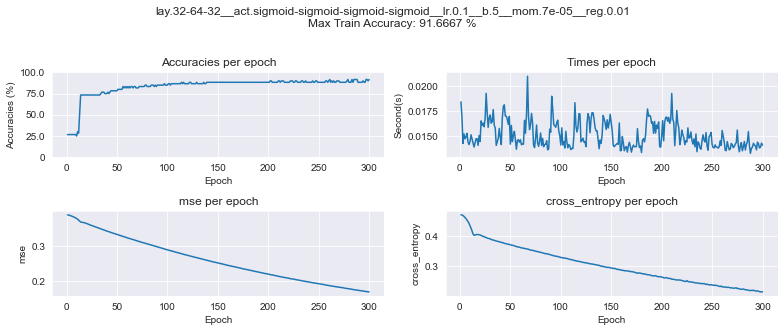

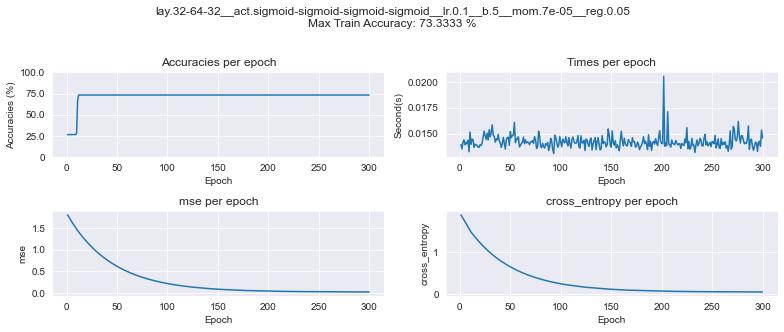

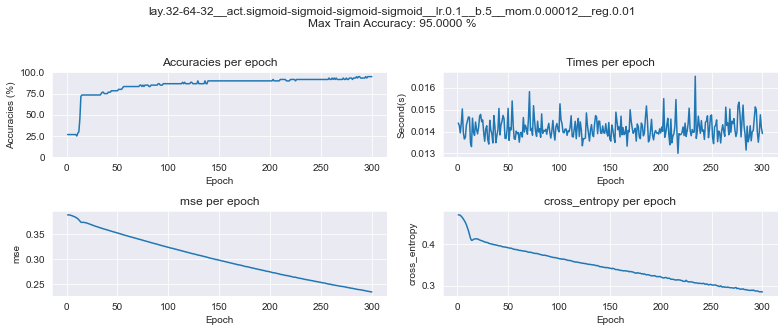

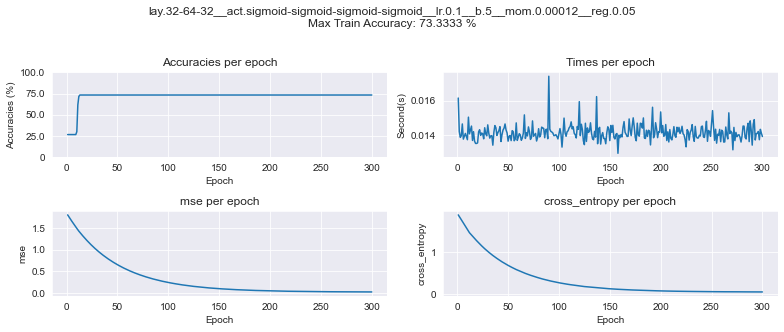

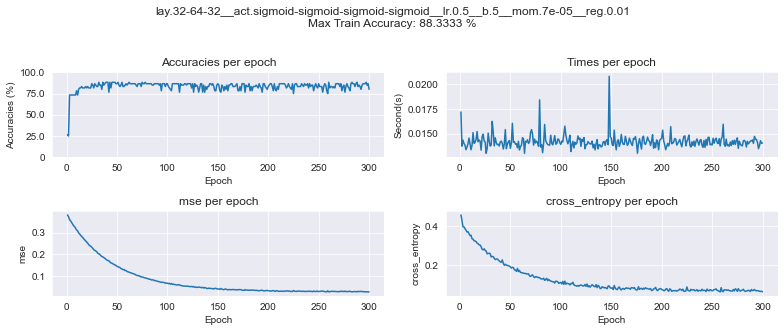

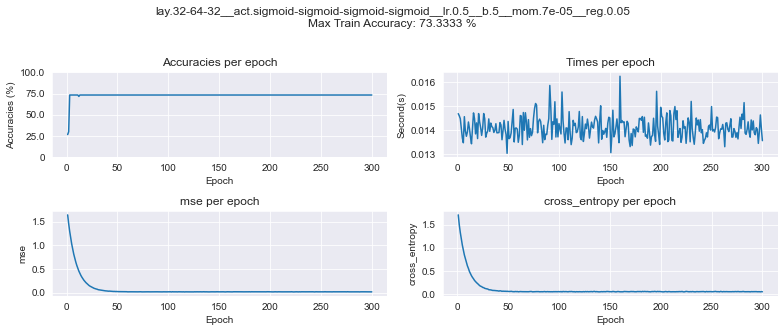

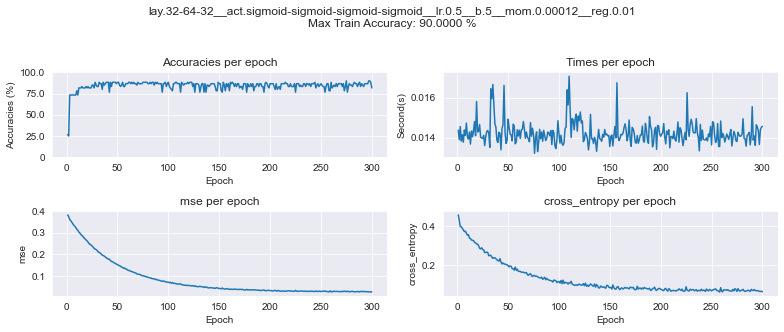

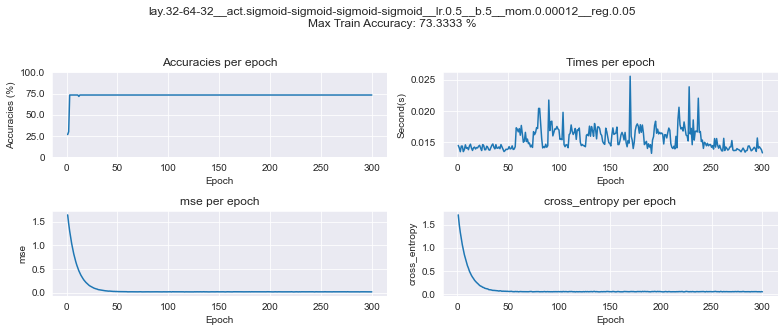

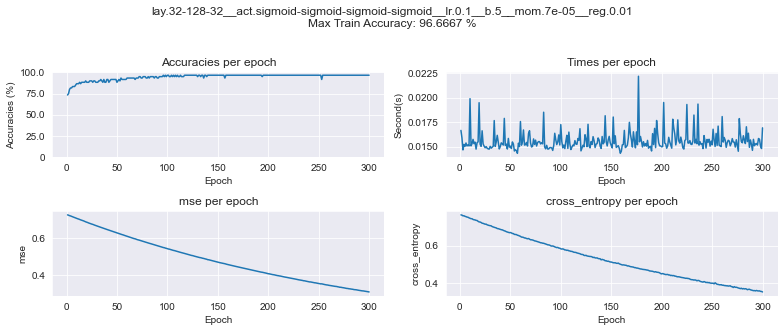

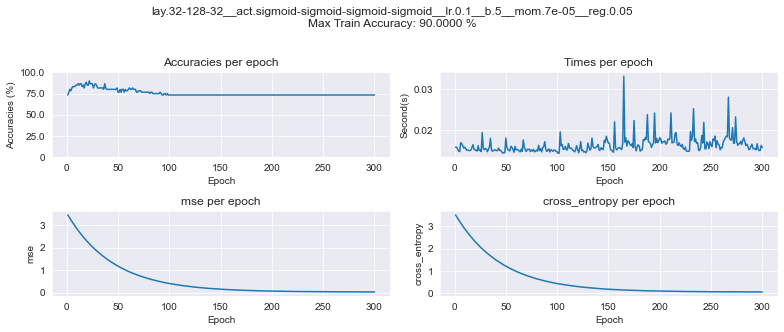

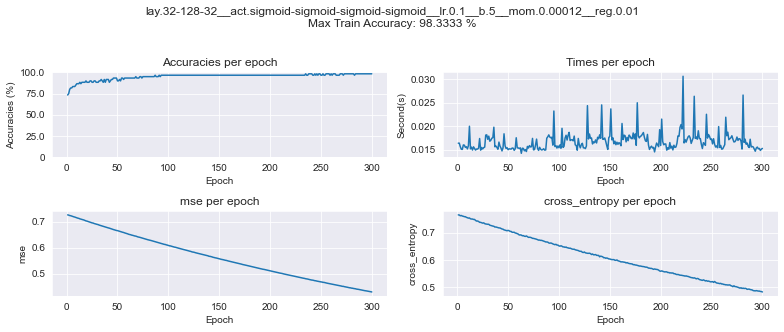

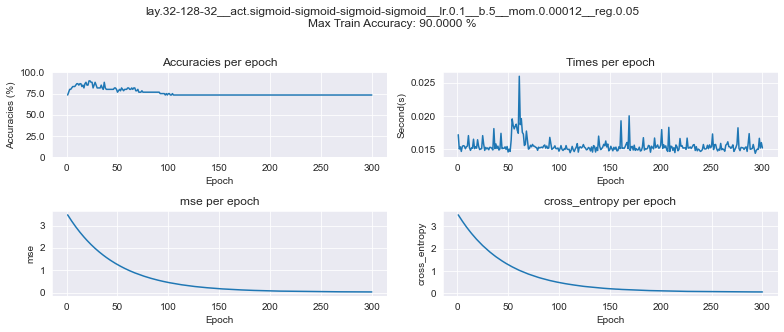

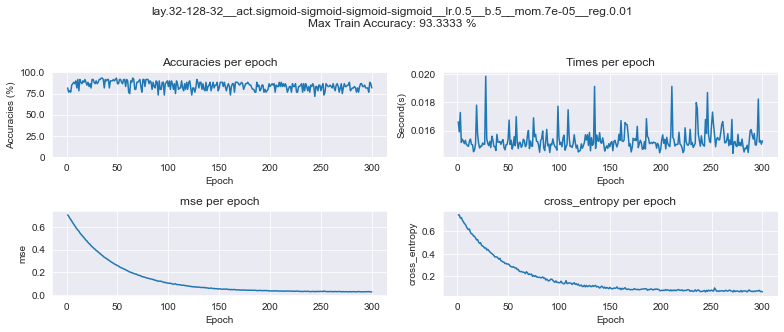

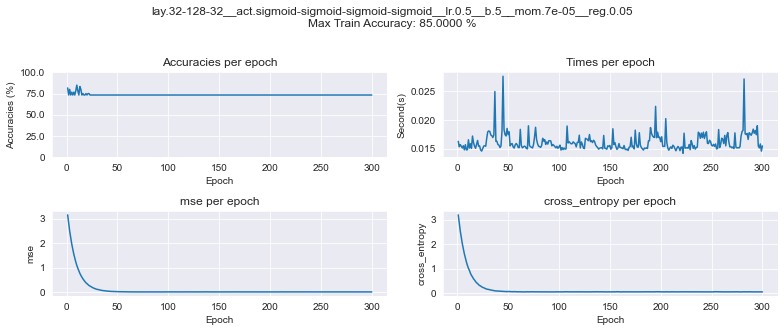

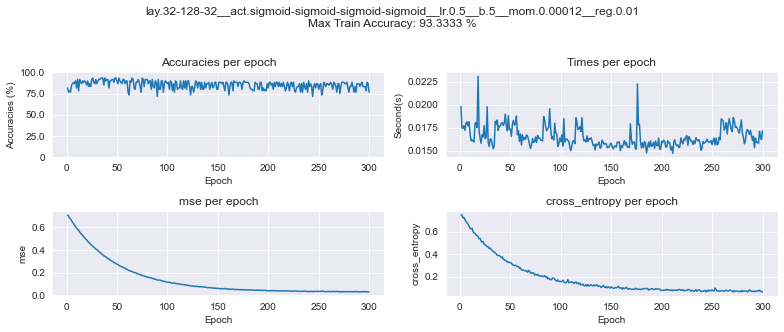

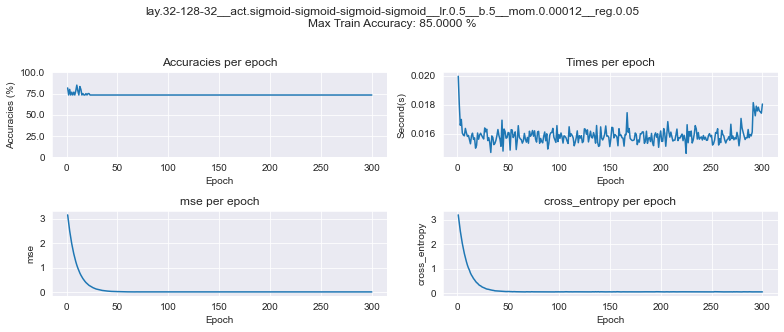

In [10]:
for name in pima_models:
    test_and_plot(title=name,
                  accuracies=pima_accuracies[name], 
                  losses=pima_losses[name], 
                  times=pima_times[name], 
                  subsample=1)

## Train model on Training set

In [30]:
# Lambda func to create string from list (for creating names)
join_lst = lambda lst: '-'.join([str(el) for el in lst])

# Select best Hyperparams from validation set
loss_functions = ['mse', 'cross_entropy']
symmetric_weights = True
shuffle = True
seed = 3
early_stopping = {"max_accuracy": 0.999, 'wait': 2}
debug = {'epochs': 1, 'batches': 10**10, 
         'ff': False, 'bp': False, 'w': False, 'metrics': False}
max_epochs = 300
b_size = 5
reg = 0.01
mom = 0.00012
lr = 0.1
lay = [32, 64, 32]
act = ["sigmoid", "sigmoid", "sigmoid", "sigmoid"]

# Dicts to save results
pima_models = {}
pima_accuracies = {}
pima_losses = {}
pima_times = {}

# Train on train set and save results
name = f"lay.{join_lst(lay)}__act.{join_lst(act)}__lr.{lr}__b.{b_size}__mom.{mom}__reg.{reg}"
pima_models[name], pima_accuracies[name], pima_losses[name], pima_times[name] = \
train_dataset(name, pima_te.copy(), pima_te_y_one_hot.copy(), lay, act, 
              loss_functions, lr, mom, b_size, early_stopping,
              max_epochs, reg, shuffle, symmetric_weights, seed, debug)



2021-11-20 18:57:03 Project      INFO     Training lay.32-64-32__act.sigmoid-sigmoid-sigmoid-sigmoid__lr.0.1__b.5__mom.0.00012__reg.0.01 dataset..
2021-11-20 18:57:03 Project4 Models INFO     Epoch: 1
2021-11-20 18:57:03 Project4 Models INFO       mse Loss: 0.06968
2021-11-20 18:57:03 Project4 Models INFO       cross_entropy Loss: 0.08229
2021-11-20 18:57:03 Project4 Models INFO       Accuracy: 109/332
2021-11-20 18:57:03 Project4 Models INFO     Epoch: 2
2021-11-20 18:57:03 Project4 Models INFO       mse Loss: 0.06818
2021-11-20 18:57:03 Project4 Models INFO       cross_entropy Loss: 0.07541
2021-11-20 18:57:03 Project4 Models INFO       Accuracy: 114/332
2021-11-20 18:57:03 Project4 Models INFO     Epoch: 3
2021-11-20 18:57:04 Project4 Models INFO       mse Loss: 0.06725
2021-11-20 18:57:04 Project4 Models INFO       cross_entropy Loss: 0.07387
2021-11-20 18:57:04 Project4 Models INFO       Accuracy: 223/332
2021-11-20 18:57:04 Project4 Models INFO     Epoch: 4
2021-11-20 18:57:04 P

2021-11-20 18:57:07 Project4 Models INFO     Epoch: 27
2021-11-20 18:57:07 Project4 Models INFO       mse Loss: 0.05258
2021-11-20 18:57:07 Project4 Models INFO       cross_entropy Loss: 0.06021
2021-11-20 18:57:07 Project4 Models INFO       Accuracy: 269/332
2021-11-20 18:57:07 Project4 Models INFO     Epoch: 28
2021-11-20 18:57:07 Project4 Models INFO       mse Loss: 0.05199
2021-11-20 18:57:07 Project4 Models INFO       cross_entropy Loss: 0.05934
2021-11-20 18:57:07 Project4 Models INFO       Accuracy: 265/332
2021-11-20 18:57:07 Project4 Models INFO     Epoch: 29
2021-11-20 18:57:07 Project4 Models INFO       mse Loss: 0.05155
2021-11-20 18:57:07 Project4 Models INFO       cross_entropy Loss: 0.05933
2021-11-20 18:57:07 Project4 Models INFO       Accuracy: 269/332
2021-11-20 18:57:07 Project4 Models INFO     Epoch: 30
2021-11-20 18:57:07 Project4 Models INFO       mse Loss: 0.05096
2021-11-20 18:57:07 Project4 Models INFO       cross_entropy Loss: 0.05839
2021-11-20 18:57:07 Proje

2021-11-20 18:57:11 Project4 Models INFO       cross_entropy Loss: 0.04844
2021-11-20 18:57:11 Project4 Models INFO       Accuracy: 274/332
2021-11-20 18:57:11 Project4 Models INFO     Epoch: 54
2021-11-20 18:57:11 Project4 Models INFO       mse Loss: 0.04020
2021-11-20 18:57:11 Project4 Models INFO       cross_entropy Loss: 0.04851
2021-11-20 18:57:11 Project4 Models INFO       Accuracy: 277/332
2021-11-20 18:57:11 Project4 Models INFO     Epoch: 55
2021-11-20 18:57:11 Project4 Models INFO       mse Loss: 0.03981
2021-11-20 18:57:11 Project4 Models INFO       cross_entropy Loss: 0.04812
2021-11-20 18:57:11 Project4 Models INFO       Accuracy: 276/332
2021-11-20 18:57:11 Project4 Models INFO     Epoch: 56
2021-11-20 18:57:11 Project4 Models INFO       mse Loss: 0.03944
2021-11-20 18:57:11 Project4 Models INFO       cross_entropy Loss: 0.04787
2021-11-20 18:57:11 Project4 Models INFO       Accuracy: 277/332
2021-11-20 18:57:11 Project4 Models INFO     Epoch: 57
2021-11-20 18:57:11 Proje

2021-11-20 18:57:14 Project4 Models INFO       Accuracy: 275/332
2021-11-20 18:57:14 Project4 Models INFO     Epoch: 80
2021-11-20 18:57:15 Project4 Models INFO       mse Loss: 0.03129
2021-11-20 18:57:15 Project4 Models INFO       cross_entropy Loss: 0.03951
2021-11-20 18:57:15 Project4 Models INFO       Accuracy: 281/332
2021-11-20 18:57:15 Project4 Models INFO     Epoch: 81
2021-11-20 18:57:15 Project4 Models INFO       mse Loss: 0.03105
2021-11-20 18:57:15 Project4 Models INFO       cross_entropy Loss: 0.03956
2021-11-20 18:57:15 Project4 Models INFO       Accuracy: 275/332
2021-11-20 18:57:15 Project4 Models INFO     Epoch: 82
2021-11-20 18:57:15 Project4 Models INFO       mse Loss: 0.03067
2021-11-20 18:57:15 Project4 Models INFO       cross_entropy Loss: 0.03867
2021-11-20 18:57:15 Project4 Models INFO       Accuracy: 280/332
2021-11-20 18:57:15 Project4 Models INFO     Epoch: 83
2021-11-20 18:57:15 Project4 Models INFO       mse Loss: 0.03044
2021-11-20 18:57:15 Project4 Models

2021-11-20 18:57:18 Project4 Models INFO     Epoch: 106
2021-11-20 18:57:18 Project4 Models INFO       mse Loss: 0.02471
2021-11-20 18:57:18 Project4 Models INFO       cross_entropy Loss: 0.03312
2021-11-20 18:57:18 Project4 Models INFO       Accuracy: 272/332
2021-11-20 18:57:18 Project4 Models INFO     Epoch: 107
2021-11-20 18:57:18 Project4 Models INFO       mse Loss: 0.02447
2021-11-20 18:57:18 Project4 Models INFO       cross_entropy Loss: 0.03273
2021-11-20 18:57:18 Project4 Models INFO       Accuracy: 277/332
2021-11-20 18:57:18 Project4 Models INFO     Epoch: 108
2021-11-20 18:57:19 Project4 Models INFO       mse Loss: 0.02423
2021-11-20 18:57:19 Project4 Models INFO       cross_entropy Loss: 0.03236
2021-11-20 18:57:19 Project4 Models INFO       Accuracy: 280/332
2021-11-20 18:57:19 Project4 Models INFO     Epoch: 109
2021-11-20 18:57:19 Project4 Models INFO       mse Loss: 0.02401
2021-11-20 18:57:19 Project4 Models INFO       cross_entropy Loss: 0.03210
2021-11-20 18:57:19 P

2021-11-20 18:57:22 Project4 Models INFO       mse Loss: 0.01967
2021-11-20 18:57:22 Project4 Models INFO       cross_entropy Loss: 0.02748
2021-11-20 18:57:22 Project4 Models INFO       Accuracy: 273/332
2021-11-20 18:57:22 Project4 Models INFO     Epoch: 133
2021-11-20 18:57:22 Project4 Models INFO       mse Loss: 0.01965
2021-11-20 18:57:22 Project4 Models INFO       cross_entropy Loss: 0.02818
2021-11-20 18:57:22 Project4 Models INFO       Accuracy: 274/332
2021-11-20 18:57:22 Project4 Models INFO     Epoch: 134
2021-11-20 18:57:22 Project4 Models INFO       mse Loss: 0.01947
2021-11-20 18:57:22 Project4 Models INFO       cross_entropy Loss: 0.02789
2021-11-20 18:57:22 Project4 Models INFO       Accuracy: 274/332
2021-11-20 18:57:22 Project4 Models INFO     Epoch: 135
2021-11-20 18:57:22 Project4 Models INFO       mse Loss: 0.01924
2021-11-20 18:57:22 Project4 Models INFO       cross_entropy Loss: 0.02729
2021-11-20 18:57:22 Project4 Models INFO       Accuracy: 273/332
2021-11-20 1

2021-11-20 18:57:26 Project4 Models INFO       cross_entropy Loss: 0.02507
2021-11-20 18:57:26 Project4 Models INFO       Accuracy: 275/332
2021-11-20 18:57:26 Project4 Models INFO     Epoch: 159
2021-11-20 18:57:26 Project4 Models INFO       mse Loss: 0.01586
2021-11-20 18:57:26 Project4 Models INFO       cross_entropy Loss: 0.02363
2021-11-20 18:57:26 Project4 Models INFO       Accuracy: 273/332
2021-11-20 18:57:26 Project4 Models INFO     Epoch: 160
2021-11-20 18:57:26 Project4 Models INFO       mse Loss: 0.01583
2021-11-20 18:57:26 Project4 Models INFO       cross_entropy Loss: 0.02406
2021-11-20 18:57:26 Project4 Models INFO       Accuracy: 273/332
2021-11-20 18:57:26 Project4 Models INFO     Epoch: 161
2021-11-20 18:57:26 Project4 Models INFO       mse Loss: 0.01567
2021-11-20 18:57:26 Project4 Models INFO       cross_entropy Loss: 0.02369
2021-11-20 18:57:26 Project4 Models INFO       Accuracy: 274/332
2021-11-20 18:57:26 Project4 Models INFO     Epoch: 162
2021-11-20 18:57:26 P

2021-11-20 18:57:29 Project4 Models INFO       Accuracy: 269/332
2021-11-20 18:57:29 Project4 Models INFO     Epoch: 185
2021-11-20 18:57:29 Project4 Models INFO       mse Loss: 0.01325
2021-11-20 18:57:29 Project4 Models INFO       cross_entropy Loss: 0.02148
2021-11-20 18:57:29 Project4 Models INFO       Accuracy: 273/332
2021-11-20 18:57:29 Project4 Models INFO     Epoch: 186
2021-11-20 18:57:30 Project4 Models INFO       mse Loss: 0.01309
2021-11-20 18:57:30 Project4 Models INFO       cross_entropy Loss: 0.02097
2021-11-20 18:57:30 Project4 Models INFO       Accuracy: 271/332
2021-11-20 18:57:30 Project4 Models INFO     Epoch: 187
2021-11-20 18:57:30 Project4 Models INFO       mse Loss: 0.01303
2021-11-20 18:57:30 Project4 Models INFO       cross_entropy Loss: 0.02106
2021-11-20 18:57:30 Project4 Models INFO       Accuracy: 273/332
2021-11-20 18:57:30 Project4 Models INFO     Epoch: 188
2021-11-20 18:57:30 Project4 Models INFO       mse Loss: 0.01303
2021-11-20 18:57:30 Project4 Mo

2021-11-20 18:57:33 Project4 Models INFO     Epoch: 211
2021-11-20 18:57:33 Project4 Models INFO       mse Loss: 0.01124
2021-11-20 18:57:33 Project4 Models INFO       cross_entropy Loss: 0.01951
2021-11-20 18:57:33 Project4 Models INFO       Accuracy: 274/332
2021-11-20 18:57:33 Project4 Models INFO     Epoch: 212
2021-11-20 18:57:33 Project4 Models INFO       mse Loss: 0.01126
2021-11-20 18:57:33 Project4 Models INFO       cross_entropy Loss: 0.01993
2021-11-20 18:57:33 Project4 Models INFO       Accuracy: 276/332
2021-11-20 18:57:33 Project4 Models INFO     Epoch: 213
2021-11-20 18:57:33 Project4 Models INFO       mse Loss: 0.01112
2021-11-20 18:57:33 Project4 Models INFO       cross_entropy Loss: 0.01944
2021-11-20 18:57:33 Project4 Models INFO       Accuracy: 273/332
2021-11-20 18:57:33 Project4 Models INFO     Epoch: 214
2021-11-20 18:57:34 Project4 Models INFO       mse Loss: 0.01102
2021-11-20 18:57:34 Project4 Models INFO       cross_entropy Loss: 0.01917
2021-11-20 18:57:34 P

2021-11-20 18:57:37 Project4 Models INFO       mse Loss: 0.00973
2021-11-20 18:57:37 Project4 Models INFO       cross_entropy Loss: 0.01792
2021-11-20 18:57:37 Project4 Models INFO       Accuracy: 274/332
2021-11-20 18:57:37 Project4 Models INFO     Epoch: 238
2021-11-20 18:57:37 Project4 Models INFO       mse Loss: 0.00963
2021-11-20 18:57:37 Project4 Models INFO       cross_entropy Loss: 0.01761
2021-11-20 18:57:37 Project4 Models INFO       Accuracy: 271/332
2021-11-20 18:57:37 Project4 Models INFO     Epoch: 239
2021-11-20 18:57:37 Project4 Models INFO       mse Loss: 0.00965
2021-11-20 18:57:37 Project4 Models INFO       cross_entropy Loss: 0.01795
2021-11-20 18:57:37 Project4 Models INFO       Accuracy: 272/332
2021-11-20 18:57:37 Project4 Models INFO     Epoch: 240
2021-11-20 18:57:37 Project4 Models INFO       mse Loss: 0.00975
2021-11-20 18:57:37 Project4 Models INFO       cross_entropy Loss: 0.01878
2021-11-20 18:57:37 Project4 Models INFO       Accuracy: 271/332
2021-11-20 1

2021-11-20 18:57:41 Project4 Models INFO       cross_entropy Loss: 0.01661
2021-11-20 18:57:41 Project4 Models INFO       Accuracy: 271/332
2021-11-20 18:57:41 Project4 Models INFO     Epoch: 264
2021-11-20 18:57:41 Project4 Models INFO       mse Loss: 0.00855
2021-11-20 18:57:41 Project4 Models INFO       cross_entropy Loss: 0.01660
2021-11-20 18:57:41 Project4 Models INFO       Accuracy: 271/332
2021-11-20 18:57:41 Project4 Models INFO     Epoch: 265
2021-11-20 18:57:41 Project4 Models INFO       mse Loss: 0.00858
2021-11-20 18:57:41 Project4 Models INFO       cross_entropy Loss: 0.01699
2021-11-20 18:57:41 Project4 Models INFO       Accuracy: 275/332
2021-11-20 18:57:41 Project4 Models INFO     Epoch: 266
2021-11-20 18:57:41 Project4 Models INFO       mse Loss: 0.00853
2021-11-20 18:57:41 Project4 Models INFO       cross_entropy Loss: 0.01685
2021-11-20 18:57:41 Project4 Models INFO       Accuracy: 274/332
2021-11-20 18:57:41 Project4 Models INFO     Epoch: 267
2021-11-20 18:57:41 P

2021-11-20 18:57:44 Project4 Models INFO       Accuracy: 270/332
2021-11-20 18:57:44 Project4 Models INFO     Epoch: 290
2021-11-20 18:57:44 Project4 Models INFO       mse Loss: 0.00778
2021-11-20 18:57:44 Project4 Models INFO       cross_entropy Loss: 0.01608
2021-11-20 18:57:44 Project4 Models INFO       Accuracy: 273/332
2021-11-20 18:57:44 Project4 Models INFO     Epoch: 291
2021-11-20 18:57:45 Project4 Models INFO       mse Loss: 0.00770
2021-11-20 18:57:45 Project4 Models INFO       cross_entropy Loss: 0.01579
2021-11-20 18:57:45 Project4 Models INFO       Accuracy: 273/332
2021-11-20 18:57:45 Project4 Models INFO     Epoch: 292
2021-11-20 18:57:45 Project4 Models INFO       mse Loss: 0.00776
2021-11-20 18:57:45 Project4 Models INFO       cross_entropy Loss: 0.01621
2021-11-20 18:57:45 Project4 Models INFO       Accuracy: 275/332
2021-11-20 18:57:45 Project4 Models INFO     Epoch: 293
2021-11-20 18:57:45 Project4 Models INFO       mse Loss: 0.00766
2021-11-20 18:57:45 Project4 Mo

## Test model on the test set and Plot

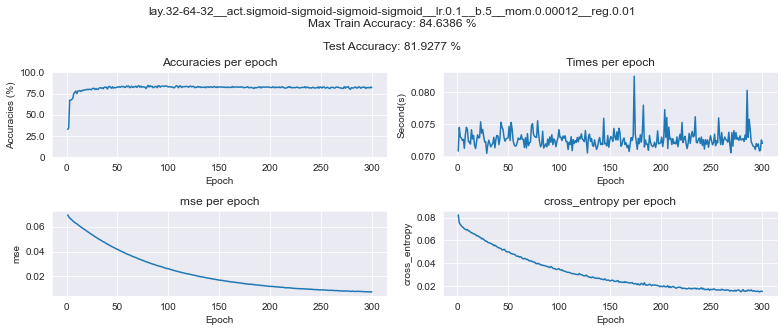

In [31]:
# Plot different the configurations for different Network Structures
for name in pima_models:
    test_and_plot(title=name,
                  test_set=pima_te.copy(),
                  one_hot_targets=pima_te_y_one_hot.copy(),
                  model=pima_models[name],
                  accuracies=pima_accuracies[name], 
                  losses=pima_losses[name], 
                  times=pima_times[name], 
                  subsample=1)

# Task 2 - Run the two example codes

In [1]:
!python custom_libs/CARLO/example_circularroad.py

pygame 2.1.0 (SDL 2.0.16, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
!python custom_libs/CARLO/example_intersection.py

Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Pedestrian has died, good job!
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewhere...
Collision exists somewher

# Task 3 - Modifications to the circular road scenario

In [7]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("custom_libs/CARLO")
from custom_libs.Project5.circular_custom import CircularScenario

pygame 2.1.0 (SDL 2.0.16, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [22]:
dt = 0.1  # time steps in terms of seconds. In other words, 1/dt is the FPS.
world_width = 120  # in meters
world_height = 120
inner_building_radius = 30
num_lanes = 2
lane_marker_width = 0.5
num_of_lane_markers = 50
lane_width = 3.5

circular_scenario = CircularScenario(dt=dt, width=world_width, height=world_height,
                                    num_lanes=num_lanes, lane_width=lane_width,
                                    lane_marker_width=lane_marker_width,
                                    num_lane_markers=num_of_lane_markers,
                                    build_radius=inner_building_radius)

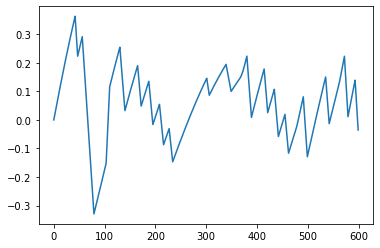

In [24]:
circular_scenario.run(opt='human_control', speed = 100)

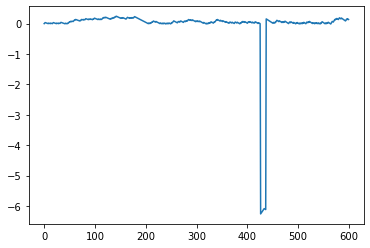

In [25]:
circular_scenario.run(opt='default', speed = 100)

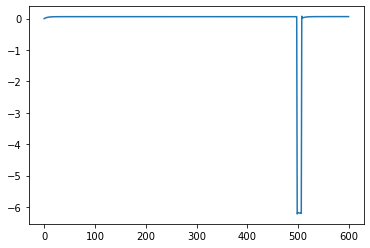

In [17]:
circular_scenario.run(opt='pid', speed = 100)

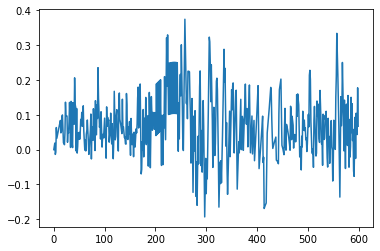

In [23]:
circular_scenario.run(opt='qlearning', speed = 100)